In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, depth, act=nn.Tanh):
        super(NN, self).__init__()
        layers = [('input', nn.Linear(input_size, hidden_size)), ('input_activation', act())]
        for i in range(depth):
            layers.append((f'hidden_{i}', nn.Linear(hidden_size, hidden_size)))
            layers.append((f'activation_{i}', act()))
        layers.append(('output', nn.Linear(hidden_size, output_size)))
        self.layers = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.layers(x)

class PINN:
    def __init__(self, params, x_range, t_range):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.params = params

        # Define the neural networks for each layer
        self.model_veh = NN(2, 20, 1, 4).to(self.device)
        self.model_sc_C = NN(2, 20, 1, 4).to(self.device)
        self.model_sc_B = NN(2, 20, 1, 4).to(self.device)
        self.model_ep = NN(2, 20, 1, 4).to(self.device)
        self.model_de = NN(2, 20, 1, 4).to(self.device)

        self.criterion = nn.MSELoss()

        # Define the domain
        self.x = torch.linspace(*x_range, 100, requires_grad=True).to(self.device)
        self.t = torch.linspace(*t_range, 100, requires_grad=True).to(self.device)
        self.X, self.T = torch.meshgrid(self.x, self.t, indexing='ij')
        self.X_flat = self.X.flatten().reshape(-1, 1)
        self.T_flat = self.T.flatten().reshape(-1, 1)
        self.XT = torch.cat([self.X_flat, self.T_flat], dim=1).to(self.device)
        self.XT.requires_grad_(True)

        # Optimizers
        self.optimizer_veh = optim.Adam(self.model_veh.parameters(), lr=1e-3)
        self.optimizer_sc_C = optim.Adam(self.model_sc_C.parameters(), lr=1e-3)
        self.optimizer_sc_B = optim.Adam(self.model_sc_B.parameters(), lr=1e-3)
        self.optimizer_ep = optim.Adam(self.model_ep.parameters(), lr=1e-3)
        self.optimizer_de = optim.Adam(self.model_de.parameters(), lr=1e-3)

    def loss_func(self):
        self.optimizer_veh.zero_grad()
        self.optimizer_sc_C.zero_grad()
        self.optimizer_sc_B.zero_grad()
        self.optimizer_ep.zero_grad()
        self.optimizer_de.zero_grad()

        params = self.params

        # Predict concentrations
        C_veh_pred = self.model_veh(self.XT).reshape(self.X.shape)
        C_sc_pred = self.model_sc_C(self.XT).reshape(self.X.shape)
        B_sc_pred = self.model_sc_B(self.XT).reshape(self.X.shape)
        C_ep_pred = self.model_ep(self.XT).reshape(self.X.shape)
        C_de_pred = self.model_de(self.XT).reshape(self.X.shape)

        # Calculate partial derivatives
        dC_veh_dt = torch.autograd.grad(C_veh_pred, self.T, torch.ones_like(C_veh_pred), create_graph=True)[0]
        dC_veh_dx = torch.autograd.grad(C_veh_pred, self.X, torch.ones_like(C_veh_pred), create_graph=True)[0]
        d2C_veh_dx2 = torch.autograd.grad(dC_veh_dx, self.X, torch.ones_like(dC_veh_dx), create_graph=True)[0]

        dC_sc_dt = torch.autograd.grad(C_sc_pred, self.T, torch.ones_like(C_sc_pred), create_graph=True)[0]
        dC_sc_dx = torch.autograd.grad(C_sc_pred, self.X, torch.ones_like(C_sc_pred), create_graph=True)[0]
        d2C_sc_dx2 = torch.autograd.grad(dC_sc_dx, self.X, torch.ones_like(dC_sc_dx), create_graph=True)[0]

        dB_sc_dt = torch.autograd.grad(B_sc_pred, self.T, torch.ones_like(B_sc_pred), create_graph=True)[0]

        dC_ep_dt = torch.autograd.grad(C_ep_pred, self.T, torch.ones_like(C_ep_pred), create_graph=True)[0]
        dC_ep_dx = torch.autograd.grad(C_ep_pred, self.X, torch.ones_like(C_ep_pred), create_graph=True)[0]
        d2C_ep_dx2 = torch.autograd.grad(dC_ep_dx, self.X, torch.ones_like(dC_ep_dx), create_graph=True)[0]

        dC_de_dt = torch.autograd.grad(C_de_pred, self.T, torch.ones_like(C_de_pred), create_graph=True)[0]
        dC_de_dx = torch.autograd.grad(C_de_pred, self.X, torch.ones_like(C_de_pred), create_graph=True)[0]
        d2C_de_dx2 = torch.autograd.grad(dC_de_dx, self.X, torch.ones_like(dC_de_dx), create_graph=True)[0]

        # PDE loss
        MSE_e1 = self.criterion(dC_veh_dt, params['D_veh'] * d2C_veh_dx2)
        MSE_e2 = self.criterion(dC_sc_dt, params['D_sc'] * d2C_sc_dx2 - params['k_f'] * C_sc_pred + params['k_r'] * B_sc_pred)
        MSE_e3 = self.criterion(dB_sc_dt, params['k_f'] * C_sc_pred - params['k_r'] * B_sc_pred)
        MSE_e4 = self.criterion(dC_ep_dt, params['D_ep'] * d2C_ep_dx2)
        MSE_e5 = self.criterion(dC_de_dt, params['D_de'] * d2C_de_dx2)
        MSE_e = MSE_e1 + MSE_e2 + MSE_e3 + MSE_e4 + MSE_e5

        # Boundary condition loss
        bc1_mask = (self.X == self.x[0]).flatten()
        bc2_mask = (self.X == self.x[-1]).flatten()
        bc1 = torch.cat([self.X_flat[bc1_mask], self.T_flat[bc1_mask]], dim=1)
        bc2 = torch.cat([self.X_flat[bc2_mask], self.T_flat[bc2_mask]], dim=1)
        MSE_b1 = self.criterion(self.model_veh(bc1), torch.full((bc1.shape[0], 1), params['C1']).to(self.device))
        MSE_b2 = self.criterion(self.model_de(bc2), torch.zeros((bc2.shape[0], 1)).to(self.device))
        MSE_b = MSE_b1 + MSE_b2

        # Initial condition loss
        ic_mask = (self.T == self.t[0]).flatten()
        ic = torch.cat([self.X_flat[ic_mask], self.T_flat[ic_mask]], dim=1)
        MSE_i1 = self.criterion(self.model_veh(ic), torch.full((ic.shape[0], 1), params['C0']).to(self.device))
        MSE_i2 = self.criterion(self.model_sc_C(ic), torch.zeros((ic.shape[0], 1)).to(self.device))
        MSE_i3 = self.criterion(self.model_sc_B(ic), torch.zeros((ic.shape[0], 1)).to(self.device))
        MSE_i4 = self.criterion(self.model_ep(ic), torch.zeros((ic.shape[0], 1)).to(self.device))
        MSE_i5 = self.criterion(self.model_de(ic), torch.zeros((ic.shape[0], 1)).to(self.device))
        MSE_i = MSE_i1 + MSE_i2 + MSE_i3 + MSE_i4 + MSE_i5

        # Continuity condition loss at the interfaces
        x_veh_mask = (self.X == params['x_veh']).flatten()
        x_sc_mask = (self.X == params['x_sc']).flatten()
        x_ep_mask = (self.X == params['x_ep']).flatten()

        x_veh = torch.cat([self.X_flat[x_veh_mask], self.T_flat[x_veh_mask]], dim=1)
        x_sc = torch.cat([self.X_flat[x_sc_mask], self.T_flat[x_sc_mask]], dim=1)
        x_ep = torch.cat([self.X_flat[x_ep_mask], self.T_flat[x_ep_mask]], dim=1)

        MSE_c1 = self.criterion(self.model_veh(x_veh), self.model_sc_C(x_veh))
        MSE_c2 = self.criterion(self.model_sc_C(x_sc), self.model_ep(x_sc))
        MSE_c3 = self.criterion(self.model_ep(x_ep), self.model_de(x_ep))

        # Total loss
        loss = MSE_e + MSE_b + MSE_i + MSE_c1 + MSE_c2 + MSE_c3

        loss.backward()
        self.optimizer_veh.step()
        self.optimizer_sc_C.step()
        self.optimizer_sc_B.step()
        self.optimizer_ep.step()
        self.optimizer_de.step()

        return loss.item()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.loss_func()
            if epoch % 100 == 0:
                print(f'Epoch {epoch}: Loss = {loss:.4e}')

    def plot_results(self):
        x_vals = self.x.cpu().detach().numpy()
        t_vals = self.t.cpu().detach().numpy()

        C_veh_pred = self.model_veh(self.XT).reshape(self.X.shape).cpu().detach().numpy()
        C_sc_pred = self.model_sc_C(self.XT).reshape(self.X.shape).cpu().detach().numpy()
        B_sc_pred = self.model_sc_B(self.XT).reshape(self.X.shape).cpu().detach().numpy()
        C_ep_pred = self.model_ep(self.XT).reshape(self.X.shape).cpu().detach().numpy()
        C_de_pred = self.model_de(self.XT).reshape(self.X.shape).cpu().detach().numpy()

        fig, axes = plt.subplots(1, 5, figsize=(25, 5))
        caxes = []

        for ax, title, data in zip(axes, ['Vehicle', 'Stratum Corneum (C)', 'Stratum Corneum (B)', 'Epidermis', 'Dermis'], [C_veh_pred, C_sc_pred, B_sc_pred, C_ep_pred, C_de_pred]):
            cax = ax.imshow(data, extent=(self.t[0], self.t[-1], self.x[0], self.x[-1]), origin='lower', aspect='auto')
            ax.set_title(title)
            ax.set_xlabel('Time')
            ax.set_ylabel('Position')
            fig.colorbar(cax, ax=ax)
            caxes.append(cax)

        plt.show()

# Parameters
params = {
    'D_veh': 1.0e-9,
    'D_sc': 2.0e-9,
    'D_ep': 3.0e-9,
    'D_de': 4.0e-9,
    'k_f': 1.0e-3,
    'k_r': 1.0e-3,
    'C0': 1.0,
    'C1': 0.5,
    'x_veh': 0.2,
    'x_sc': 0.4,
    'x_ep': 0.6,
    'x_de': 0.8,
}

x_range = (0.0, 1.0)
t_range = (0.0, 1.0)

# Create the PINN
pinn = PINN(params, x_range, t_range)

# Train the PINN
pinn.train(epochs=1000)

# Plot results
pinn.plot_results()

Epoch 0, Loss: 2.8679027557373047
Epoch 100, Loss: 0.17512229084968567
Epoch 200, Loss: 0.1293575018644333
Epoch 300, Loss: 0.06431539356708527
Epoch 400, Loss: 0.044317640364170074
Epoch 500, Loss: 0.03766313195228577
Epoch 600, Loss: 0.03221769630908966
Epoch 700, Loss: 0.02821636199951172
Epoch 800, Loss: 0.02564610354602337
Epoch 900, Loss: 0.023492511361837387
Epoch 1000, Loss: 0.02146548591554165
Epoch 1100, Loss: 0.019539810717105865
Epoch 1200, Loss: 0.017804117873311043
Epoch 1300, Loss: 0.016362851485610008
Epoch 1400, Loss: 0.01515942346304655
Epoch 1500, Loss: 0.01406862773001194
Epoch 1600, Loss: 0.013038504868745804
Epoch 1700, Loss: 0.012124079279601574
Epoch 1800, Loss: 0.01136106625199318
Epoch 1900, Loss: 0.010742279700934887
Epoch 2000, Loss: 0.010210676118731499
Epoch 2100, Loss: 0.009890924207866192
Epoch 2200, Loss: 0.009336378425359726
Epoch 2300, Loss: 0.008982239291071892
Epoch 2400, Loss: 0.008608813397586346
Epoch 2500, Loss: 0.008285515010356903
Epoch 2600, 

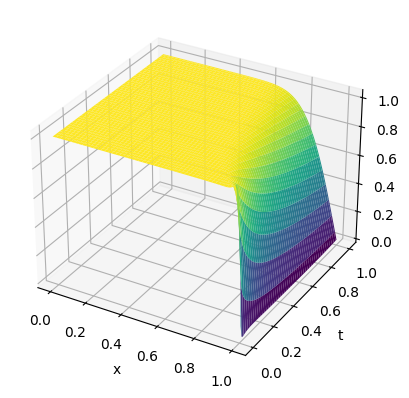

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import OrderedDict

# Define the neural network
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, depth, act=nn.Tanh):
        super(NN, self).__init__()
        layers = [('input', nn.Linear(input_size, hidden_size)), ('input_activation', act())]
        for i in range(depth):
            layers.append((f'hidden_{i}', nn.Linear(hidden_size, hidden_size)))
            layers.append((f'activation_{i}', act()))
        layers.append(('output', nn.Linear(hidden_size, output_size)))
        self.layers = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.layers(x)

class PINN:
    def __init__(self, D_veh, C1, C0, K_veh, gamma_b, gamma_i, x_range, t_range):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.D_veh = D_veh
        self.C1 = C1
        self.C0 = C0
        self.K_veh = K_veh
        self.gamma_b = gamma_b
        self.gamma_i = gamma_i

        self.model = NN(2, 20, 1, 4).to(self.device)
        self.criterion = nn.MSELoss()

        # Define the domain
        self.x = torch.linspace(*x_range, 100, requires_grad=True).to(self.device)
        self.t = torch.linspace(*t_range, 100, requires_grad=True).to(self.device)
        self.X, self.T = torch.meshgrid(self.x, self.t, indexing='ij')
        self.X_flat = self.X.flatten().reshape(-1, 1)
        self.T_flat = self.T.flatten().reshape(-1, 1)
        self.XT = torch.cat([self.X_flat, self.T_flat], dim=1).to(self.device)
        self.XT.requires_grad_(True)

        # Optimizers
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    def loss_func(self):
        self.optimizer.zero_grad()

        # Predict concentration
        C_pred = self.model(self.XT).reshape(self.X.shape)

        # # Check requires_grad status
        # print(f"C_pred.requires_grad: {C_pred.requires_grad}")
        # print(f"self.T.requires_grad: {self.T.requires_grad}")
        # print(f"self.X.requires_grad: {self.X.requires_grad}")

        # Calculate partial derivatives
        dC_dt = torch.autograd.grad(C_pred, self.T, torch.ones_like(C_pred), create_graph=True)[0]
        dC_dx = torch.autograd.grad(C_pred, self.X, torch.ones_like(C_pred), create_graph=True)[0]
        d2C_dx2 = torch.autograd.grad(dC_dx, self.X, torch.ones_like(dC_dx), create_graph=True)[0]

        # PDE loss
        MSE_e = self.criterion(dC_dt, self.D_veh * d2C_dx2)

        # Boundary condition loss
        bc1_mask = (self.X == self.x[0]).flatten()
        bc2_mask = (self.X == self.x[-1]).flatten()
        bc1 = torch.cat([self.X_flat[bc1_mask], self.T_flat[bc1_mask]], dim=1)
        bc2 = torch.cat([self.X_flat[bc2_mask], self.T_flat[bc2_mask]], dim=1)
        MSE_b1 = self.criterion(self.model(bc1), torch.full((bc1.shape[0], 1), self.C1).to(self.device))
        MSE_b2 = self.criterion(self.model(bc2), torch.zeros((bc2.shape[0], 1)).to(self.device))
        MSE_b = MSE_b1 + MSE_b2

        # Initial condition loss
        ic_mask = (self.T == self.t[0]).flatten()
        ic = torch.cat([self.X_flat[ic_mask], self.T_flat[ic_mask]], dim=1)
        MSE_i = self.criterion(self.model(ic), self.C0 * self.K_veh * torch.ones_like(self.X_flat[ic_mask]).to(self.device))

        # Total loss
        loss = MSE_e + self.gamma_b * MSE_b + self.gamma_i * MSE_i
        loss.backward()
        return loss

    def train(self, epochs=10000):
        for epoch in range(epochs):
            loss = self.loss_func()
            self.optimizer.step()
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

    def predict(self, x, t):
        xt = torch.cat([x.reshape(-1, 1), t.reshape(-1, 1)], dim=1).to(self.device)
        return self.model(xt).cpu().detach().numpy()

# Constants
D_veh = 0.01
C1 = 1.0
C0 = 1.0
K_veh = 1.0
gamma_b = 1.0
gamma_i = 1.0
x_range = (0, 1)
t_range = (0, 1)

# Training
pinn = PINN(D_veh, C1, C0, K_veh, gamma_b, gamma_i, x_range, t_range)
pinn.train()

# Predict
x_test = torch.linspace(0, 1, 100)
t_test = torch.linspace(0, 1, 100)
X_test, T_test = torch.meshgrid(x_test, t_test, indexing='ij')
C_pred = pinn.predict(X_test.flatten(), T_test.flatten()).reshape(100, 100)

# Plot the results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_test.cpu().numpy(), T_test.cpu().numpy(), C_pred, cmap='viridis')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict

class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth, activation=nn.Tanh):
        super(PINN, self).__init__()
        layers = [('input', nn.Linear(input_dim, hidden_dim))]
        layers.append(('input_activation', activation()))
        for i in range(depth):
            layers.append((f'hidden_{i}', nn.Linear(hidden_dim, hidden_dim)))
            layers.append((f'activation_{i}', activation()))
        layers.append(('output', nn.Linear(hidden_dim, output_dim)))
        self.layers = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.layers(x)

def mse_e(model, X, D, N):
    mse_e_total = 0
    for region, D_value in D.items():
        x, t = X[region][:, 0:1], X[region][:, 1:2]
        C = model(torch.cat([x, t], dim=1))[:, 0:1]

        C_t = torch.autograd.grad(C, t, torch.ones_like(C), create_graph=True)[0]
        C_xx = torch.autograd.grad(torch.autograd.grad(C, x, torch.ones_like(C), create_graph=True)[0], x, torch.ones_like(C), create_graph=True)[0]

        eq = C_t - D_value * C_xx
        mse_e_total += torch.sum(eq**2) / N[region]

    return mse_e_total

# Example usage:
input_dim = 2  # x and t
hidden_dim = 20
output_dim = 1  # Single concentration output for each region
depth = 4

pinn_model = PINN(input_dim, hidden_dim, output_dim, depth)

# Define your training data (X) based on initial and boundary conditions
# Example data, modify as per your problem
X = {
    'veh': torch.rand(100, 2),  # 100 data points with 2 features (x, t)
    'sc': torch.rand(100, 2),   # 100 data points with 2 features (x, t)
    'ep': torch.rand(100, 2),   # 100 data points with 2 features (x, t)
    'de': torch.rand(100, 2)    # 100 data points with 2 features (x, t)
}

D = {
    'veh': 0.1,
    'sc': 0.01,
    'ep': 0.1,
    'de': 0.1
}

N = {
    'veh': 100,
    'sc': 100,
    'ep': 100,
    'de': 100
}

mse_e_value = mse_e(pinn_model, X, D, N)
print("MSE_e:", mse_e_value.item())

In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict

class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth, activation=nn.Tanh):
        super(PINN, self).__init__()
        layers = [('input', nn.Linear(input_dim, hidden_dim))]
        layers.append(('input_activation', activation()))
        for i in range(depth):
            layers.append((f'hidden_{i}', nn.Linear(hidden_dim, hidden_dim)))
            layers.append((f'activation_{i}', activation()))
        layers.append(('output', nn.Linear(hidden_dim, output_dim)))
        self.layers = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.layers(x)

def mse_e(model, X_e1, X_e2, X_e3, X_e4, D_veh=0.1, D_sc=0.01, D_ep=0.1, D_de=0.1):
    x_e1, t_e1 = X_e1[:, 0:1], X_e1[:, 1:2]
    x_e2, t_e2 = X_e2[:, 0:1], X_e2[:, 1:2]
    x_e3, t_e3 = X_e3[:, 0:1], X_e3[:, 1:2]
    x_e4, t_e4 = X_e4[:, 0:1], X_e4[:, 1:2]

    C_veh = model(torch.cat([x_e1, t_e1], dim=1))[:, 0:1]
    C_sc = model(torch.cat([x_e2, t_e2], dim=1))[:, 1:2]
    C_ep = model(torch.cat([x_e3, t_e3], dim=1))[:, 2:3]
    C_de = model(torch.cat([x_e4, t_e4], dim=1))[:, 3:4]

    C_veh_t = torch.autograd.grad(C_veh, t_e1, torch.ones_like(C_veh), create_graph=True)[0]
    C_veh_xx = torch.autograd.grad(torch.autograd.grad(C_veh, x_e1, torch.ones_like(C_veh), create_graph=True)[0], x_e1, torch.ones_like(C_veh), create_graph=True)[0]
    eq1 = C_veh_t - D_veh * C_veh_xx
    mse_e1 = torch.mean(eq1**2)

    C_sc_t = torch.autograd.grad(C_sc, t_e2, torch.ones_like(C_sc), create_graph=True)[0]
    C_sc_xx = torch.autograd.grad(torch.autograd.grad(C_sc, x_e2, torch.ones_like(C_sc), create_graph=True)[0], x_e2, torch.ones_like(C_sc), create_graph=True)[0]
    eq2 = C_sc_t - D_sc * C_sc_xx
    mse_e2 = torch.mean(eq2**2)

    C_ep_t = torch.autograd.grad(C_ep, t_e3, torch.ones_like(C_ep), create_graph=True)[0]
    C_ep_xx = torch.autograd.grad(torch.autograd.grad(C_ep, x_e3, torch.ones_like(C_ep), create_graph=True)[0], x_e3, torch.ones_like(C_ep), create_graph=True)[0]
    eq3 = C_ep_t - D_ep * C_ep_xx
    mse_e3 = torch.mean(eq3**2)

    C_de_t = torch.autograd.grad(C_de, t_e4, torch.ones_like(C_de), create_graph=True)[0]
    C_de_xx = torch.autograd.grad(torch.autograd.grad(C_de, x_e4, torch.ones_like(C_de), create_graph=True)[0], x_e4, torch.ones_like(C_de), create_graph=True)[0]
    eq4 = C_de_t - D_de * C_de_xx
    mse_e4 = torch.mean(eq4**2)

    mse_e_total = (mse_e1 + mse_e2 + mse_e3 + mse_e4) / 4

    return mse_e_total

# Example usage:
input_dim = 2  # x and t
hidden_dim = 20
output_dim = 5  # C_veh, C_sc, C_ep, C_de, B_sc
depth = 4

pinn_model = PINN(input_dim, hidden_dim, output_dim, depth)

# Define your training data (X_e1, X_e2, X_e3, X_e4) based on initial and boundary conditions
# Example data, modify as per your problem
X_e1 = torch.rand(100, 2)  # 100 data points with 2 features (x, t)
X_e2 = torch.rand(100, 2)  # 100 data points with 2 features (x, t)
X_e3 = torch.rand(100, 2)  # 100 data points with 2 features (x, t)
X_e4 = torch.rand(100, 2)  # 100 data points with 2 features (x, t)

mse_e_value = mse_e(pinn_model, X_e1, X_e2, X_e3, X_e4)
print("MSE_e:", mse_e_value.item())


In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict
import numpy as np

class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth, activation=nn.Tanh):
        super(PINN, self).__init__()
        layers = [('input', nn.Linear(input_dim, hidden_dim))]
        layers.append(('input_activation', activation()))
        for i in range(depth):
            layers.append((f'hidden_{i}', nn.Linear(hidden_dim, hidden_dim)))
            layers.append((f'activation_{i}', activation()))
        layers.append(('output', nn.Linear(hidden_dim, output_dim)))
        self.layers = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.layers(x)

def governing_equations(u, x, t, D_veh=0.1, D_sc=0.01, D_ep=0.1, D_de=0.1, k_f=0.01, k_r=0.01):
    C_veh, C_sc, C_ep, C_de, B_sc = u

    # Compute derivatives
    C_veh_t = torch.autograd.grad(C_veh, t, torch.ones_like(C_veh), create_graph=True)[0]
    C_veh_xx = torch.autograd.grad(torch.autograd.grad(C_veh, x, torch.ones_like(C_veh), create_graph=True)[0], x, torch.ones_like(C_veh), create_graph=True)[0]

    C_sc_t = torch.autograd.grad(C_sc, t, torch.ones_like(C_sc), create_graph=True)[0]
    C_sc_xx = torch.autograd.grad(torch.autograd.grad(C_sc, x, torch.ones_like(C_sc), create_graph=True)[0], x, torch.ones_like(C_sc), create_graph=True)[0]

    B_sc_t = torch.autograd.grad(B_sc, t, torch.ones_like(B_sc), create_graph=True)[0]

    C_ep_t = torch.autograd.grad(C_ep, t, torch.ones_like(C_ep), create_graph=True)[0]
    C_ep_xx = torch.autograd.grad(torch.autograd.grad(C_ep, x, torch.ones_like(C_ep), create_graph=True)[0], x, torch.ones_like(C_ep), create_graph=True)[0]

    C_de_t = torch.autograd.grad(C_de, t, torch.ones_like(C_de), create_graph=True)[0]
    C_de_xx = torch.autograd.grad(torch.autograd.grad(C_de, x, torch.ones_like(C_de), create_graph=True)[0], x, torch.ones_like(C_de), create_graph=True)[0]

    # Equations
    eq1 = C_veh_t - D_veh * C_veh_xx
    eq2 = C_sc_t - D_sc * C_sc_xx - k_f * C_sc + k_r * B_sc
    eq3 = B_sc_t - k_f * C_sc + k_r * B_sc
    eq4 = C_ep_t - D_ep * C_ep_xx
    eq5 = C_de_t - D_de * C_de_xx

    return eq1, eq2, eq3, eq4, eq5

class PINNModel:
    def __init__(self, model, learning_rate=0.001, gamma_b=1.0, gamma_i=1.0, gamma_c=1.0):
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        self.gamma_b = gamma_b
        self.gamma_i = gamma_i
        self.gamma_c = gamma_c

    def loss_function(self, X_train, y_train, X_bc, y_bc, X_ic, y_ic, X_cc, y_cc):
        self.model.train()
        y_pred = self.model(X_train)
        loss_data = self.criterion(y_pred, y_train)

        # Compute PDE loss
        x = X_train[:, 0].unsqueeze(1).requires_grad_(True)
        t = X_train[:, 1].unsqueeze(1).requires_grad_(True)
        u = self.model(torch.cat([x, t], dim=1))

        eq1, eq2, eq3, eq4, eq5 = governing_equations(u, x, t)
        mse_e = sum([self.criterion(eq, torch.zeros_like(eq)) for eq in [eq1, eq2, eq3, eq4, eq5]])

        # Boundary conditions loss
        y_bc_pred = self.model(X_bc)
        mse_b = self.criterion(y_bc_pred, y_bc)

        # Initial conditions loss
        y_ic_pred = self.model(X_ic)
        mse_i = self.criterion(y_ic_pred, y_ic)

        # Continuity conditions loss
        y_cc_pred = self.model(X_cc)
        mse_c = self.criterion(y_cc_pred, y_cc)

        # Combine all losses
        loss = mse_e + self.gamma_b * mse_b + self.gamma_i * mse_i + self.gamma_c * mse_c
        return loss

    def train(self, X_train, y_train, X_bc, y_bc, X_ic, y_ic, X_cc, y_cc, epochs=1000):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss = self.loss_function(X_train, y_train, X_bc, y_bc, X_ic, y_ic, X_cc, y_cc)
            loss.backward()
            self.optimizer.step()
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

# Example usage:

# Define your training data (X_train, y_train) based on initial and boundary conditions
# Example data, modify as per your problem
X_train = torch.rand(100, 2)  # 100 data points with 2 features (x, t)
y_train = torch.rand(100, 5)  # 100 corresponding target values for 5 outputs

# Boundary conditions data
X_bc = torch.rand(20, 2)  # 20 boundary condition data points
y_bc = torch.rand(20, 5)  # 20 corresponding target values for boundary conditions

# Initial conditions data
X_ic = torch.rand(20, 2)  # 20 initial condition data points
y_ic = torch.rand(20, 5)  # 20 corresponding target values for initial conditions

# Continuity conditions data
X_cc = torch.rand(20, 2)  # 20 continuity condition data points
y_cc = torch.rand(20, 5)  # 20 corresponding target values for continuity conditions

# Instantiate and train the model
input_dim = 2  # x and t
hidden_dim = 20
output_dim = 5  # C_veh, C_sc, C_ep, C_de, B_sc
depth = 4

pinn_model = PINN(input_dim, hidden_dim, output_dim, depth)
model = PINNModel(pinn_model)
model.train(X_train, y_train, X_bc, y_bc, X_ic, y_ic, X_cc, y_cc)

In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict
import numpy as np

# Governing equations as per the problem statement
def governing_equations(u, x, t):
    C_veh, C_sc, C_ep, C_de, B_sc = u

    D_veh, D_sc, D_ep, D_de = 0.1, 0.01, 0.1, 0.1  # Example values, adjust as per your data
    k_f, k_r = 0.01, 0.01  # Example values

    # Compute derivatives
    C_veh_t = torch.autograd.grad(C_veh, t, torch.ones_like(C_veh), create_graph=True)[0]
    C_veh_xx = torch.autograd.grad(torch.autograd.grad(C_veh, x, torch.ones_like(C_veh), create_graph=True)[0], x, torch.ones_like(C_veh), create_graph=True)[0]

    C_sc_t = torch.autograd.grad(C_sc, t, torch.ones_like(C_sc), create_graph=True)[0]
    C_sc_xx = torch.autograd.grad(torch.autograd.grad(C_sc, x, torch.ones_like(C_sc), create_graph=True)[0], x, torch.ones_like(C_sc), create_graph=True)[0]

    B_sc_t = torch.autograd.grad(B_sc, t, torch.ones_like(B_sc), create_graph=True)[0]

    C_ep_t = torch.autograd.grad(C_ep, t, torch.ones_like(C_ep), create_graph=True)[0]
    C_ep_xx = torch.autograd.grad(torch.autograd.grad(C_ep, x, torch.ones_like(C_ep), create_graph=True)[0], x, torch.ones_like(C_ep), create_graph=True)[0]

    C_de_t = torch.autograd.grad(C_de, t, torch.ones_like(C_de), create_graph=True)[0]
    C_de_xx = torch.autograd.grad(torch.autograd.grad(C_de, x, torch.ones_like(C_de), create_graph=True)[0], x, torch.ones_like(C_de), create_graph=True)[0]

    # Equations
    eq1 = C_veh_t - D_veh * C_veh_xx
    eq2 = C_sc_t - D_sc * C_sc_xx - k_f * C_sc + k_r * B_sc
    eq3 = B_sc_t - k_f * C_sc + k_r * B_sc
    eq4 = C_ep_t - D_ep * C_ep_xx
    eq5 = C_de_t - D_de * C_de_xx

    return eq1, eq2, eq3, eq4, eq5

class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth, activation=nn.Tanh):
        super(PINN, self).__init__()
        layers = [('input', nn.Linear(input_dim, hidden_dim))]
        layers.append(('input_activation', activation()))
        for i in range(depth):
            layers.append((f'hidden_{i}', nn.Linear(hidden_dim, hidden_dim)))
            layers.append((f'activation_{i}', activation()))
        layers.append(('output', nn.Linear(hidden_dim, output_dim)))
        self.layers = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.layers(x)

class PINNModel:
    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def loss_function(self, X_train, y_train):
        self.model.train()
        y_pred = self.model(X_train)
        loss_data = self.criterion(y_pred, y_train)

        # Compute PDE loss
        x = X_train[:, 0].unsqueeze(1).requires_grad_(True)
        t = X_train[:, 1].unsqueeze(1).requires_grad_(True)
        u = self.model(torch.cat([x, t], dim=1))

        eq1, eq2, eq3, eq4, eq5 = governing_equations(u, x, t)
        loss_pde = sum([self.criterion(eq, torch.zeros_like(eq)) for eq in [eq1, eq2, eq3, eq4, eq5]])

        # Combine data loss and PDE loss
        loss = loss_data + loss_pde
        return loss

    def train(self, X_train, y_train, epochs=1000):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss = self.loss_function(X_train, y_train)
            loss.backward()
            self.optimizer.step()
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

# Define your training data (X_train, y_train) based on initial and boundary conditions
# Example data, modify as per your problem
X_train = torch.rand(100, 2)  # 100 data points with 2 features (x, t)
y_train = torch.rand(100, 1)  # 100 corresponding target values

# Instantiate and train the model
input_dim = 2  # x and t
hidden_dim = 20
output_dim = 5  # C_veh, C_sc, C_ep, C_de, B_sc
depth = 4

pinn_model = PINN(input_dim, hidden_dim, output_dim, depth)
model = PINNModel(pinn_model)
model.train(X_train, y_train)

def evaluate(model, X_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    return y_pred

# Example evaluation
X_test = torch.rand(50, 2)  # 50 test points
y_pred = evaluate(pinn_model, X_test)

# Visualization (example using matplotlib)
import matplotlib.pyplot as plt

x_test = X_test[:, 0].numpy()
t_test = X_test[:, 1].numpy()
c_pred = y_pred.numpy()

plt.figure(figsize=(10, 6))
plt.scatter(x_test, c_pred[:, 0], label='C_veh', color='b')
plt.scatter(x_test, c_pred[:, 1], label='C_sc', color='g')
plt.scatter(x_test, c_pred[:, 2], label='C_ep', color='r')
plt.scatter(x_test, c_pred[:, 3], label='C_de', color='c')
plt.scatter(x_test, c_pred[:, 4], label='B_sc', color='m')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.legend()
plt.title('Predicted Concentrations')
plt.show()

In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np

# Define constants
x_veh = 0.2
x_sc = 0.4
x_ep = 0.6
x_de = 0.8
K_veh = 1.0
K_sc = 1.0
K_ep = 1.0
K_de = 1.0
D_veh = 1.0
D_sc = 1.0
D_ep = 1.0
D_de = 1.0
k_f = 1.0
k_r = 1.0

# Define PDEs
def pde(x, y):
    C_veh = y[:, 0:1]
    C_sc = y[:, 1:2]
    B_sc = y[:, 2:3]
    C_ep = y[:, 3:4]
    C_de = y[:, 4:5]

    dC_veh_dt = dde.grad.jacobian(y, x, i=0, j=1)
    dC_sc_dt = dde.grad.jacobian(y, x, i=1, j=1)
    dB_sc_dt = dde.grad.jacobian(y, x, i=2, j=1)
    dC_ep_dt = dde.grad.jacobian(y, x, i=3, j=1)
    dC_de_dt = dde.grad.jacobian(y, x, i=4, j=1)

    d2C_veh_dx2 = dde.grad.hessian(y, x, i=0, j=0)
    d2C_sc_dx2 = dde.grad.hessian(y, x, i=1, j=0)
    d2C_ep_dx2 = dde.grad.hessian(y, x, i=3, j=0)
    d2C_de_dx2 = dde.grad.hessian(y, x, i=4, j=0)

    eq_veh = dC_veh_dt - D_veh * d2C_veh_dx2
    eq_sc = dC_sc_dt - D_sc * d2C_sc_dx2 - k_f * C_sc + k_r * B_sc
    eq_B_sc = dB_sc_dt - k_f * C_sc + k_r * B_sc
    eq_ep = dC_ep_dt - D_ep * d2C_ep_dx2
    eq_de = dC_de_dt - D_de * d2C_de_dx2

    return [eq_veh, eq_sc, eq_B_sc, eq_ep, eq_de]

# Define geometry and time domain
geom = dde.geometry.Interval(0, x_de)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define boundary conditions
def boundary_veh(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

bc_veh = dde.DirichletBC(geomtime, lambda x: 1, boundary_veh, component=0)

def boundary_interface_veh_sc(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_veh)

def bc_interface_veh_sc(inside, outside, x):
    return [
        inside[:, 0:1] / K_veh - outside[:, 0:1] / K_sc,
        D_veh * dde.grad.jacobian(inside, x, i=0, j=0) - D_sc * dde.grad.jacobian(outside, x, i=1, j=0),
    ]

bc_veh_sc = dde.DirichletBC(geomtime, bc_interface_veh_sc, boundary_interface_veh_sc)

def boundary_interface_sc_ep(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_sc)

def bc_interface_sc_ep(inside, outside, x):
    return [
        inside[:, 1:2] / K_sc - outside[:, 0:1] / K_ep,
        D_sc * dde.grad.jacobian(inside, x, i=1, j=0) - D_ep * dde.grad.jacobian(outside, x, i=3, j=0),
    ]

bc_sc_ep = dde.DirichletBC(geomtime, bc_interface_sc_ep, boundary_interface_sc_ep)

def boundary_interface_ep_de(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_ep)

def bc_interface_ep_de(inside, outside, x):
    return [
        inside[:, 3:4] / K_ep - outside[:, 0:1] / K_de,
        D_ep * dde.grad.jacobian(inside, x, i=3, j=0) - D_de * dde.grad.jacobian(outside, x, i=4, j=0),
    ]

bc_ep_de = dde.DirichletBC(geomtime, bc_interface_ep_de, boundary_interface_ep_de)

def boundary_de(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_de)

bc_de = dde.DirichletBC(geomtime, lambda x: 0, boundary_de, component=0)

# Define initial conditions
def initial_veh(x, on_initial):
    return on_initial and np.isclose(x[1], 0)

ic_veh = dde.IC(geomtime, lambda x: 1, initial_veh, component=0)

def initial_sc(x, on_initial):
    return on_initial and np.isclose(x[1], 0)

ic_sc = dde.IC(geomtime, lambda x: 0, initial_sc, component=1)

def initial_ep(x, on_initial):
    return on_initial and np.isclose(x[1], 0)

ic_ep = dde.IC(geomtime, lambda x: 0, initial_ep, component=3)

def initial_de(x, on_initial):
    return on_initial and np.isclose(x[1], 0)

ic_de = dde.IC(geomtime, lambda x: 0, initial_de, component=4)

def initial_B_sc(x, on_initial):
    return on_initial and np.isclose(x[1], 0)

ic_B_sc = dde.IC(geomtime, lambda x: 0, initial_B_sc, component=2)

# Define the data object
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_veh, bc_veh_sc, bc_sc_ep, bc_ep_de, bc_de, ic_veh, ic_sc, ic_ep, ic_de, ic_B_sc],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
)

# Define the neural network
net = dde.maps.FNN([2] + [20] * 3 + [5], "tanh", "Glorot normal")

# Define the model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=10000)

# Save and plot the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.108011 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


ValueError: j=3 is not valid.

In [ ]:
import deepxde as dde
import numpy as np

# Define constants
x_veh = 0.2
x_sc = 0.4
x_ep = 0.6
x_de = 0.8
K_veh = 1.0
K_sc = 1.0
K_ep = 1.0
K_de = 1.0
D_veh = 1.0
D_sc = 1.0
D_ep = 1.0
D_de = 1.0

# Define geometry and time domain
geom = dde.geometry.Interval(0, x_de)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define PDEs (already provided in the initial implementation)

# Define boundary conditions
def boundary_veh(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

bc_veh = dde.DirichletBC(geomtime, lambda x: 1, boundary_veh, component=0)

def boundary_interface_veh_sc(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_veh)

def bc_interface_veh_sc(inside, outside, x):
    return [
        inside[:, 0:1] / K_veh - outside[:, 0:1] / K_sc,
        D_veh * dde.grad.jacobian(inside, x, i=0, j=0) - D_sc * dde.grad.jacobian(outside, x, i=0, j=0),
    ]

bc_veh_sc = dde.DirichletBC(geomtime, bc_interface_veh_sc, boundary_interface_veh_sc)

def boundary_interface_sc_ep(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_sc)

def bc_interface_sc_ep(inside, outside, x):
    return [
        inside[:, 0:1] / K_sc - outside[:, 0:1] / K_ep,
        D_sc * dde.grad.jacobian(inside, x, i=0, j=0) - D_ep * dde.grad.jacobian(outside, x, i=0, j=0),
    ]

bc_sc_ep = dde.DirichletBC(geomtime, bc_interface_sc_ep, boundary_interface_sc_ep)

def boundary_interface_ep_de(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_ep)

def bc_interface_ep_de(inside, outside, x):
    return [
        inside[:, 0:1] / K_ep - outside[:, 0:1] / K_de,
        D_ep * dde.grad.jacobian(inside, x, i=0, j=0) - D_de * dde.grad.jacobian(outside, x, i=0, j=0),
    ]

bc_ep_de = dde.DirichletBC(geomtime, bc_interface_ep_de, boundary_interface_ep_de)

def boundary_de(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_de)

bc_de = dde.DirichletBC(geomtime, lambda x: 0, boundary_de, component=0)

# Define initial conditions
def initial_veh(x, on_initial):
    return on_initial and np.isclose(x[1], 0)

ic_veh = dde.IC(geomtime, lambda x: 1, initial_veh, component=0)

def initial_sc(x, on_initial):
    return on_initial and np.isclose(x[1], 0)

ic_sc = dde.IC(geomtime, lambda x: 0, initial_sc, component=0)

def initial_ep(x, on_initial):
    return on_initial and np.isclose(x[1], 0)

ic_ep = dde.IC(geomtime, lambda x: 0, initial_ep, component=0)

def initial_de(x, on_initial):
    return on_initial and np.isclose(x[1], 0)

ic_de = dde.IC(geomtime, lambda x: 0, initial_de, component=0)

def initial_B_sc(x, on_initial):
    return on_initial and np.isclose(x[1], 0)

ic_B_sc = dde.IC(geomtime, lambda x: 0, initial_B_sc, component=1)

# Define the data object
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_veh, bc_veh_sc, bc_sc_ep, bc_ep_de, bc_de, ic_veh, ic_sc, ic_ep, ic_de, ic_B_sc],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
)

# Define the neural network
net = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

# Define the model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=10000)

# Save and plot the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

NameError: name 'pde' is not defined

In [ ]:
import deepxde as dde
import numpy as np

# Define geometry
x_veh = 1.0  # Example value
x_sc = 2.0  # Example value
x_ep = 3.0  # Example value
x_de = 4.0  # Example value
geom = dde.geometry.Interval(0, x_de)
timedomain = dde.geometry.TimeDomain(0, 1)

geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define constants
D_veh = 1.0  # Example value
D_sc = 0.5  # Example value
D_ep = 0.8  # Example value
D_de = 1.2  # Example value
k_f = 0.1  # Example value
k_r = 0.05  # Example value

def pde_veh(x, y):
    C_veh = y[:, 0:1]
    dC_veh_t = dde.grad.jacobian(y, x, i=0, j=1)
    dC_veh_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return dC_veh_t - D_veh * dC_veh_xx

def pde_sc(x, y):
    C_sc = y[:, 0:1]
    B_sc = y[:, 1:2]
    dC_sc_t = dde.grad.jacobian(y, x, i=0, j=1)
    dB_sc_t = dde.grad.jacobian(y, x, i=1, j=1)
    dC_sc_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return [
        dC_sc_t - D_sc * dC_sc_xx + k_f * C_sc - k_r * B_sc,
        dB_sc_t - k_f * C_sc + k_r * B_sc
    ]

def pde_ep(x, y):
    C_ep = y[:, 0:1]
    dC_ep_t = dde.grad.jacobian(y, x, i=0, j=1)
    dC_ep_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return dC_ep_t - D_ep * dC_ep_xx

def pde_de(x, y):
    C_de = y[:, 0:1]
    dC_de_t = dde.grad.jacobian(y, x, i=0, j=1)
    dC_de_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    return dC_de_t - D_de * dC_de_xx

def boundary_veh(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

bc_veh = dde.DirichletBC(geomtime, lambda x: 1, boundary_veh, component=0)

# Interface boundary conditions at x_veh
def boundary_interface_veh_sc(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_veh)

# Interface boundary conditions at x_sc
def boundary_interface_sc_ep(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_sc)

# Interface boundary conditions at x_ep
def boundary_interface_ep_de(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_ep)

# Boundary condition at x_de
def boundary_de(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_de)

bc_interface_veh_sc = dde.DirichletBC(
    geomtime, lambda x: x[:, 0:1] / K_veh, boundary_interface_veh_sc, component=0
)
bc_interface_sc_ep = dde.DirichletBC(
    geomtime, lambda x: x[:, 0:1] / K_sc, boundary_interface_sc_ep, component=0
)
bc_interface_ep_de = dde.DirichletBC(
    geomtime, lambda x: x[:, 0:1] / K_ep, boundary_interface_ep_de, component=0
)

bc_de = dde.DirichletBC(geomtime, lambda x: 0, boundary_de, component=0)

# Initial conditions
ic_veh = dde.IC(geomtime, lambda x: 1 if x[1] == 0 else 0, component=0)
ic_sc = dde.IC(geomtime, lambda x: 0, component=0)
ic_ep = dde.IC(geomtime, lambda x: 0, component=0)
ic_de = dde.IC(geomtime, lambda x: 0, component=0)
ic_B_sc = dde.IC(geomtime, lambda x: 0, component=1)

data = dde.data.TimePDE(
    geomtime,
    pde_veh,
    [bc_veh, bc_interface_veh_sc, bc_interface_sc_ep, bc_interface_ep_de, bc_de],
    [ic_veh, ic_sc, ic_ep, ic_de, ic_B_sc],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
)

net = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


TypeError: IC.__init__() missing 1 required positional argument: 'on_initial'

<ipython-input-4-460b81d55272>:371: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


6198.1515645980835


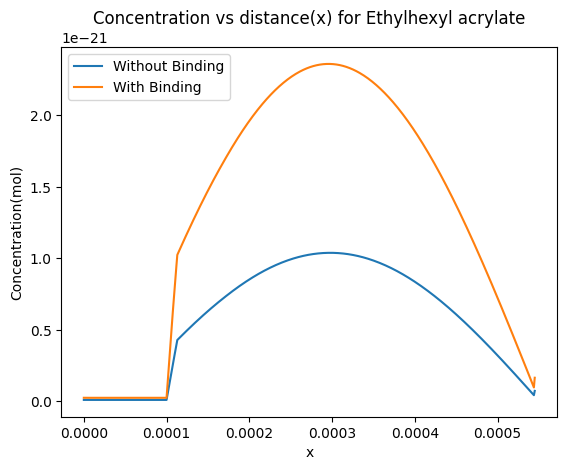

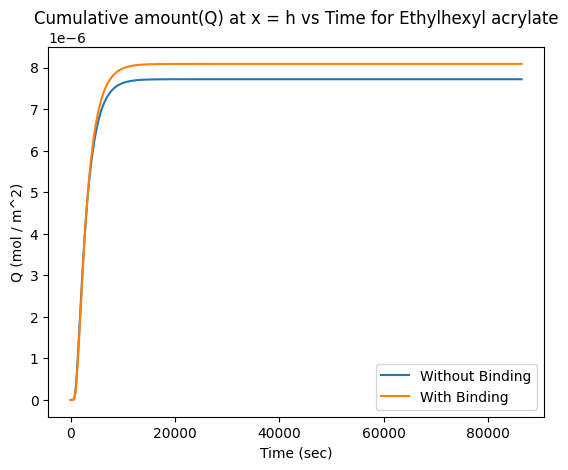

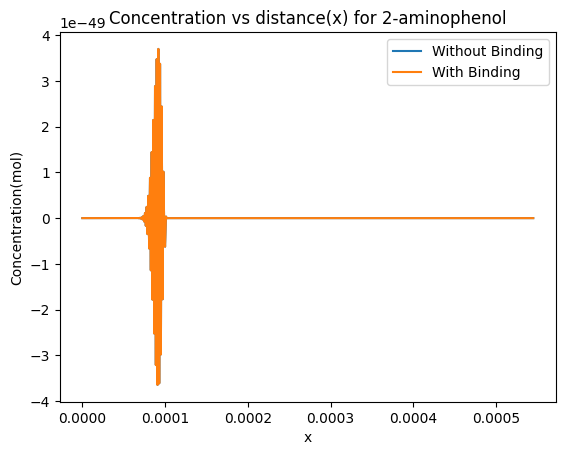

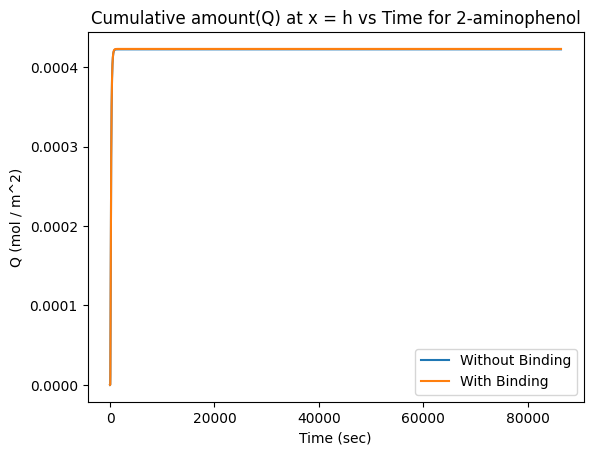

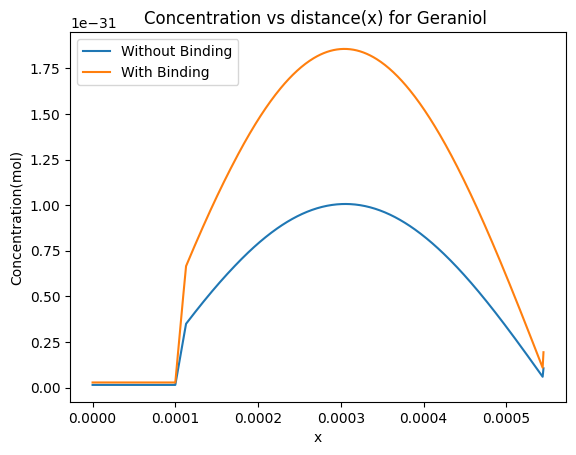

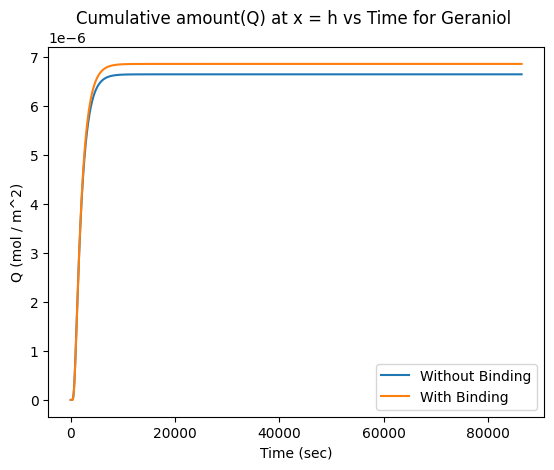

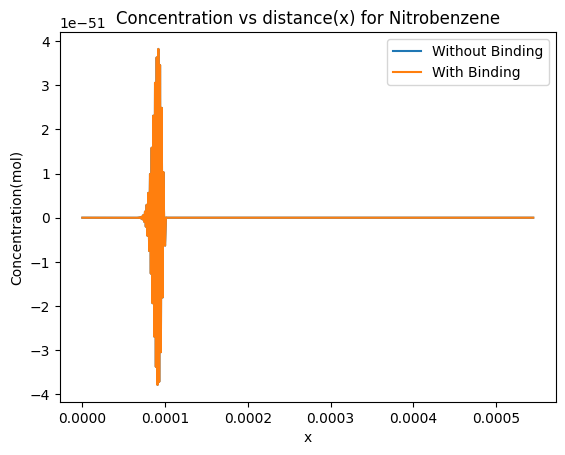

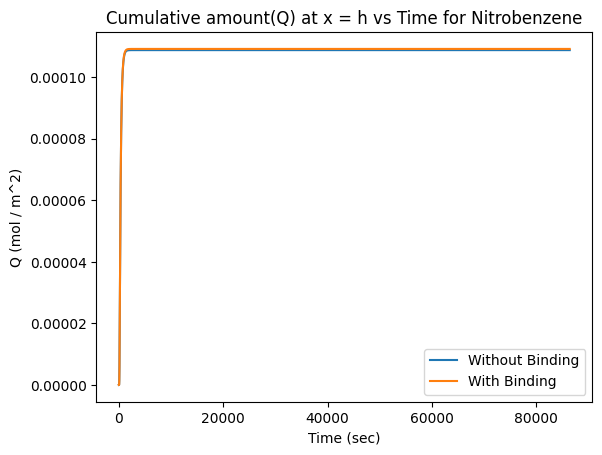

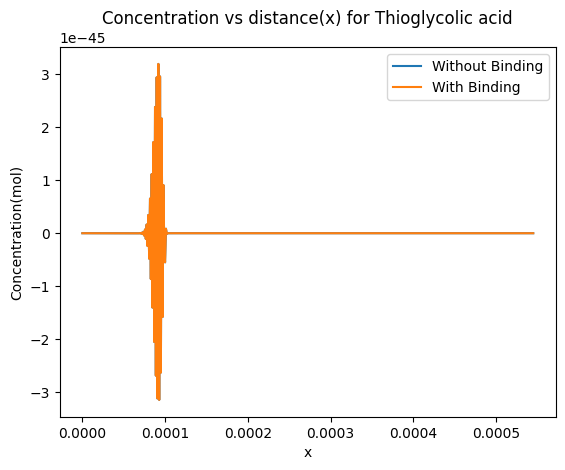

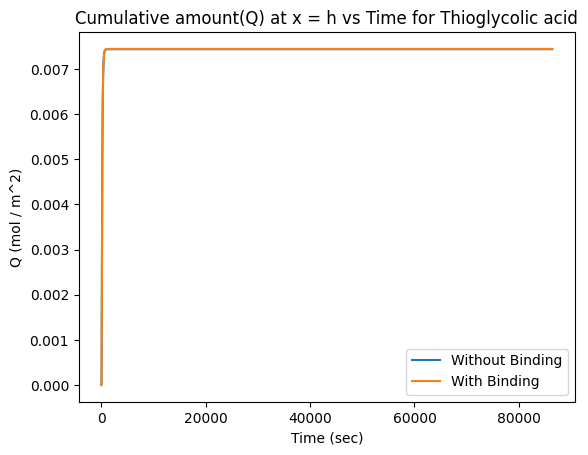

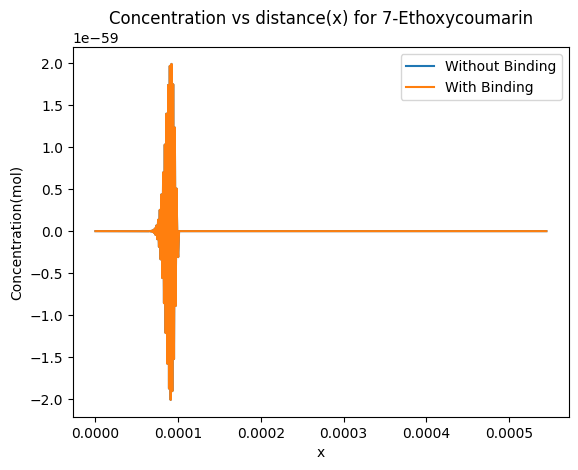

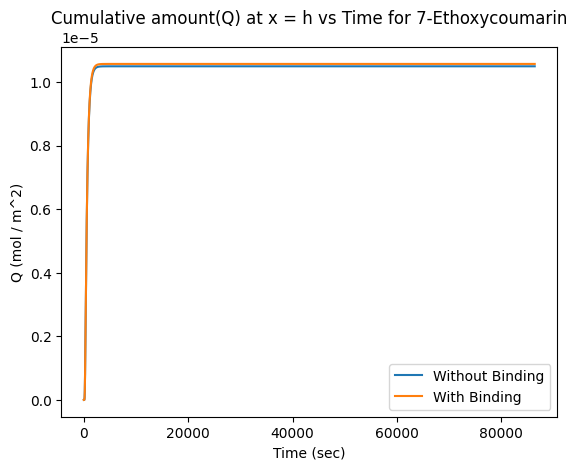

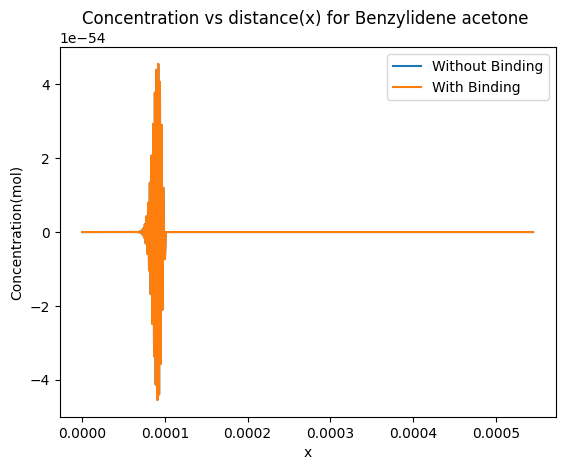

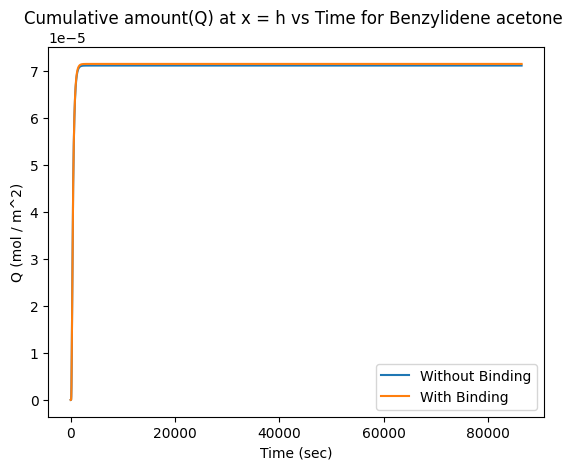

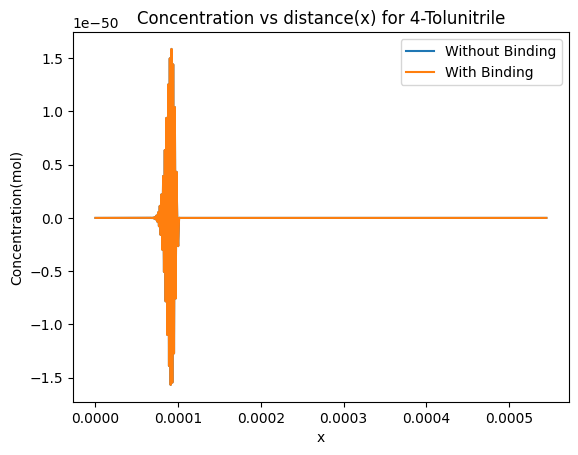

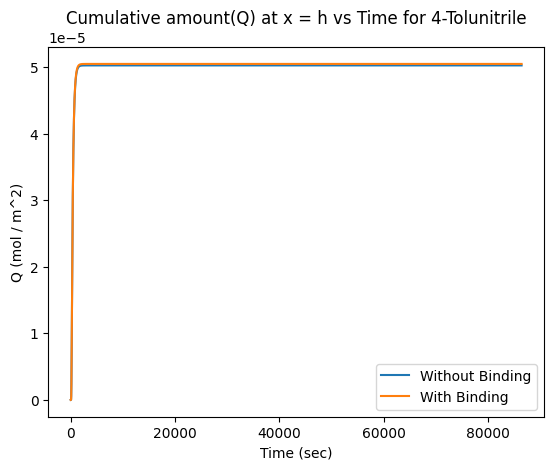

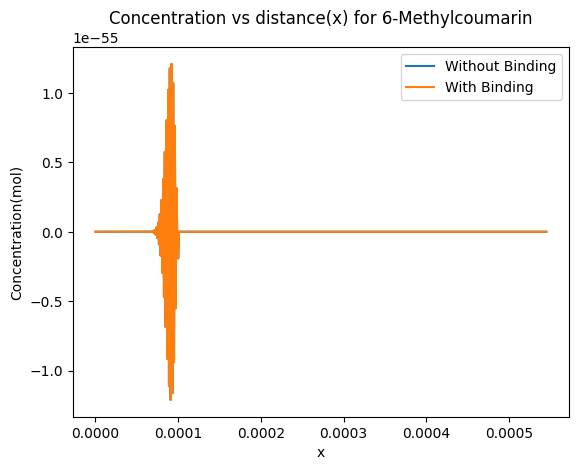

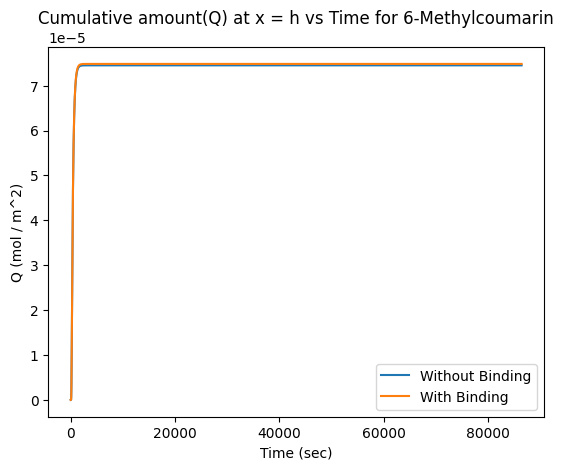

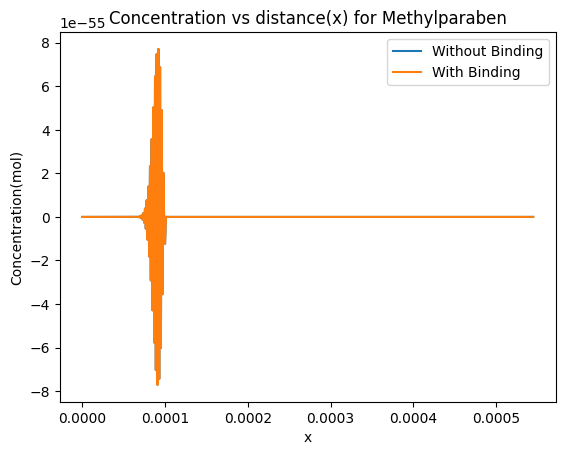

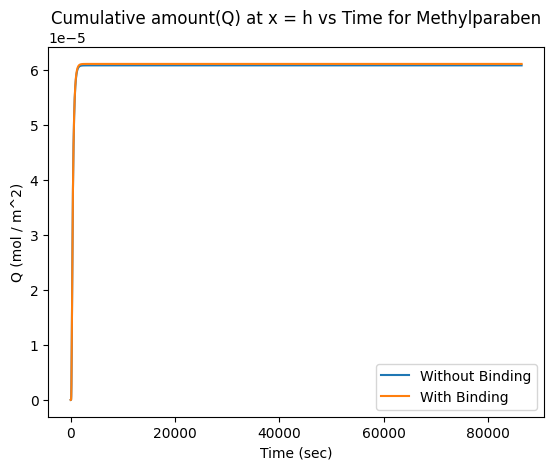

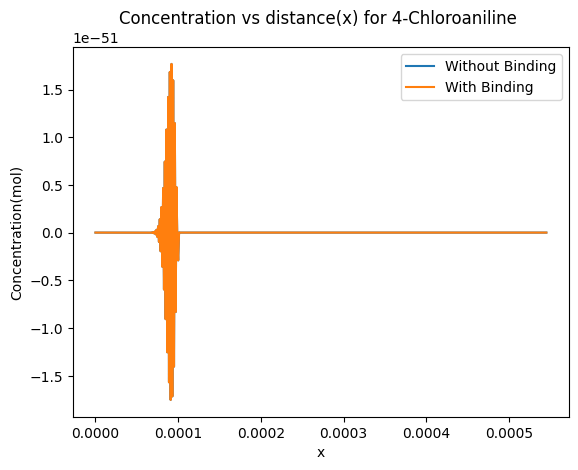

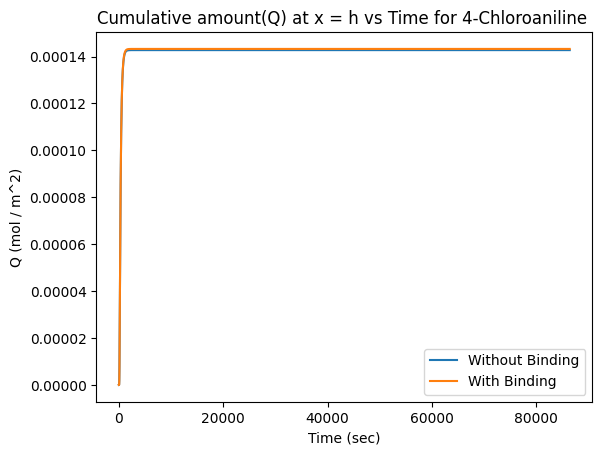

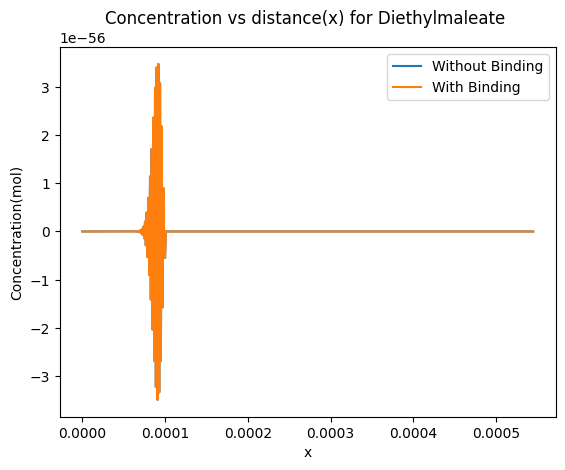

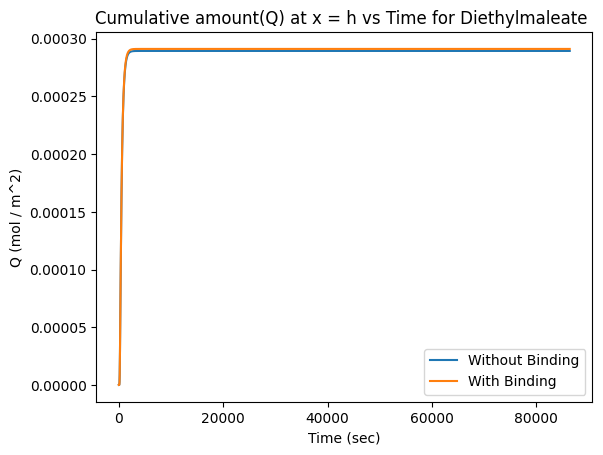

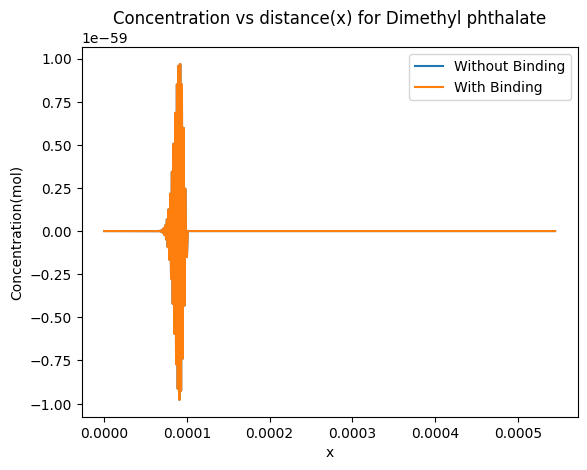

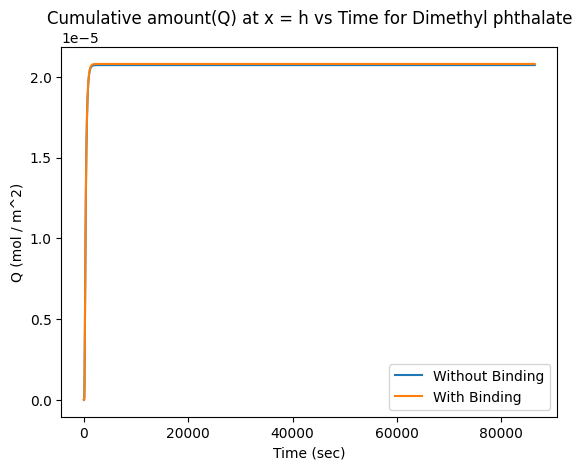

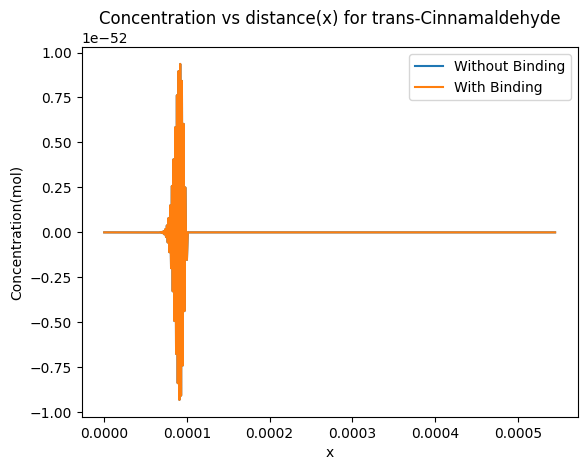

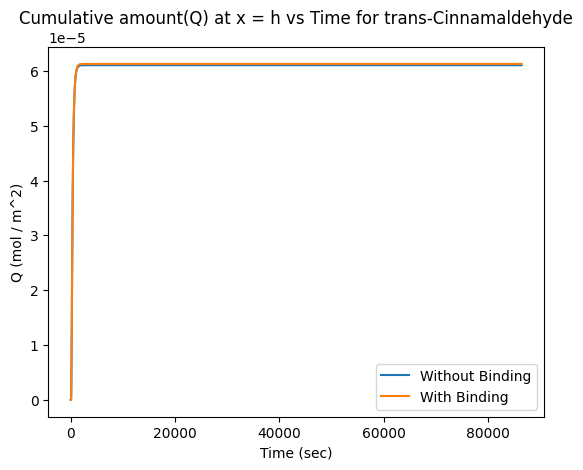

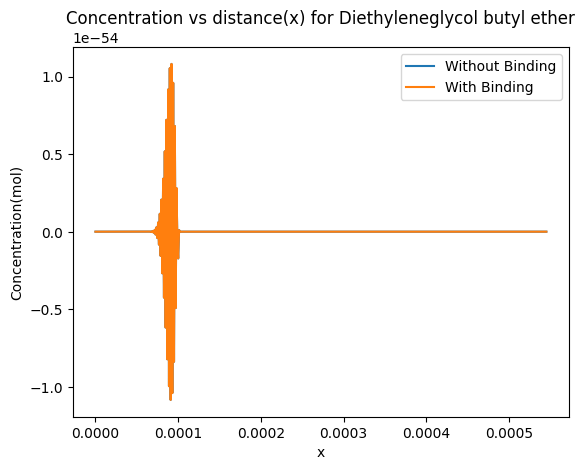

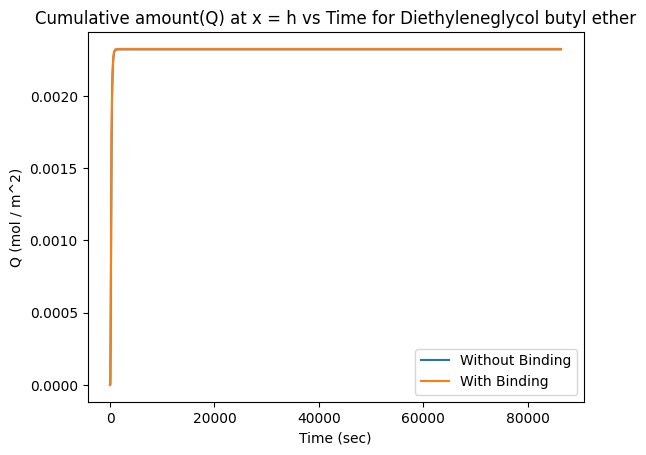

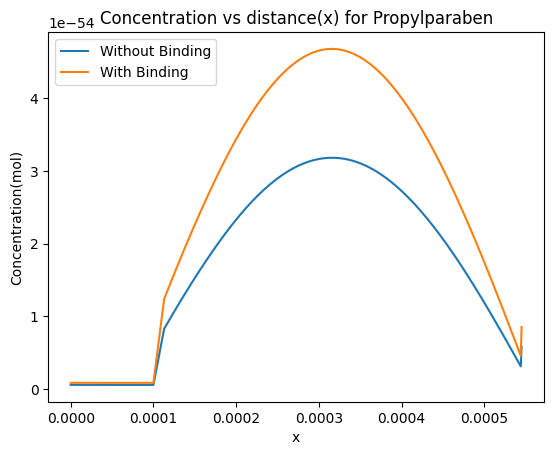

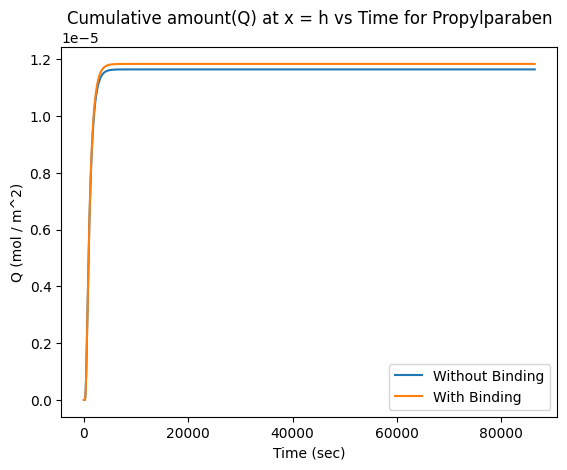

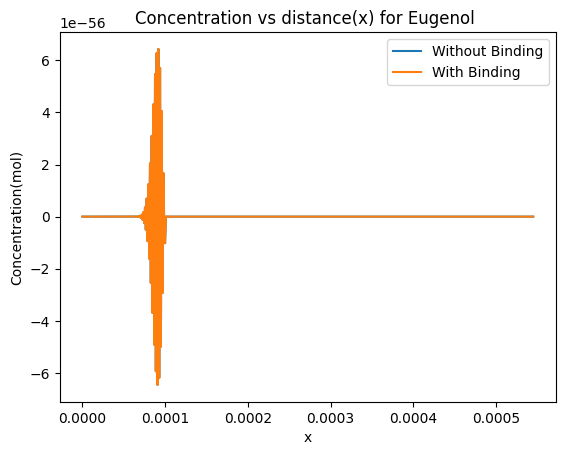

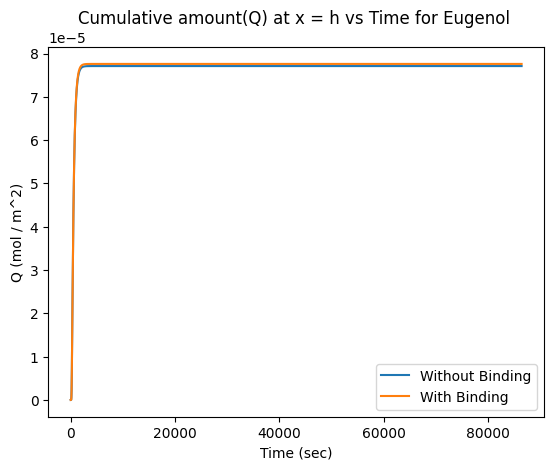

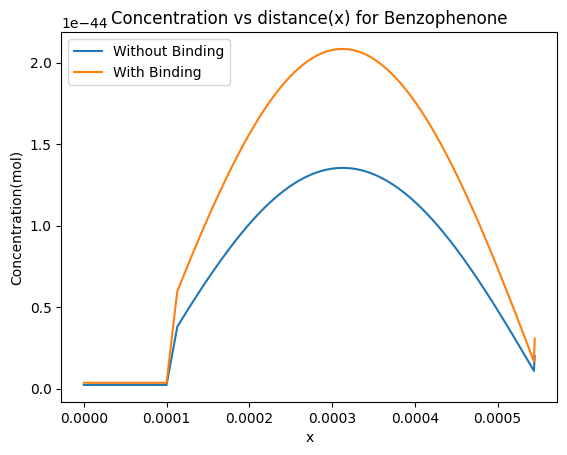

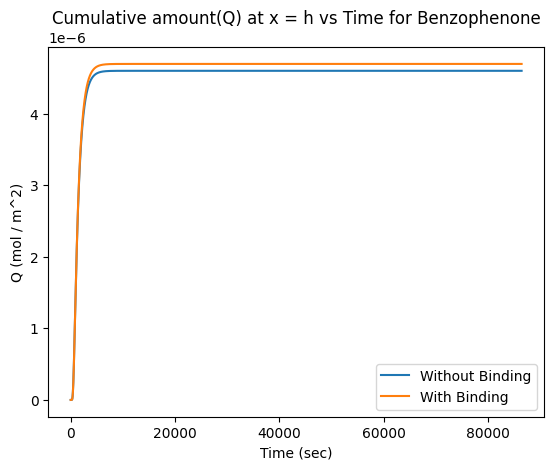

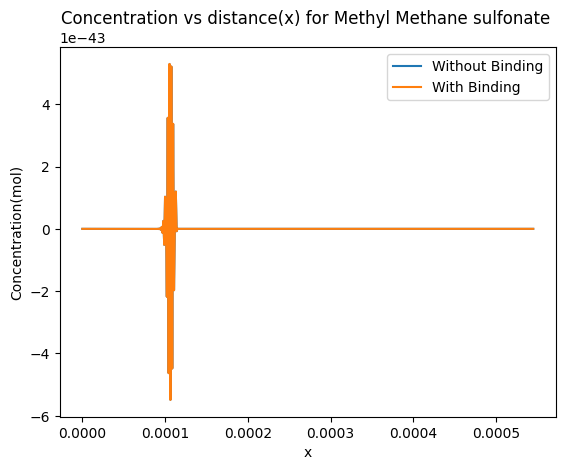

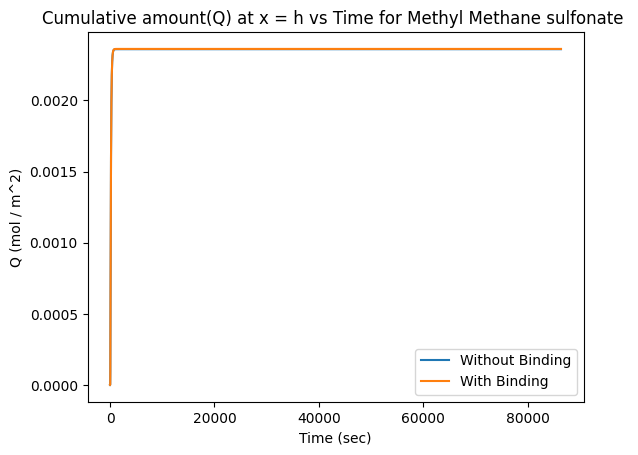

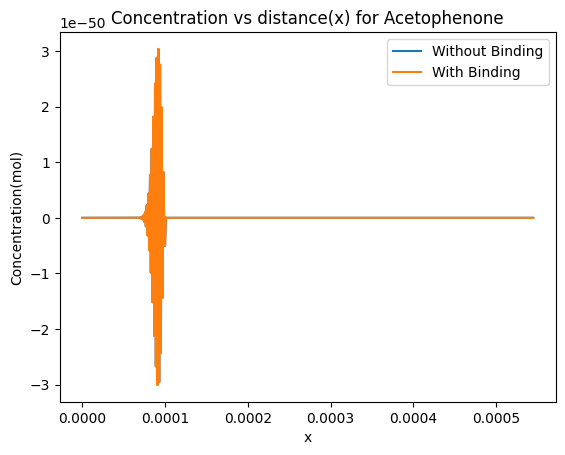

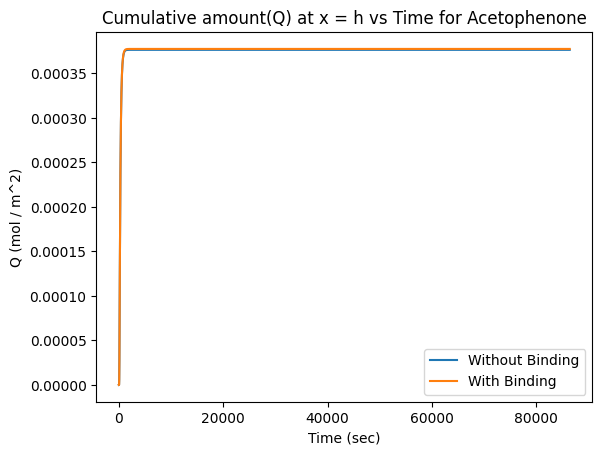

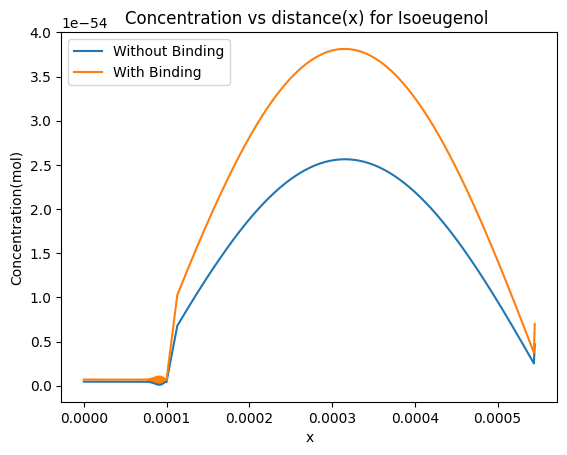

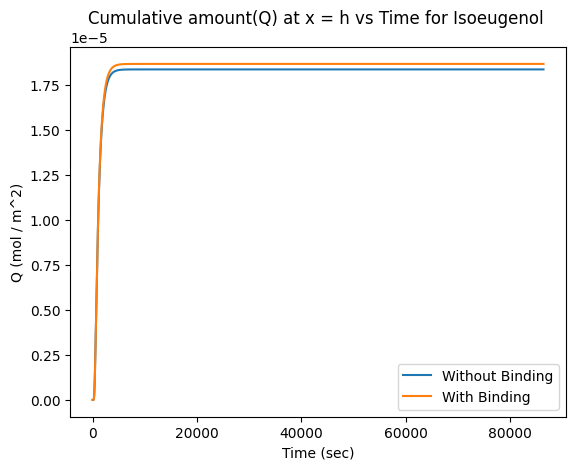

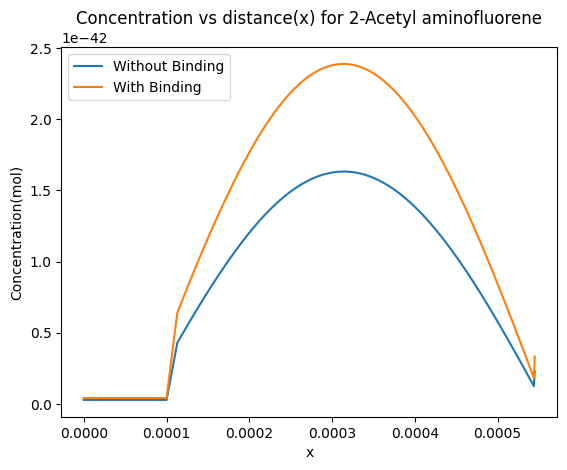

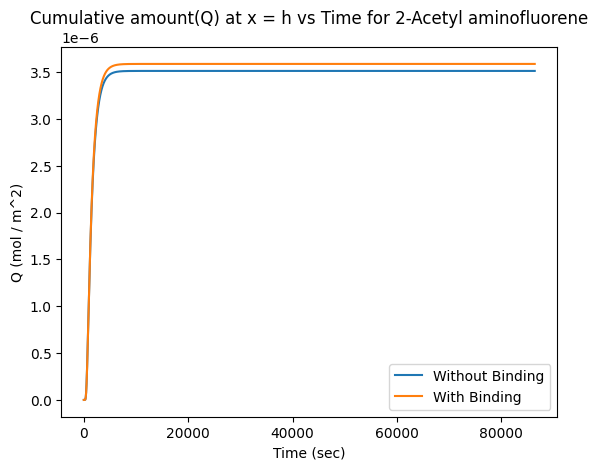

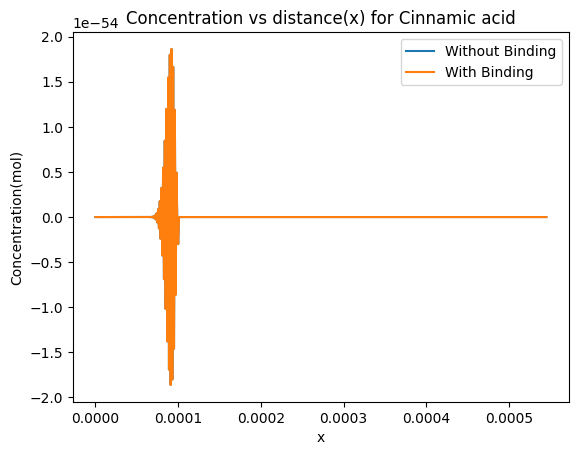

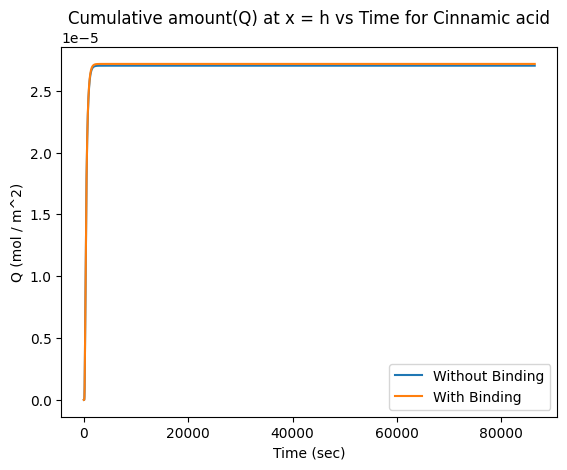

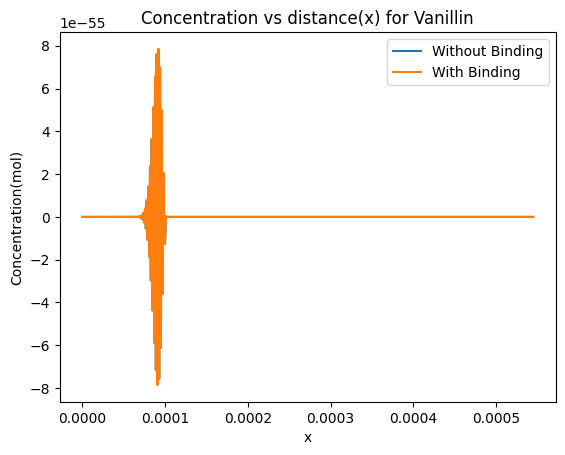

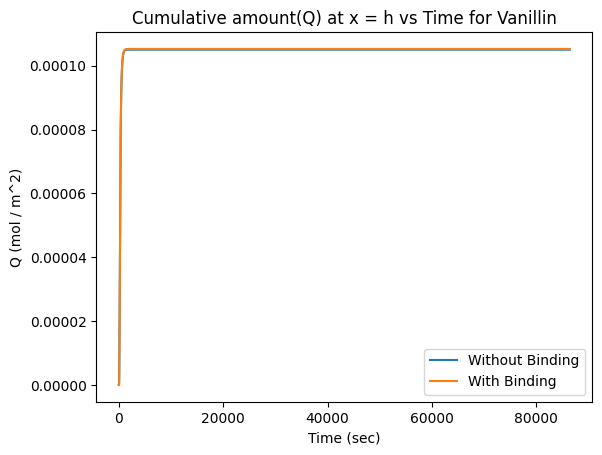

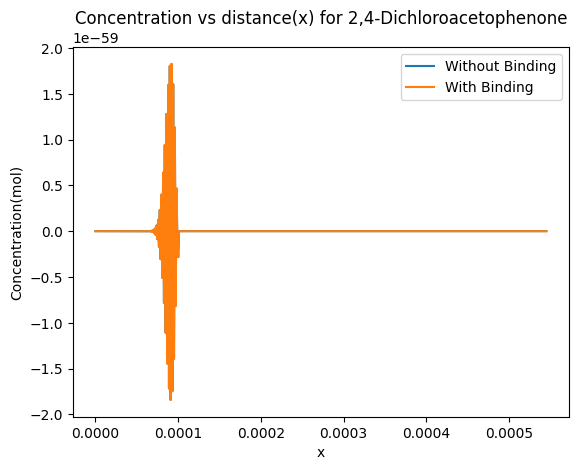

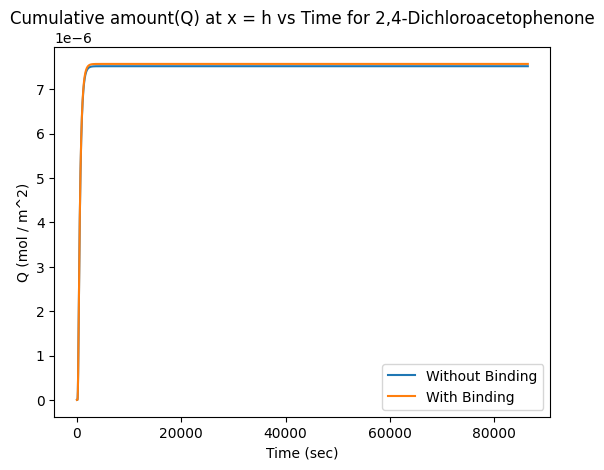

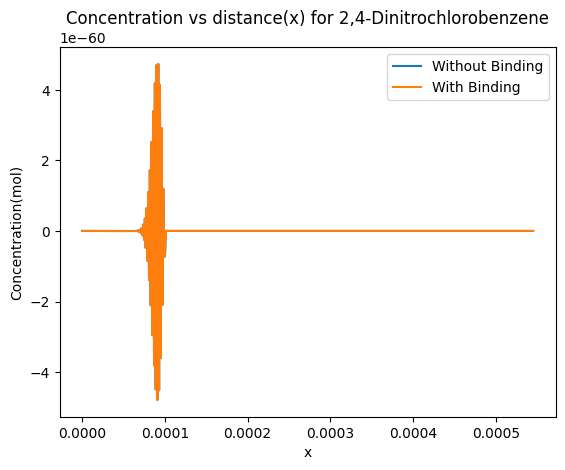

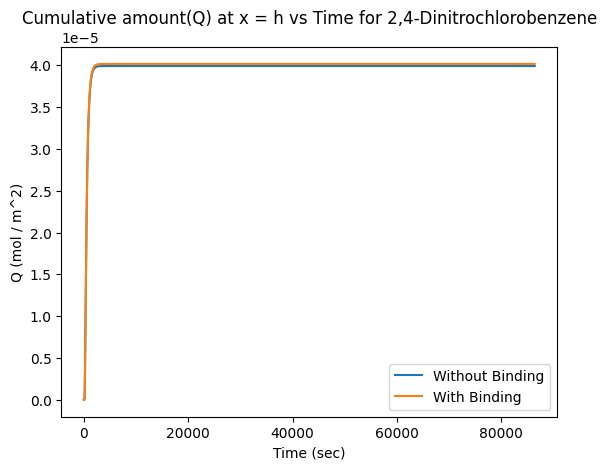

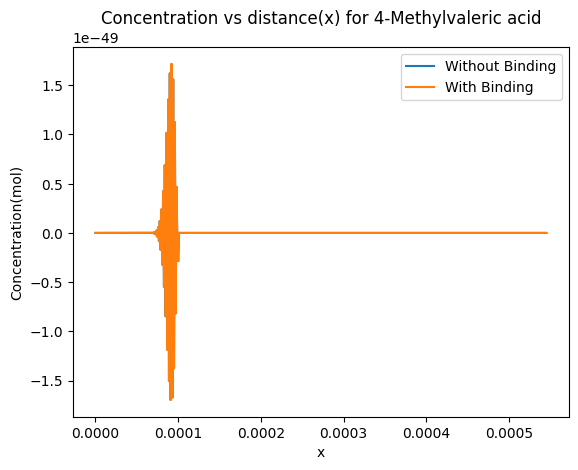

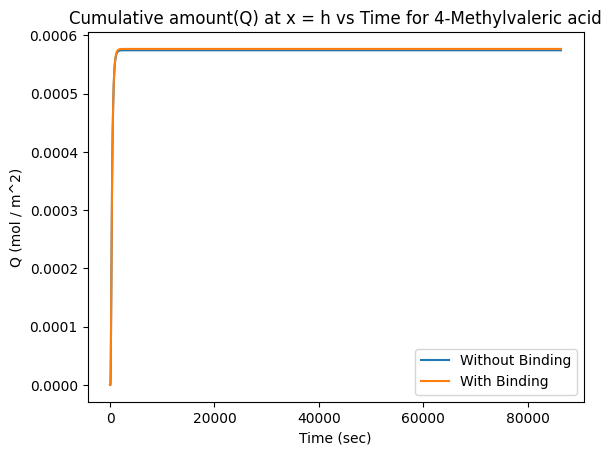

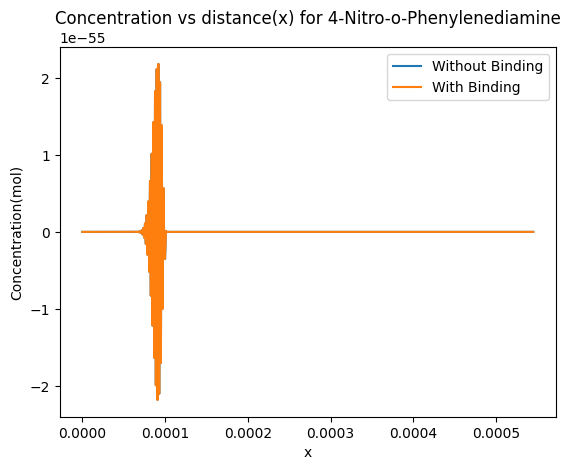

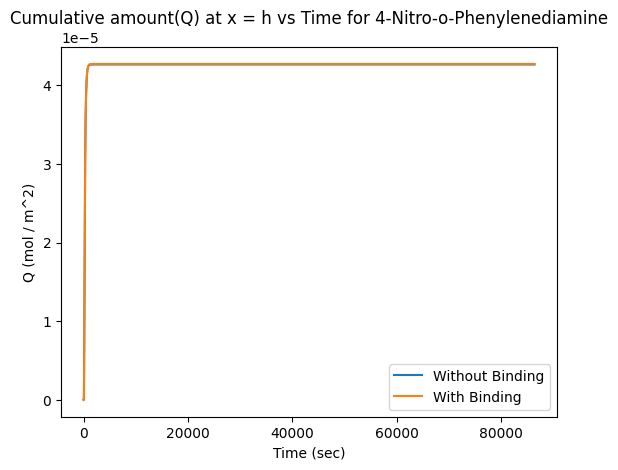

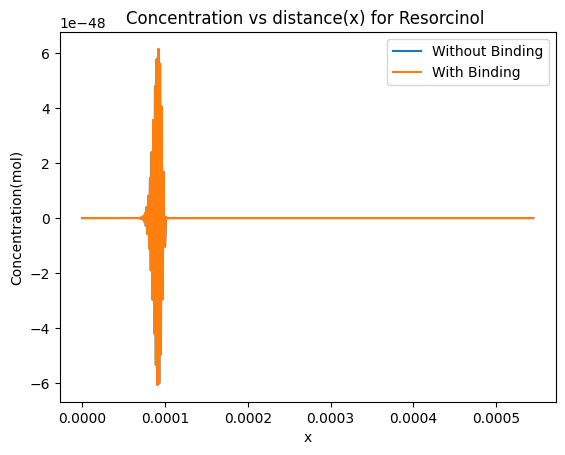

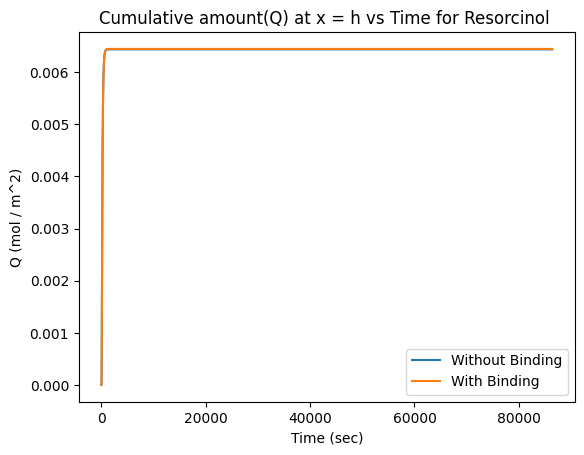

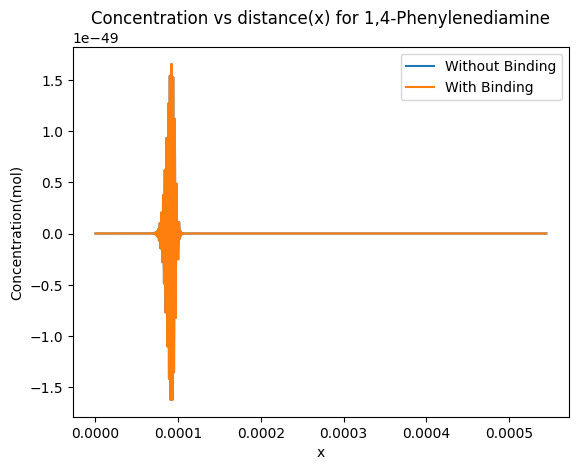

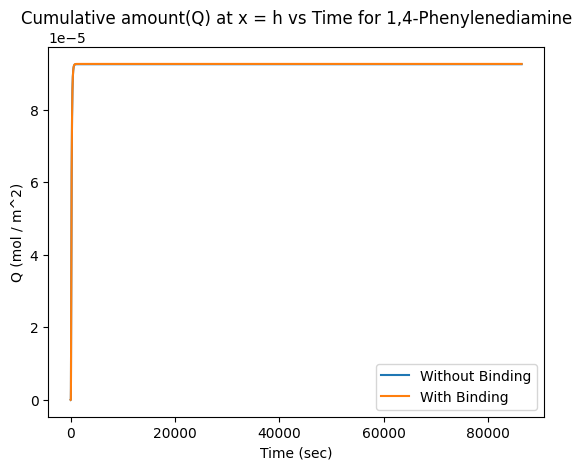

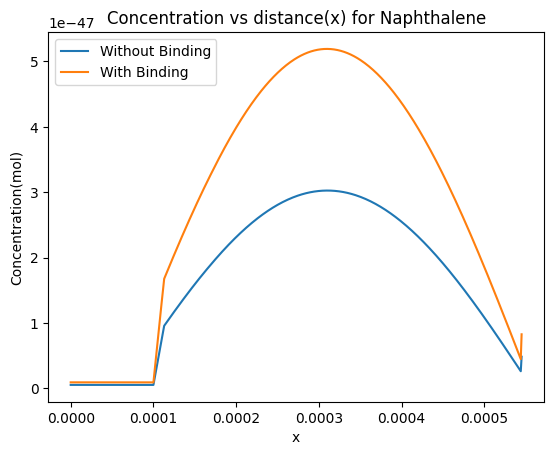

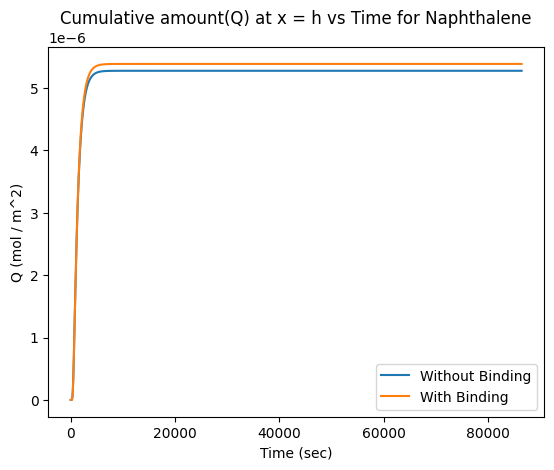

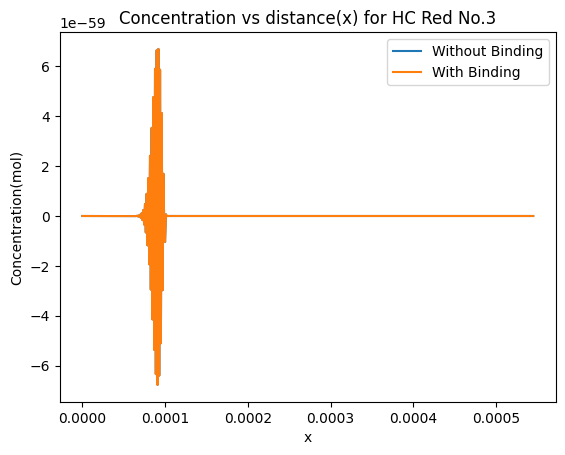

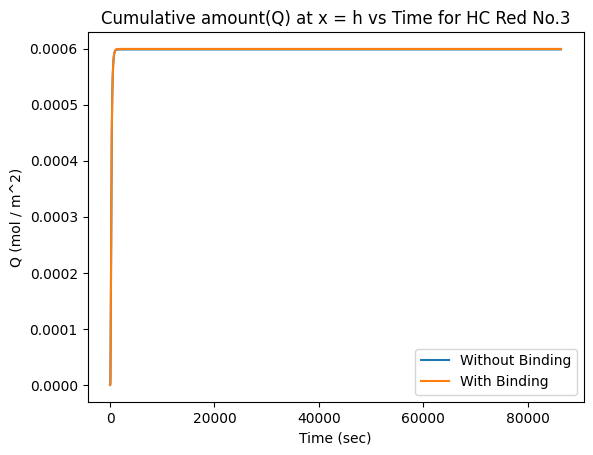

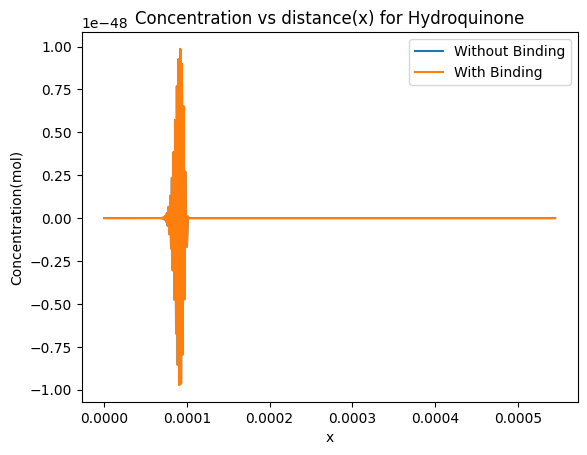

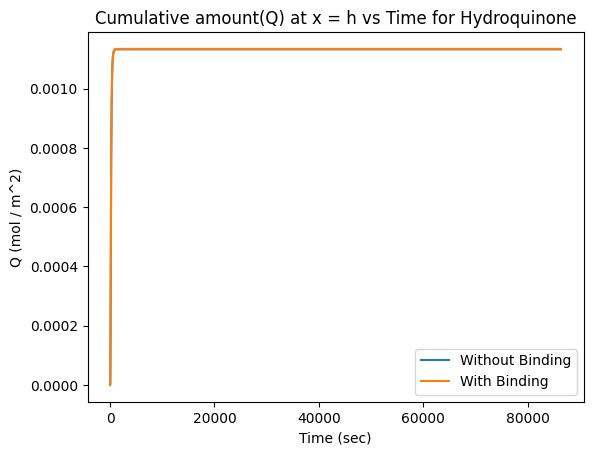

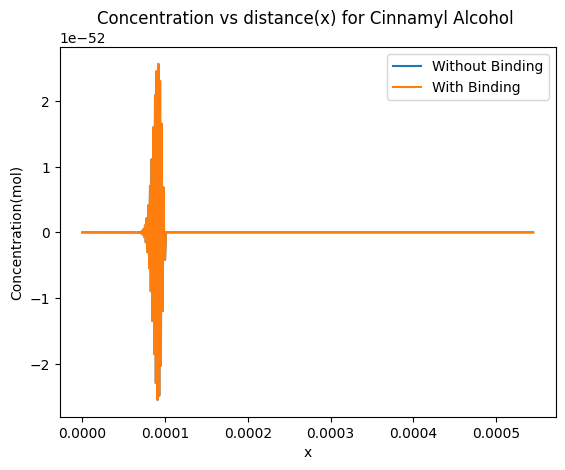

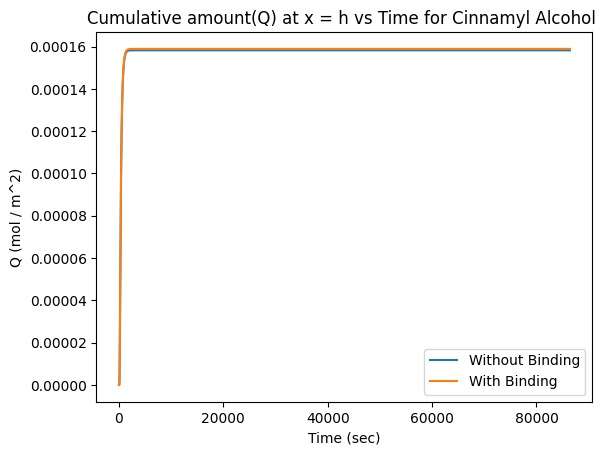

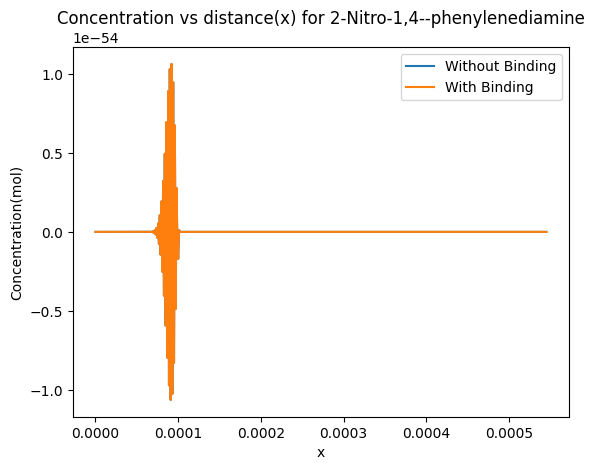

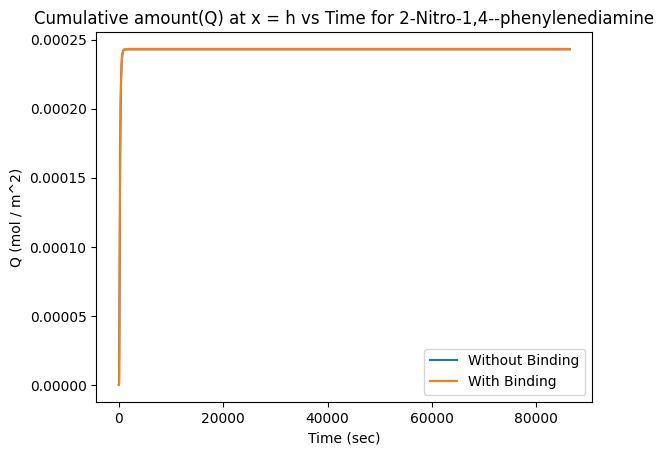

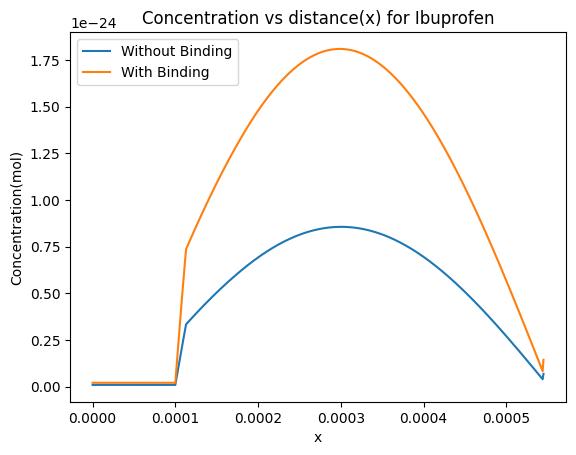

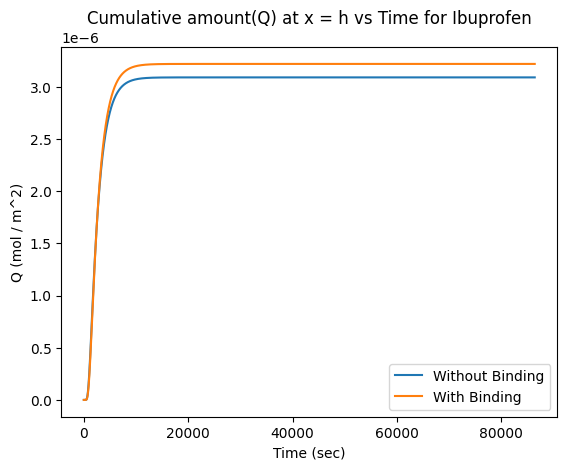

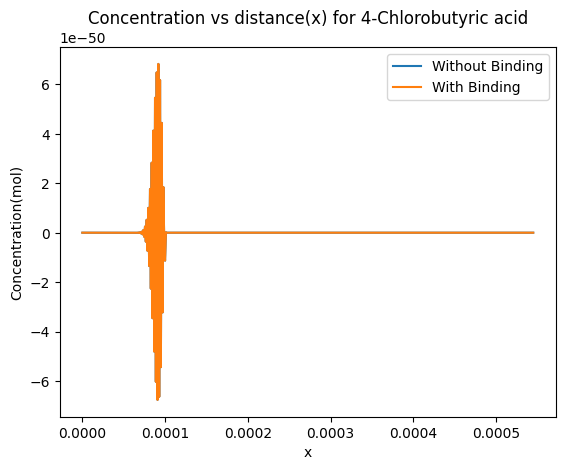

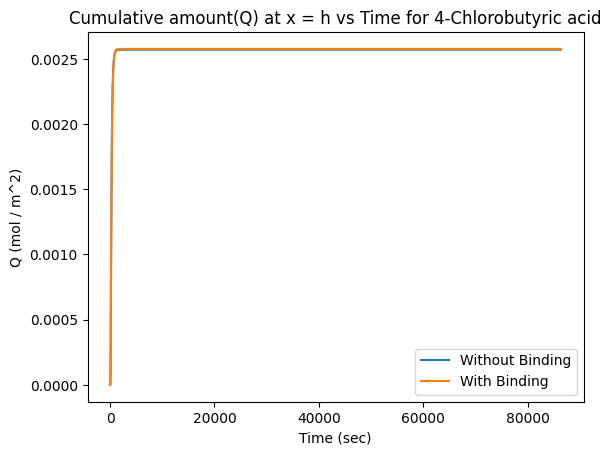

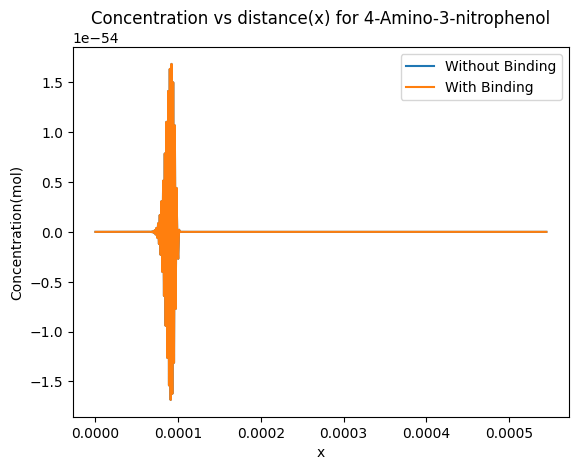

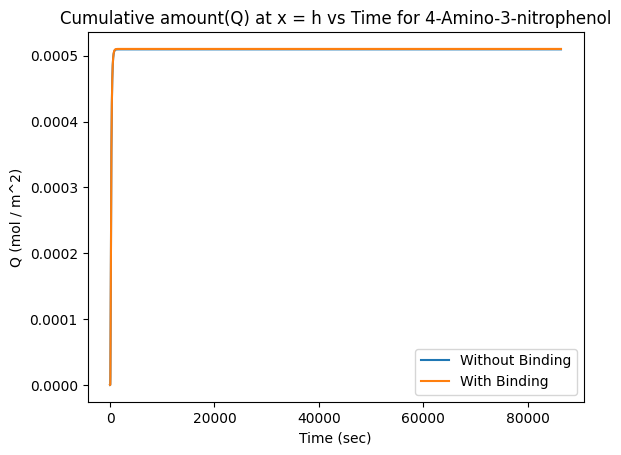

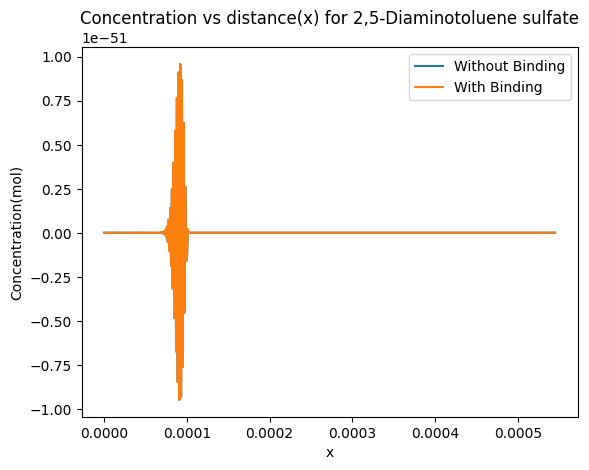

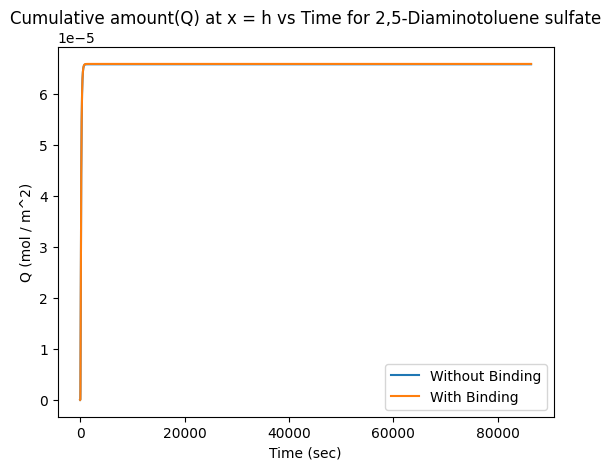

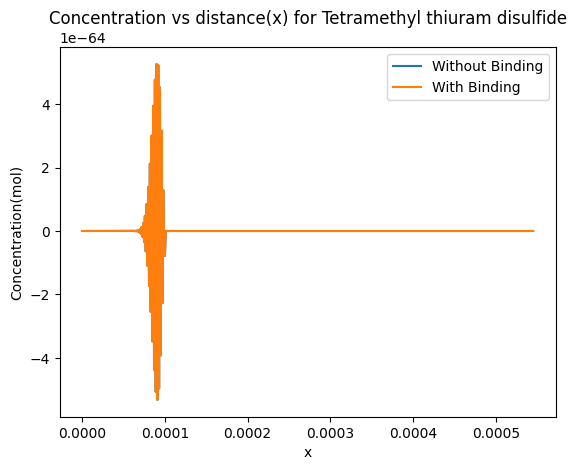

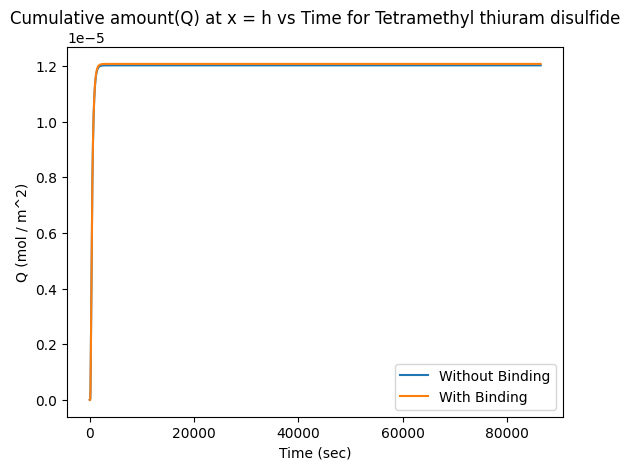

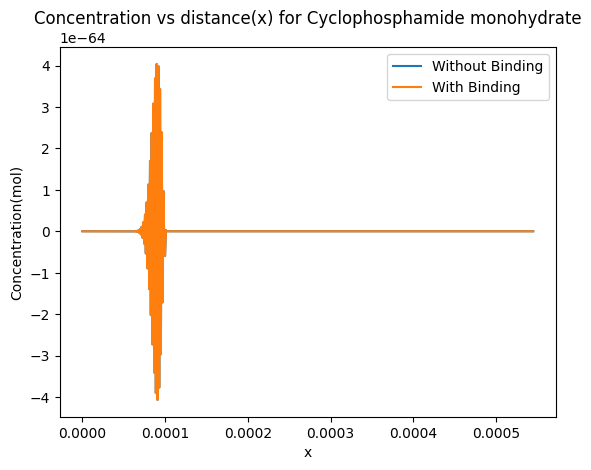

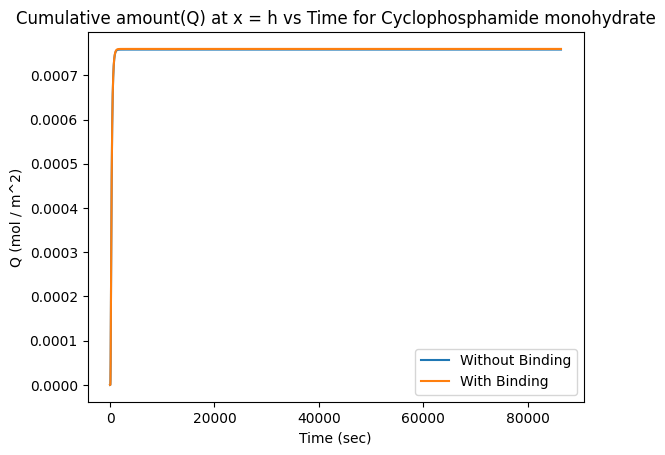

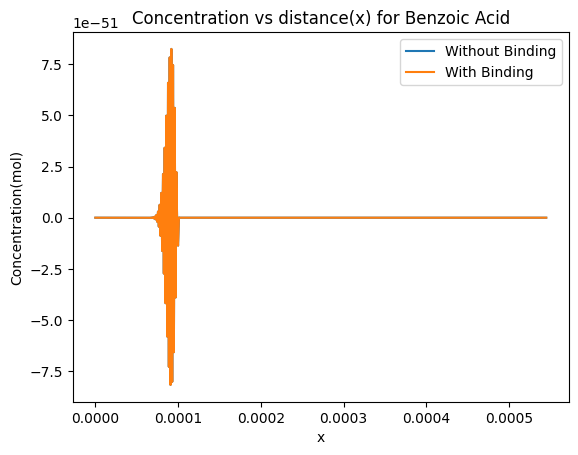

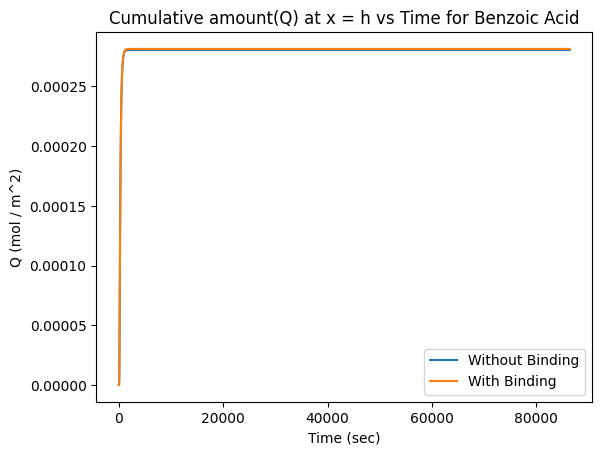

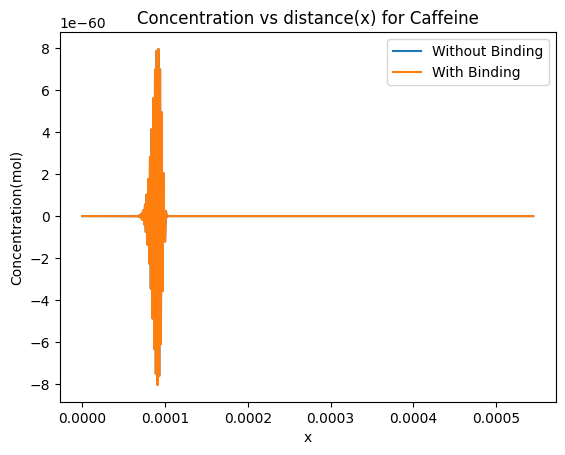

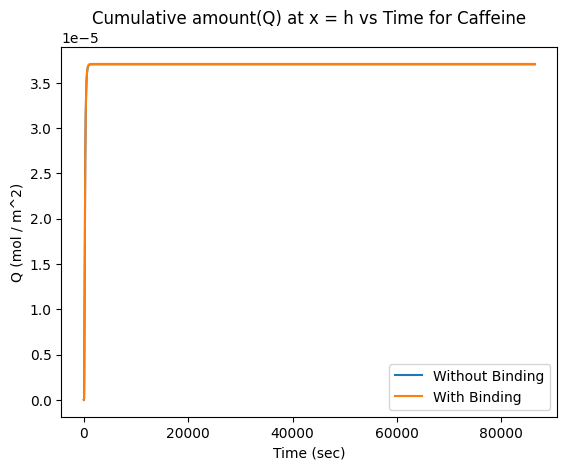

In [ ]:
## Combined code for plot
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import pandas as pd
import time

start = time.time()

data = pd.read_csv('data_all_aa.csv')
data_new_wo = data.rename(columns={'CAS No.':'CAS','D_lip(m2/s)':'D_lip','aqueous_solubility(g/l)':'aqueous_solubility','VP\n@32C (torr)':'VP',
                                'Dose applied (ug/cm2)':'Dose','conc(mol/m3)':'conc','D_w(m2/s)':'D_w','D_cor(m2/s)':'D_cor','D_epi(m2/s)':'D_epi',
                                'kevap*rho/csat (m/s)':'k_evap_rho_by_Csat','D_sc(m2/s)':'D_SC'})

data_new_w = pd.read_csv('new_com_data.csv')

con_res_data_wo = pd.DataFrame()
con_res_data_w = pd.DataFrame()
bind_res_data = pd.DataFrame()
flux_res_data_wo = pd.DataFrame()
flux_res_data_w = pd.DataFrame()

for molecule in range(0,43):
    # Parameters
    L_veh, L_SC, L_epi, L_dermis = 100e-6, 13.0e-6, 57e-6, 375e-6   # Thickness of SC in m
    D_veh = data_new_wo.D_w[molecule] #9.35e-10  # Diffusion coefficient in m2/s
    D_lip = data_new_wo.D_lip[molecule]#2.74e-10
    D_cor = data_new_wo.D_cor[molecule]#2.57e-11
    D_epi = data_new_wo.D_epi[molecule]#2.34e-10 #2.34e-10 # in m2/s
    D_dermis = D_epi # m2/s

    K_SC_veh = data_new_wo.K_SC[molecule]#37.22
    K_lip_veh = data_new_wo.K_lip[molecule]#597
    K_cor_veh = data_new_wo.K_cor[molecule]#18.944
    K_epi_SC = data_new_wo.K_epi[molecule]/K_SC_veh
    K_dermis_epi = 1
    k_f, k_r = data_new_w.k_off[molecule], data_new_w.k_on[molecule]

    L_total = L_veh+L_SC+L_epi+L_dermis
    c0 = 0 #np.sin(np.pi * x_SC) # in mol/m3
    c1 = data_new_wo.conc[molecule]#3.579 # concentration at top
    c2 = 0 # concentration at bottom


    # Geometrical parameters
    omega, dia, thick, g, s =  1, 40e-6, 0.8e-6, 75e-9, 75e-9
     # The offset ratio,# Diameter of the Corneocytes,# Thickness of the Corneocytes,
     # Vertical spacing between corneocytes, # Lateral spacing between corneocytes
    no_cor_layers = 15


    l_cor = dia
    l_lip = g
    D_SC = (l_cor+l_lip)/((l_lip/D_lip)+(l_cor*K_lip_veh/(K_cor_veh*D_cor)))

    # Spacial grids
    N_veh, N_SC, N_epi, N_dermis = 100, 13, 57, 375
    dx_veh = L_veh/ (N_veh-1)
    dx_SC = L_SC/ (N_SC-1)
    dx_epi = L_epi/(N_epi-1)
    dx_dermis = L_dermis/(N_dermis-1)

    # Evaporative constants
    k_evap_rho_by_Csat = data_new_wo.k_evap_rho_by_Csat[molecule] #6.95e-19
    evap_const = k_evap_rho_by_Csat*dx_veh/D_veh

    # Create grid
    x_veh = np.linspace(0,L_veh,N_veh)
    x_SC = np.linspace(L_veh, L_veh+L_SC, N_SC)
    x_epi = np.linspace(L_veh+L_SC, L_veh+L_SC+L_epi, N_epi)
    x_dermis = np.linspace(L_veh+L_SC+L_epi, L_veh+L_SC+L_epi+L_dermis, N_dermis)

    x = np.append(x_veh,x_SC[1:])
    x = np.append(x[:-1],x_epi)
    x = np.append(x[:-1],x_dermis)

    if molecule == 0:
        bind_res_data['Distance(x)'] = pd.Series(x_SC)
        con_res_data_wo['Distance(x)'] = pd.Series(x)
        con_res_data_w['Distance(x)'] = pd.Series(x)

    # Time stepping parameters
    T = 24*3600
    M = 100_000
    dt = T/ M
    nu = 1/2 # 1/2 for CN, 0 for explicit and 1 for full implicit
    # matrix constants
    r_veh = D_veh*dt/(2*dx_veh**2)
    r_SC = D_SC*dt/(2*dx_SC**2)
    lab_1 = D_SC*dt/(2*dx_SC**2)
    lab_2 = 0.5*k_f*dt
    lab_3 = 0.5*k_r*dt
    r_epi = D_epi*dt/(2*dx_epi**2)
    r_dermis = D_dermis*dt/(2*dx_dermis**2)

    # # Allocate solution array
    # u_veh = np.zeros((M, N_veh))
    # u_SC = np.zeros((M, N_SC))

    # Construct the tridiagonal matrix A, B for layers

    A_veh = np.diagflat([-r_veh for i in range(N_veh-1)],-1)\
            +np.diagflat([1+r_veh]+[(1+2*r_veh) for i in range(N_veh-2)]+[1+r_veh],0)\
            +np.diagflat([-r_veh for i in range(N_veh-1)],1)
    B_veh = np.diagflat([r_veh for i in range(N_veh-1)],-1)\
            +np.diagflat([1-r_veh]+[(1-2*r_veh) for i in range(N_veh-2)]+[1-r_veh],0)\
            +np.diagflat([r_veh for i in range(N_veh-1)],1)

    A_SC_wo = np.diagflat([-r_SC for i in range(N_SC-1)],-1)\
            +np.diagflat([1+r_SC]+[(1+2*r_SC) for i in range(N_SC-2)]+[1+r_SC],0)\
            +np.diagflat([-r_SC for i in range(N_SC-1)],1)
    B_SC_wo = np.diagflat([r_SC for i in range(N_SC-1)],-1)\
            +np.diagflat([1-r_SC]+[(1-2*r_SC) for i in range(N_SC-2)]+[1-r_SC],0)\
            +np.diagflat([r_SC for i in range(N_SC-1)],1)

    A_SC_w = np.diagflat([-r_SC for i in range(N_SC-1)],-1)\
            +np.diagflat([1+lab_1+(lab_2/(1+lab_3))]+[(1+2*lab_1+(lab_2/(1+lab_3))) for i in range(N_SC-2)]+[1+lab_1+(lab_2/(1+lab_3))],0)\
            +np.diagflat([-r_SC for i in range(N_SC-1)],1)
    B_SC_w = np.diagflat([r_SC for i in range(N_SC-1)],-1)\
            +np.diagflat([1-lab_1-(lab_2/(1+lab_3))]+[(1-2*lab_1-(lab_2/(1+lab_3))) for i in range(N_SC-2)]+[1-lab_1-(lab_2/(1+lab_3))],0)\
            +np.diagflat([r_SC for i in range(N_SC-1)],1)

    A_epi = np.diagflat([-r_epi for i in range(N_epi-1)],-1)\
            +np.diagflat([1+r_epi]+[(1+(2*r_epi)) for i in range(N_epi-2)]+[1+r_epi],0)\
            +np.diagflat([-r_epi for i in range(N_epi-1)],1)
    B_epi = np.diagflat([r_epi for i in range(N_epi-1)],-1)\
            +np.diagflat([1-r_epi]+[(1-(2*r_epi)) for i in range(N_epi-2)]+[1-r_epi],0)\
            +np.diagflat([r_epi for i in range(N_epi-1)],1)

    A_dermis = np.diagflat([-r_dermis for i in range(N_dermis-1)],-1)\
            +np.diagflat([1+r_dermis]+[(1+(2*r_dermis)) for i in range(N_dermis-2)]+[1+r_dermis],0)\
            +np.diagflat([-r_dermis for i in range(N_dermis-1)],1)
    B_dermis = np.diagflat([r_dermis for i in range(N_dermis-1)],-1)\
            +np.diagflat([1-r_dermis]+[(1-(2*r_dermis)) for i in range(N_dermis-2)]+[1-r_dermis],0)\
            +np.diagflat([r_dermis for i in range(N_dermis-1)],1)

    # Global tridiagonal matrix A, B
    N_total = N_veh+N_SC+N_epi+N_dermis

    A_wo = np.zeros((N_total-3,N_total-3))
    B_wo = np.zeros((N_total-3,N_total-3))

    A_w = np.zeros((N_total-3,N_total-3))
    B_w = np.zeros((N_total-3,N_total-3))

    A_wo[0:N_veh,0:N_veh] = A_veh
    B_wo[0:N_veh,0:N_veh] = B_veh

    A_wo[N_veh-1:N_veh+N_SC-1,N_veh-1:N_veh+N_SC-1] = A_SC_wo
    B_wo[N_veh-1:N_veh+N_SC-1,N_veh-1:N_veh+N_SC-1] = B_SC_wo

    A_wo[N_veh+N_SC-2:N_veh+N_SC+N_epi-2,N_veh+N_SC-2:N_veh+N_SC+N_epi-2] = A_epi
    B_wo[N_veh+N_SC-2:N_veh+N_SC+N_epi-2,N_veh+N_SC-2:N_veh+N_SC+N_epi-2] = B_epi

    A_wo[N_veh+N_SC+N_epi-3:N_veh+N_SC+N_epi+N_dermis-3,N_veh+N_SC+N_epi-3:N_veh+N_SC+N_epi+N_dermis-3] = A_dermis
    B_wo[N_veh+N_SC+N_epi-3:N_veh+N_SC+N_epi+N_dermis-3,N_veh+N_SC+N_epi-3:N_veh+N_SC+N_epi+N_dermis-3] = B_dermis

    A_w[0:N_veh,0:N_veh] = A_veh
    B_w[0:N_veh,0:N_veh] = B_veh

    A_w[N_veh-1:N_veh+N_SC-1,N_veh-1:N_veh+N_SC-1] = A_SC_w
    B_w[N_veh-1:N_veh+N_SC-1,N_veh-1:N_veh+N_SC-1] = B_SC_w

    A_w[N_veh+N_SC-2:N_veh+N_SC+N_epi-2,N_veh+N_SC-2:N_veh+N_SC+N_epi-2] = A_epi
    B_w[N_veh+N_SC-2:N_veh+N_SC+N_epi-2,N_veh+N_SC-2:N_veh+N_SC+N_epi-2] = B_epi

    A_w[N_veh+N_SC+N_epi-3:N_veh+N_SC+N_epi+N_dermis-3,N_veh+N_SC+N_epi-3:N_veh+N_SC+N_epi+N_dermis-3] = A_dermis
    B_w[N_veh+N_SC+N_epi-3:N_veh+N_SC+N_epi+N_dermis-3,N_veh+N_SC+N_epi-3:N_veh+N_SC+N_epi+N_dermis-3] = B_dermis

    # Interace BC
    alpha_veh_SC = (D_veh*dx_SC)+(D_SC*K_SC_veh*dx_veh)
    alpha_SC_epi = (D_SC*dx_epi)+(D_epi*K_epi_SC*dx_SC)
    alpha_epi_dermis = (D_epi*dx_dermis)+(D_dermis*K_dermis_epi*dx_epi)

    # at veh-SC interface
    A_wo[N_veh-1][N_veh-3]=((-r_veh*(2*D_veh*dx_SC+3*D_SC*K_SC_veh*dx_veh))+(r_SC*D_veh*K_SC_veh*dx_SC))/alpha_veh_SC

    A_wo[N_veh-1][N_veh-2]=((r_veh*(2*D_veh*dx_SC+6*D_SC*K_SC_veh*dx_veh))-(r_SC*4*D_veh*K_SC_veh*dx_SC))/alpha_veh_SC

    A_wo[N_veh-1][N_veh-1] = 1

    A_wo[N_veh-1][N_veh]=((-r_veh*4*D_SC*dx_veh)+(r_SC*(6*D_veh*dx_SC+2*D_SC*K_SC_veh*dx_veh)))/alpha_veh_SC

    A_wo[N_veh-1][N_veh+1]=((r_veh*D_SC*dx_veh)-(r_SC*(3*D_veh*dx_SC+2*D_SC*K_SC_veh*dx_veh)))/alpha_veh_SC

    B_wo[N_veh-1][N_veh-3]=((r_veh*(2*D_veh*dx_SC+3*D_SC*K_SC_veh*dx_veh))-(r_SC*D_veh*K_SC_veh*dx_SC))/alpha_veh_SC

    B_wo[N_veh-1][N_veh-2]=((-r_veh*(2*D_veh*dx_SC+6*D_SC*K_SC_veh*dx_veh))+(r_SC*4*D_veh*K_SC_veh*dx_SC))/alpha_veh_SC

    B_wo[N_veh-1][N_veh-1] = 1

    B_wo[N_veh-1][N_veh]=((r_veh*4*D_SC*dx_veh)-(r_SC*(6*D_veh*dx_SC+2*D_SC*K_SC_veh*dx_veh)))/alpha_veh_SC

    B_wo[N_veh-1][N_veh+1]=((-r_veh*D_SC*dx_veh)+(r_SC*(3*D_veh*dx_SC+2*D_SC*K_SC_veh*dx_veh)))/alpha_veh_SC

    # at SC-epi interface
    A_wo[N_veh+N_SC-2][N_veh+N_SC-4]=((-r_SC*(2*D_SC*dx_epi+3*D_epi*K_epi_SC*dx_SC))+(r_epi*D_SC*K_epi_SC*dx_epi))/alpha_SC_epi

    A_wo[N_veh+N_SC-2][N_veh+N_SC-3]=((r_SC*(2*D_SC*dx_epi+6*D_epi*K_epi_SC*dx_SC))-(r_epi*4*D_SC*K_epi_SC*dx_epi))/alpha_SC_epi

    A_wo[N_veh+N_SC-2][N_veh+N_SC-2] = 1

    A_wo[N_veh+N_SC-2][N_veh+N_SC-1]=((-r_SC*4*D_epi*dx_SC)+(r_epi*(6*D_SC*dx_epi+2*D_epi*K_epi_SC*dx_SC)))/alpha_SC_epi

    A_wo[N_veh+N_SC-2][N_veh+N_SC]=((r_SC*D_epi*dx_SC)-(r_epi*(3*D_SC*dx_epi+2*D_epi*K_epi_SC*dx_SC)))/alpha_SC_epi

    B_wo[N_veh+N_SC-2][N_veh+N_SC-4]=((r_SC*(2*D_SC*dx_epi+3*D_epi*K_epi_SC*dx_SC))-(r_epi*D_SC*K_epi_SC*dx_epi))/alpha_SC_epi

    B_wo[N_veh+N_SC-2][N_veh+N_SC-3]=((-r_SC*(2*D_SC*dx_epi+6*D_epi*K_epi_SC*dx_SC))+(r_epi*4*D_SC*K_epi_SC*dx_epi))/alpha_SC_epi

    B_wo[N_veh+N_SC-2][N_veh+N_SC-2] = 1

    B_wo[N_veh+N_SC-2][N_veh+N_SC-1]=((r_SC*4*D_epi*dx_SC)-(r_epi*(6*D_SC*dx_epi+2*D_epi*K_epi_SC*dx_SC)))/alpha_SC_epi

    B_wo[N_veh+N_SC-2][N_veh+N_SC]=((-r_SC*D_epi*dx_SC)+(r_epi*(3*D_SC*dx_epi+2*D_epi*K_epi_SC*dx_SC)))/alpha_SC_epi

    # at epi-dermis interface
    A_wo[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-5]=((-r_epi*(2*D_epi*dx_dermis+3*D_dermis*K_dermis_epi*dx_epi))+(r_dermis*D_epi*K_dermis_epi*dx_dermis))/alpha_epi_dermis

    A_wo[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-4]=((r_epi*(2*D_epi*dx_dermis+6*D_dermis*K_dermis_epi*dx_epi))-(r_dermis*4*D_epi*K_dermis_epi*dx_dermis))/alpha_epi_dermis

    A_wo[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-3] = 1

    A_wo[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-2]=((-r_epi*4*D_dermis*dx_epi)+(r_dermis*(6*D_epi*dx_dermis+2*D_dermis*K_dermis_epi*dx_epi)))/alpha_epi_dermis

    A_wo[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-1]=((r_epi*D_dermis*dx_epi)-(r_dermis*(3*D_epi*dx_dermis+2*D_dermis*K_dermis_epi*dx_epi)))/alpha_epi_dermis

    B_wo[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-5]=((r_epi*(2*D_epi*dx_dermis+3*D_dermis*K_dermis_epi*dx_epi))-(r_dermis*D_epi*K_dermis_epi*dx_dermis))/alpha_epi_dermis

    B_wo[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-4]=((-r_epi*(2*D_epi*dx_dermis+6*D_dermis*K_dermis_epi*dx_epi))+(r_dermis*4*D_epi*K_dermis_epi*dx_dermis))/alpha_epi_dermis

    B_wo[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-3] = 1

    B_wo[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-2]=((r_epi*4*D_dermis*dx_epi)-(r_dermis*(6*D_epi*dx_dermis+2*D_dermis*K_dermis_epi*dx_epi)))/alpha_epi_dermis

    B_wo[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-1]=((-r_epi*D_dermis*dx_epi)+(r_dermis*(3*D_epi*dx_dermis+2*D_dermis*K_dermis_epi*dx_epi)))/alpha_epi_dermis


    # at veh-SC interface
    A_w[N_veh-1][N_veh-3]=((-r_veh*(2*D_veh*dx_SC+3*D_SC*K_SC_veh*dx_veh))+(r_SC*D_veh*K_SC_veh*dx_SC))/alpha_veh_SC

    A_w[N_veh-1][N_veh-2]=((r_veh*(2*D_veh*dx_SC+6*D_SC*K_SC_veh*dx_veh))-(r_SC*4*D_veh*K_SC_veh*dx_SC))/alpha_veh_SC

    A_w[N_veh-1][N_veh-1] = 1

    A_w[N_veh-1][N_veh]=((-r_veh*4*D_SC*dx_veh)+(r_SC*(6*D_veh*dx_SC+2*D_SC*K_SC_veh*dx_veh)))/alpha_veh_SC

    A_w[N_veh-1][N_veh+1]=((r_veh*D_SC*dx_veh)-(r_SC*(3*D_veh*dx_SC+2*D_SC*K_SC_veh*dx_veh)))/alpha_veh_SC

    B_w[N_veh-1][N_veh-3]=((r_veh*(2*D_veh*dx_SC+3*D_SC*K_SC_veh*dx_veh))-(r_SC*D_veh*K_SC_veh*dx_SC))/alpha_veh_SC

    B_w[N_veh-1][N_veh-2]=((-r_veh*(2*D_veh*dx_SC+6*D_SC*K_SC_veh*dx_veh))+(r_SC*4*D_veh*K_SC_veh*dx_SC))/alpha_veh_SC

    B_w[N_veh-1][N_veh-1] = 1

    B_w[N_veh-1][N_veh]=((r_veh*4*D_SC*dx_veh)-(r_SC*(6*D_veh*dx_SC+2*D_SC*K_SC_veh*dx_veh)))/alpha_veh_SC

    B_w[N_veh-1][N_veh+1]=((-r_veh*D_SC*dx_veh)+(r_SC*(3*D_veh*dx_SC+2*D_SC*K_SC_veh*dx_veh)))/alpha_veh_SC

    # at SC-epi interface
    A_w[N_veh+N_SC-2][N_veh+N_SC-4]=((-r_SC*(2*D_SC*dx_epi+3*D_epi*K_epi_SC*dx_SC))+(r_epi*D_SC*K_epi_SC*dx_epi))/alpha_SC_epi

    A_w[N_veh+N_SC-2][N_veh+N_SC-3]=((r_SC*(2*D_SC*dx_epi+6*D_epi*K_epi_SC*dx_SC))-(r_epi*4*D_SC*K_epi_SC*dx_epi))/alpha_SC_epi

    A_w[N_veh+N_SC-2][N_veh+N_SC-2] = 1

    A_w[N_veh+N_SC-2][N_veh+N_SC-1]=((-r_SC*4*D_epi*dx_SC)+(r_epi*(6*D_SC*dx_epi+2*D_epi*K_epi_SC*dx_SC)))/alpha_SC_epi

    A_w[N_veh+N_SC-2][N_veh+N_SC]=((r_SC*D_epi*dx_SC)-(r_epi*(3*D_SC*dx_epi+2*D_epi*K_epi_SC*dx_SC)))/alpha_SC_epi

    B_w[N_veh+N_SC-2][N_veh+N_SC-4]=((r_SC*(2*D_SC*dx_epi+3*D_epi*K_epi_SC*dx_SC))-(r_epi*D_SC*K_epi_SC*dx_epi))/alpha_SC_epi

    B_w[N_veh+N_SC-2][N_veh+N_SC-3]=((-r_SC*(2*D_SC*dx_epi+6*D_epi*K_epi_SC*dx_SC))+(r_epi*4*D_SC*K_epi_SC*dx_epi))/alpha_SC_epi

    B_w[N_veh+N_SC-2][N_veh+N_SC-2] = 1

    B_w[N_veh+N_SC-2][N_veh+N_SC-1]=((r_SC*4*D_epi*dx_SC)-(r_epi*(6*D_SC*dx_epi+2*D_epi*K_epi_SC*dx_SC)))/alpha_SC_epi

    B_w[N_veh+N_SC-2][N_veh+N_SC]=((-r_SC*D_epi*dx_SC)+(r_epi*(3*D_SC*dx_epi+2*D_epi*K_epi_SC*dx_SC)))/alpha_SC_epi

    # at epi-dermis interface
    A_w[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-5]=((-r_epi*(2*D_epi*dx_dermis+3*D_dermis*K_dermis_epi*dx_epi))+(r_dermis*D_epi*K_dermis_epi*dx_dermis))/alpha_epi_dermis

    A_w[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-4]=((r_epi*(2*D_epi*dx_dermis+6*D_dermis*K_dermis_epi*dx_epi))-(r_dermis*4*D_epi*K_dermis_epi*dx_dermis))/alpha_epi_dermis

    A_w[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-3] = 1

    A_w[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-2]=((-r_epi*4*D_dermis*dx_epi)+(r_dermis*(6*D_epi*dx_dermis+2*D_dermis*K_dermis_epi*dx_epi)))/alpha_epi_dermis

    A_w[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-1]=((r_epi*D_dermis*dx_epi)-(r_dermis*(3*D_epi*dx_dermis+2*D_dermis*K_dermis_epi*dx_epi)))/alpha_epi_dermis

    B_w[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-5]=((r_epi*(2*D_epi*dx_dermis+3*D_dermis*K_dermis_epi*dx_epi))-(r_dermis*D_epi*K_dermis_epi*dx_dermis))/alpha_epi_dermis

    B_w[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-4]=((-r_epi*(2*D_epi*dx_dermis+6*D_dermis*K_dermis_epi*dx_epi))+(r_dermis*4*D_epi*K_dermis_epi*dx_dermis))/alpha_epi_dermis

    B_w[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-3] = 1

    B_w[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-2]=((r_epi*4*D_dermis*dx_epi)-(r_dermis*(6*D_epi*dx_dermis+2*D_dermis*K_dermis_epi*dx_epi)))/alpha_epi_dermis

    B_w[N_veh+N_SC+N_epi-3][N_veh+N_SC+N_epi-1]=((-r_epi*D_dermis*dx_epi)+(r_dermis*(3*D_epi*dx_dermis+2*D_dermis*K_dermis_epi*dx_epi)))/alpha_epi_dermis

    # Global solution array
    c_wo = np.zeros((M,N_total-3))
    c_w = np.zeros((M,N_total-3))
    bind = np.zeros((M, N_SC))

    # Set initial condition
    c_wo[0, :] = c0
    c_w[0, :] = c0
    #u_SC[0, 0] = 10

    c_wo[0, :N_veh-1] = c1
    A_wo = csr_matrix(A_wo)

    c_w[0, :N_veh-1] = c1
    A_w = csr_matrix(A_w)

    # Time stepping loop
    for k in range(1, M):
        # Boundary conditions
        #c[k-1,0:1] = c1 # uncomment to account for Infinite dose
        c_wo[k-1,0:1] = c_wo[k-1,1:2]*(1/(1+evap_const))
        c_w[k-1,0:1] = c_w[k-1,1:2]*(1/(1+evap_const))
        c_wo[k-1,-1:] = c2
        c_w[k-1,-1:] = c2
        # Solve the linear system of equations
        #b = np.dot(A, u[k - 1, :])
        b_wo = np.dot(B_wo, c_wo[k - 1, :])
        c_wo[k, :] = spsolve(A_wo, b_wo)
        b_w = np.dot(B_w, c_w[k - 1, :])
        b_w[N_veh-1:N_veh+N_SC-1] += (2*lab_3/(1+lab_3)) * bind[k-1, :]
        c_w[k, :] = spsolve(A_w, b_w)
        bind[k, :] = ((1-lab_3)*bind[k-1,:] + lab_2 * (c_w[k-1, N_veh-1:N_veh+N_SC-1] + c_w[k, N_veh-1:N_veh+N_SC-1]))/(1+lab_3)

    con_res_data_wo[data_new_wo.Compounds[molecule]] = pd.Series(c_wo[-1, :])
    con_res_data_w[data_new_wo.Compounds[molecule]] = pd.Series(c_w[-1, :])
    bind_res_data[data_new_wo.Compounds[molecule]] = pd.Series(bind[-1, :])

    #c[-1,0] = c1 # setting top concentaration to infinte dose
    # Analytical solution for 26e-6 thickness
    #analytical = pd.read_table('Analytical.txt',header=None)
    # cumulative release 1D diffusion - Numerical result
    conc_gradient_wo = []
    conc_gradient_w = []

    t = np.linspace(0,T,M)
    if molecule == 0:
        flux_res_data_wo['Time (sec)'] = pd.Series(t)
        flux_res_data_w['Time (sec)'] = pd.Series(t)

    #for i in range(no_steps):
    for i in range(M):
        conc_plot_wo = c_wo[i,:]
        conc_gradient_temp_wo = (conc_plot_wo[-1]-conc_plot_wo[-2])/(x[-1]-x[-2])
        conc_gradient_wo.append(conc_gradient_temp_wo)
        conc_plot_w = c_w[i,:]
        conc_gradient_temp_w = (conc_plot_w[-1]-conc_plot_w[-2])/(x[-1]-x[-2])
        conc_gradient_w.append(conc_gradient_temp_w)

    Flux_wo = [-D_dermis*i for i in conc_gradient_wo]
    Flux_w = [-D_dermis*i for i in conc_gradient_w]

    Q1_wo = np.cumsum(Flux_wo) * dt
    Q1_w = np.cumsum(Flux_w) * dt

    flux_res_data_wo[data_new_wo.Compounds[molecule]] = pd.Series(Q1_wo)
    flux_res_data_w[data_new_wo.Compounds[molecule]] = pd.Series(Q1_w)

    # Plotting the concentration at different location over the time interval
    plt.figure()
    plt.plot(x, c_wo[-1, :],label='Without Binding')
    plt.plot(x, c_w[-1, :],label='With Binding')
    plt.xlabel('x')
    plt.ylabel('Concentration(mol)')
    plt.title('Concentration vs distance(x) for ' + data_new_wo.Compounds[molecule])
    plt.legend()
    # plt.savefig('plot_RF/' + data_new_wo.Compounds[molecule]+' Concentration vs distance(x)')
    # plt.show()

    # Plotting the Accumulated vs time
    plt.figure()
    plt.plot(t, Q1_wo, label='Without Binding')
    plt.plot(t, Q1_w, label='With Binding')
    plt.xlabel('Time (sec)')
    plt.ylabel('Q (mol / m^2)')
    plt.title('Cumulative amount(Q) at x = h vs Time for ' + data_new_wo.Compounds[molecule])
    plt.legend()
    # plt.savefig('plot_RF/' + data_new_wo.Compounds[molecule]+' Cumulative amount vs time')
    # plt.show()
end = time.time()
print(end - start)

In [ ]:
bind_res_data

,Distance(x),2-aminophenol
0,0.000100,6.571073e-322
1,0.000101,6.571073e-322
2,0.000102,6.571073e-322
3,0.000103,6.571073e-322
4,0.000104,6.571073e-322
5,0.000105,6.571073e-322
6,0.000107,6.571073e-322
7,0.000108,6.571073e-322
8,0.000109,6.571073e-322
9,0.000110,6.571073e-322


Sure, I can explain Michaelis-Menten (M.M.) kinetics and its relation to metabolism in the epidermis of human skin.

### Michaelis-Menten Kinetics

**Michaelis-Menten kinetics** describes the rate of enzymatic reactions by relating the reaction rate to the concentration of a substrate. This model is widely used to understand enzyme behavior and is characterized by two main parameters:

1. **\( V_{\max} \)**: The maximum rate of the reaction when the enzyme is saturated with the substrate.
2. **\( K_m \)**: The Michaelis constant, representing the substrate concentration at which the reaction rate is half of \( V_{\max} \). It provides an indication of the enzyme's affinity for the substrate; a lower \( K_m \) indicates a higher affinity.

The Michaelis-Menten equation is given by:

\[ v = \frac{V_{\max} [S]}{K_m + [S]} \]

where:
- \( v \) is the initial reaction rate,
- \( [S] \) is the substrate concentration.

### Steps of Michaelis-Menten Kinetics

1. **Formation of the Enzyme-Substrate Complex**: The substrate (S) binds to the enzyme (E) to form the enzyme-substrate complex (ES).
2. **Formation of Product**: The ES complex either converts to the product (P) or dissociates back to the enzyme and substrate.

### Relevance to Metabolism in the Epidermis

**Metabolism in the epidermis** of the human skin involves various enzymatic reactions critical for maintaining skin health and function. These reactions include:

- **Keratinization**: The process where keratinocytes produce keratin, a key protein providing structural strength to the skin.
- **Lipid Metabolism**: The synthesis and breakdown of lipids, essential for maintaining the skin barrier and hydration.
- **Detoxification**: Enzymatic breakdown of potentially harmful substances that come in contact with the skin.

### Michaelis-Menten Kinetics in Epidermal Metabolism

The enzymes in the epidermis follow Michaelis-Menten kinetics, ensuring efficient processing of substrates (e.g., nutrients, lipids, toxins) under varying conditions. For instance:

1. **Skin Barrier Function**: Enzymes involved in lipid metabolism in the stratum corneum (outermost layer) maintain the lipid barrier, crucial for preventing water loss and protecting against external agents.
2. **Detoxification Enzymes**: Enzymes like cytochrome P450 oxidize xenobiotics (foreign substances), making them more water-soluble for excretion. The kinetics of these enzymes help determine the rate at which the skin can detoxify and respond to exposure.
3. **Repair and Renewal**: Enzymatic processes involved in cell turnover and repair operate efficiently thanks to Michaelis-Menten kinetics, ensuring a balance between cell death and regeneration.

### Practical Implications

Understanding Michaelis-Menten kinetics in the context of skin metabolism can have several practical applications, such as:

- **Drug Development**: Designing topical treatments that target specific enzymes with known $( K_m $) and $( V_{\max} $) values for optimal efficacy.
- **Skin Care Products**: Formulating products that support or inhibit particular enzymatic activities to improve skin health.
- **Disease Treatment**: Identifying metabolic imbalances in conditions like psoriasis or eczema and developing targeted therapies.

### Conclusion

Michaelis-Menten kinetics provides a fundamental framework for understanding the rate and efficiency of enzymatic reactions in the epidermis, influencing various metabolic processes crucial for skin health. By applying this knowledge, we can develop better therapeutic and cosmetic interventions to maintain and enhance skin function.

The Michaelis-Menten equation is derived from a model of enzyme kinetics proposed by Leonor Michaelis and Maud Menten in 1913. The derivation involves several steps and assumptions, particularly the steady-state assumption, which assumes that the concentration of the enzyme-substrate complex (ES) remains constant over the time course of the reaction. Here’s a step-by-step derivation:

### Step-by-Step Derivation

#### 1. The Basic Reaction Model

The enzyme-catalyzed reaction can be described by the following steps:

1. The enzyme \( E \) binds to the substrate \( S \) to form the enzyme-substrate complex \( ES \).
2. The enzyme-substrate complex can either dissociate back into the enzyme and substrate or proceed to form the product \( P \), releasing the enzyme.

The reactions are:

\[ E + S \xrightleftharpoons[k_{-1}]{k_1} ES \xrightarrow{k_2} E + P \]

where:
- \( k_1 \) is the rate constant for the formation of \( ES \),
- \( k_{-1} \) is the rate constant for the dissociation of \( ES \) back into \( E \) and \( S \),
- \( k_2 \) is the rate constant for the formation of the product \( P \).

#### 2. The Rate of Formation and Breakdown of \( ES \)

The rate of formation of the enzyme-substrate complex \( ES \) is given by:

\[ \text{Rate of formation} = k_1 [E][S] \]

The rate of breakdown of the enzyme-substrate complex \( ES \) is the sum of the rates of its dissociation back into \( E \) and \( S \), and the formation of the product \( P \):

\[ \text{Rate of breakdown} = k_{-1} [ES] + k_2 [ES] = (k_{-1} + k_2) [ES] \]

#### 3. The Steady-State Assumption

According to the steady-state assumption, the concentration of \( ES \) remains constant over time. Therefore, the rate of formation of \( ES \) is equal to the rate of its breakdown:

\[ k_1 [E][S] = (k_{-1} + k_2) [ES] \]

#### 4. Expressing [E] in Terms of Total Enzyme Concentration

The total enzyme concentration \( [E_{\text{total}}] \) is the sum of the free enzyme \( [E] \) and the enzyme-substrate complex \( [ES] \):

\[ [E_{\text{total}}] = [E] + [ES] \]

Solving for \( [E] \):

\[ [E] = [E_{\text{total}}] - [ES] \]

#### 5. Substituting [E] into the Steady-State Equation

Substitute \( [E] \) into the steady-state equation:

\[ k_1 ([E_{\text{total}}] - [ES]) [S] = (k_{-1} + k_2) [ES] \]

Rearrange to solve for \( [ES] \):

\[ k_1 [E_{\text{total}}] [S] - k_1 [ES] [S] = (k_{-1} + k_2) [ES] \]

\[ k_1 [E_{\text{total}}] [S] = [ES] (k_{-1} + k_2 + k_1 [S]) \]

\[ [ES] = \frac{k_1 [E_{\text{total}}] [S]}{k_{-1} + k_2 + k_1 [S]} \]

#### 6. Defining the Michaelis Constant \( K_m \)

Define the Michaelis constant \( K_m \) as:

\[ K_m = \frac{k_{-1} + k_2}{k_1} \]

So,

\[ [ES] = \frac{[E_{\text{total}}] [S]}{K_m + [S]} \]

#### 7. Rate of Product Formation

The rate of product formation \( v \) is given by the rate constant \( k_2 \) times the concentration of the enzyme-substrate complex \( [ES] \):

\[ v = k_2 [ES] \]

Substitute \( [ES] \):

\[ v = k_2 \left( \frac{[E_{\text{total}}] [S]}{K_m + [S]} \right) \]

#### 8. Defining \( V_{\max} \)

The maximum rate \( V_{\max} \) occurs when all the enzyme is in the enzyme-substrate complex form, i.e., \( [E_{\text{total}}] \):

\[ V_{\max} = k_2 [E_{\text{total}}] \]

So, the equation becomes:

\[ v = \frac{V_{\max} [S]}{K_m + [S]} \]

### The Michaelis-Menten Equation

The final Michaelis-Menten equation is:

\[ v = \frac{V_{\max} [S]}{K_m + [S]} \]

This equation describes how the rate of the reaction depends on the substrate concentration, the maximum reaction rate, and the Michaelis constant.

### Relevance to Metabolism in the Epidermis

Enzymes in the epidermis, like in other tissues, follow Michaelis-Menten kinetics. This understanding helps in:

- Predicting how changes in substrate concentration (e.g., lipids, nutrients) affect the metabolic rate.
- Designing treatments that optimize enzyme activity for desired metabolic outcomes.
- Understanding pathological conditions where enzyme kinetics may be altered, leading to skin disorders.

By understanding Michaelis-Menten kinetics, researchers and clinicians can better understand and manipulate metabolic processes in the skin for therapeutic and cosmetic purposes.

In [ ]:
#  Partitioning, diffusivity and clearance of skin permeants in
#  mammalian dermis
#  Kosmas Kretsos1, Matthew A. Miller, Grettel Zamora-Estrada, Gerald B. Kasting∗
#  Table1
#  PhysicochemicalpropertiesandestimatedpartitioncoefficientsKde,diffusivitiesDdeandpermeabilitiesPde indermisofstudiedcompounds

data = {
    "Compound": ["Water", "Methanol", "Ethanol", "Propanol", "Butanol", "Pentanol", "Hexanol", "Heptanol", "Octanol", "Decanol", "Betamethasone", "Betamethasone 17-valerate", "Methoxsalen", "Glucose", "Testosterone"],
    "MW (Da)": [18.0, 32.0, 46.1, 60.1, 74.1, 88.2, 102.2, 116.2, 130.2, 158.2, 392.5, 476.6, 216.2, 180.2, 288.4],
    "VA (cm3/mol)": [21.0, 42.0, 63.0, 84.0, 105.0, 126.0, 147.0, 168.0, 189.0, 231.0, 423.5, 528.5, 203.0, 161.0, 350.0],
    "log Koct": [-1.38, -0.77, -0.31, 0.25, 0.88, 1.56, 2.03, 2.72, 3.00, 4.06, 2.01, 3.60, 1.93, -3.24, 3.32],
    "fu sol": [None, 0.878, 0.764, 0.40, None, None, 0.09, None, None, None, None, None, None, None, None],
    "Kde": [0.7, 0.55, 0.43, 0.43, 0.43, 0.61, 0.86, 1.75, 3.55, 11.3, 2.5, 13.6, 1.45, 0.65, 4.92],
    "Dde x 10^7 (cm^2/s)": [60, 67, 57, 50, 48, 27, 16, 9.9, 5.1, None, 7.4, 1.6, 7.64, 26.4, 4.1],
    "Pde x 10^7 (cm^2/s)": [41.7, 36.8, 24.3, 21.5, 20.8, 16.7, 13.9, 17.4, 18.1, None, 18.5, 21.8, 11.1, 12.8, 25.4],
    "Species": ["Human"] * 15,
    "Ref.": ["g", "g", "g,h", "g", "g,h", "g", "g,h", "g", "g,h", "h", "i", "i", "j", "k", "-"]
}

# Create a DataFrame
df = pd.DataFrame(data)

In [ ]:
#  Table2
#  Invivostudiesofskinconcentrationsoftopicallyappliedpermeants

data_2 = {
    "Permeant": ["Hydrocortisone"],
    "Species/site": ["Human"],
    "n": [1],
    "Time (min)": [1000],
    "ln C0": [-7.01],
    "E (cm^-1)": ["43.0 ± 3.9"],
    "Dde x 10^7 (cm^2/s)": [7.7],
    "kde x 10^4 (s^-1)": [14.2],
    "kfree x 10^4 (s^-1)": [16.6],
    "Ref.": ["c"]
}

# Create a DataFrame for the second table
df_2 = pd.DataFrame(data_2)

In [ ]:
#  Table4
#  Calculatedfractionsunbound,bindingfactors,partitioncoefficientsKde,diffusivitiesDdeandpermeabilitiesPde indermisofstudiedcompounds

data_3 = {
    "Compound": ["Water", "Methanol", "Ethanol", "Propanol", "Butanol", "Pentanol", "Hexanol", "Heptanol", "Octanol", "Decanol",
                 "Betamethasone", "Betamethasone 17-valerate", "Methoxsalen", "Glucose", "Testosterone", "Hydrocortisone",
                 "Salicylic acid", "Didanosine", "Pentanol", "Vidarabine", "Vidarabine", "Hypoxanthine arabinoside",
                 "Vidarabine-5-n-valerate", "Progesterone", "Desoxycorticosterone", "11-a-Hydroxyprogesterone",
                 "17-a-Hydroxyprogesterone", "Corticosterone", "17-a-Hydroxydeoxy-corticosterone", "Hydrocortisone", "Piroxicam"],
    "fu": [0.863, 0.783, 0.700, 0.576, 0.423, 0.272, 0.190, 0.105, 0.082, 0.030, 0.193, 0.047, 0.206, 0.961, 0.061, 0.263,
           0.113, 0.950, 0.272, 0.832, 0.832, 0.931, 0.364, 0.036, 0.091, 0.144, 0.070, 0.204, 0.076, 0.263, 0.143],
    "Binding factor (Eq. (20))": [1.05, 1.09, 1.14, 1.24, 1.44, 1.89, 2.47, 4.24, 5.59, 22.84, 2.44, 11.52, 2.32, 1.01, 8.03, 1.94,
                                  3.51, 1.02, 1.89, 1.06, 1.06, 1.02, 1.57, 16.98, 4.94, 3.13, 6.73, 2.34, 6.09, 1.94, 2.92],
    "Kde/pH7.4 (Eqs. (13) and (20))": [0.63, 0.65, 0.68, 0.74, 0.87, 1.14, 1.48, 2.54, 3.35, 13.70, 1.46, 6.91, 1.39, 0.61, 4.82, 1.16,
                                       2.10, 0.61, 1.14, 0.64, 0.64, 0.61, 0.94, 10.19, 2.97, 1.88, 4.04, 1.40, 3.66, 1.16, 1.75],
    "Dfree x 10^7 (cm^2/s; Eq. (21))": [106.6, 73.1, 57.6, 48.4, 42.2, 37.6, 34.2, 31.4, 29.2, 25.7, 14.2, 12.5, 20.9, 23.6, 17.3, 14.9,
                                        28.1, 19.7, 37.6, 18.2, 18.2, 18.2, 15.2, 16.4, 15.8, 15.8, 15.8, 15.4, 15.4, 14.9, 15.8],
    "Pde x 10^7 (cm^2/s; Eq. (15))": [64.0, 43.9, 34.5, 29.0, 25.3, 22.6, 20.5, 18.9, 17.5, 15.4, 8.5, 7.5, 12.6, 14.1, 10.4, 8.9,
                                      16.8, 11.8, 22.6, 10.9, 10.9, 10.9, 9.1, 9.8, 9.5, 9.5, 9.5, 9.2, 9.2, 8.9, 9.5]
}

# Create a DataFrame for the third table
df_3 = pd.DataFrame(data_3)

In [ ]:
# Computational Prediction of the Plasma Protein-Binding
#  Percent of Diverse Pharmaceutical Compounds
#  KAZUTO YAMAZAKI, MASAHARU KANAOKA
# Table1. NeutralandBasicCompoundsUsedfortheQSPRAnalysis
# Manually organizing the extracted text into a structured list for the fourth table
data_4_complete = {
    "Compound": ["Alprazolam", "Alprenolol", "Amidopyrine", "Amiodarone", "Amitriptyline", "Aprindine", "Astemizole",
                 "Atenolol", "Atropine", "Bisoprolol", "Brotizolam", "Bupivacaine", "Caffeine", "Chlordiazepoxide",
                 "Chlormethiazole", "Chloroquine", "Chlorpheniramine", "Chlorpromazine", "Clonidine", "Cyclophosphamide",
                 "Dapsone", "Desipramine", "Dextropropoxyphene", "Diazepam", "Diltiazem", "Diphenhydramine", "Disopyramide",
                 "Encainide", "Esmolol"],
    "CAS RN": ["28981-97-7", "13655-52-2", "58-15-1", "1951-25-3", "50-48-6", "37640-71-4", "68844-77-9", "29122-68-7",
               "51-55-8", "66722-44-9", "57801-81-7", "38396-39-3", "58-08-2", "58-25-3", "533-45-9", "54-05-7", "113-92-8",
               "50-53-3", "4205-90-7", "50-18-0", "80-08-0", "50-47-5", "469-62-5", "439-14-5", "33286-22-5", "58-73-1",
               "3737-09-5", "66778-36-7", "103598-03-4"],
    "PBR": [70, 76, 30, 96, 95, 96, 97, 3, 50, 30, 90, 96, 35, 96, 64, 55, 72, 98, 20, 13, 73, 80, 78, 98, 98, 99, 54, 75, 56],
    "LogD (pH 0)": [-0.25, -6.28, -5.56, -0.78, -3.09, -10.31, -10.01, -9.17, -8.45, -6.93, -1.80, -4.64, -1.49, -1.97,
                    -1.76, -13.31, -9.71, -4.06, -7.74, -3.86, -0.93, -7.77, -3.75, -0.43, -5.30, -5.10, -10.96, -5.38, -7.26],
    "LogD (pH 14)": [2.50, 2.52, 0.76, 8.59, 6.14, 5.77, 5.80, -0.27, 1.28, 1.84, 2.71, 3.58, -0.08, 2.49, 1.56, 4.69,
                     3.39, 5.36, 1.41, 0.23, 0.94, 3.97, 5.44, 2.96, 3.63, 3.66, 2.84, 3.88, 1.54],
    "LogD (pH 7)": [2.50, 0.71, 0.68, 6.22, 3.90, 2.40, 3.58, -2.08, -1.45, 0.06, 2.71, 2.44, -0.08, 2.49, 1.56, 0.61,
                    1.06, 2.95, -0.75, 0.23, 0.94, 0.57, 3.24, 2.96, 1.69, 1.90, -0.23, 1.63, -0.27],
    "LogD (pH 8)": [2.50, 1.69, 0.75, 7.20, 4.88, 3.41, 4.72, -1.10, -0.46, 1.04, 2.71, 3.24, -0.08, 2.49, 1.56, 2.10,
                    2.04, 3.93, 0.22, 0.23, 0.94, 1.57, 4.22, 2.96, 2.65, 2.83, 0.76, 2.62, 0.71],
    "LogD (pH 7.4)": [2.5, 1.11, 0.75, 6.91, 3.08, 2.79, 4.07, -1.68, -1.05, 0.37, 2.34, 2.8, -0.13, 2.49, 1.56, 1.58,
                     1.45, 3.19, 0.63, 0.23, 0.94, 1.13, 3.64, 2.96, 2.08, 2.28, 0.16, 1.97, 0.13],
    "Zwitter": ["No"] * 29
}

# Create a DataFrame for the fourth table
df_4_complete = pd.DataFrame(data_4_complete)

# Manually organizing the extracted text into a structured list for the fifth table
data_5 = {
    "Compound": ["Ethambutol", "Etomidate", "Etretinate", "Felodipine", "Fenfluramine", "Fentanyl", "Flecainide",
                 "Flumazenil", "Flurazepam", "Guanabenz", "Ketamine", "Ketoconazole", "Imipramine", "Lorcainide",
                 "Lisuride", "Maprotiline", "Mebhydrolin", "Mefloquine", "Mepacrine", "Metformin", "Methadone",
                 "Methaqualone", "Metoprolol", "Mexiletine"],
    "CAS RN": ["74-55-5", "33125-97-2", "54350-48-0", "72509-76-3", "458-24-2", "437-38-7", "54143-55-4", "78755-81-4",
               "17617-23-1", "5051-62-7", "6740-88-1", "65277-42-1", "50-49-7", "59729-31-6", "18016-80-3", "10262-69-8",
               "524-81-2", "53230-10-7", "83-89-6", "657-24-9", "76-99-3", "72-44-6", "37350-58-6", "31828-71-4"],
    "PBR": [6, 75, 98, 99, 34, 83, 52, 45, 97, 90, 12, 99, 89, 85, 70, 88, 4, 98, 90, 5, 80, 80, 8, 70],
    "LogD (pH 0)": [-15.48, -0.87, 6.77, 0.95, -7.10, -5.15, -6.93, -0.57, -7.46, -7.41, -4.44, -9.31, -6.37, -4.72,
                    -7.70, -6.12, -4.99, -7.26, -12.76, -16.65, -4.85, 0.54, -7.39, -6.42],
    "LogD (pH 14)": [-0.20, 3.36, 6.77, 4.92, 3.05, 3.93, 2.94, 0.87, 3.81, 2.57, 2.15, 2.88, 4.46, 4.83, 2.14, 4.51,
                     4.12, 1.94, 4.85, -2.36, 4.20, 2.69, 1.43, 2.16],
    "LogD (pH 7)": [-2.69, 3.36, 6.77, 4.92, -0.10, 1.86, 0.08, 0.87, 1.03, -0.39, 2.01, 2.73, 1.98, 2.28, -0.12, 0.88,
                    2.00, -0.26, 1.01, -8.41, 2.15, 2.69, -0.39, 0.57],
    "LogD (pH 8)": [-1.67, 3.36, 6.77, 4.92, 0.90, 2.83, 1.07, 0.87, 2.02, 0.60, 2.13, 2.86, 2.96, 3.27, 0.88, 1.88,
                    2.97, 0.74, 2.32, -7.41, 3.11, 2.69, 0.59, 1.48],
    "LogD (pH 7.4)": [-2.27, 3.26, 6.77, 4.83, 0.22, 2.21, -0.09, 0.87, 1.66, 1.74, 2.13, 3.49, 2.71, 2.64, 0.92, 1.28,
                      2.37, 0.22, 1.59, -8.84, 2.54, 2.50, 0.01, 0.95],
    "Zwitter": ["No"] * 24
}

# Create a DataFrame for the fifth table
df_5 = pd.DataFrame(data_5)
# Manually organizing the extracted text into a structured list for the sixth table
data_6 = {
    "Compound": ["Mianserin", "Miconazole", "Midazolam", "Minoxidil", "N-acetylprocainamide", "Nefopam", "Nifedipine",
                 "Nimodipine", "Nisoldipine", "Nitrazepam", "Nitrendipine", "Nizatidine", "Nortriptyline", "Orphenadrine",
                 "Penbutolol", "Pethidine", "Phenformin", "Pindolol", "Prazosin", "Procainamide", "Propafenone",
                 "Pyrimethamine", "Quazepam", "Quinidine", "Reserpine", "Rifampicin", "Spironolactone", "Sufentanil"],
    "CAS RN": ["24219-97-4", "22916-47-8", "59467-70-8", "38304-91-5", "32795-44-1", "13669-70-0", "21829-25-4",
               "66085-59-4", "63675-72-9", "146-22-5", "39562-70-4", "76963-41-2", "72-69-5", "83-98-7", "38363-40-5",
               "57-42-1", "114-86-3", "13523-86-9", "19216-56-9", "51-06-9", "54063-53-5", "58-14-0", "36735-22-5",
               "56-54-2", "50-55-5", "13292-46-1", "52-01-7", "56030-54-7"],
    "PBR": [95, 99, 95, 0, 10, 75, 97, 98, 99, 85, 99, 30, 93, 20, 95, 70, 20, 50, 94, 15, 95, 87, 95, 90, 96, 80, 98, 93],
    "LogD (pH 0)": [-6.01, -0.25, -3.08, -15.45, -8.47, -6.13, -0.88, -0.07, 0.55, 0.43, -0.45, -8.67, -4.43, -4.60,
                    -5.00, -5.77, -14.08, -7.44, -6.46, -11.26, -5.37, -3.90, 3.54, -12.76, -9.49, -2.63, 3.12, -4.83],
    "LogD (pH 14)": [3.74, 6.42, 3.70, -4.00, 0.95, 3.03, 3.05, 3.94, 4.46, 2.12, 3.58, 1.23, 5.65, 4.12, 3.82, 2.81,
                     -0.62, 1.64, 0.04, 1.21, 3.53, 2.87, 3.87, 4.85, 1.28, 4.63, 3.12, 3.42],
    "LogD (pH 7)": [2.47, 6.25, 3.68, -4.97, -1.47, 0.87, 3.05, 3.94, 4.46, 2.12, 3.58, 0.75, 2.57, 2.39, 2.00, 1.22,
                    -6.30, -0.24, -0.08, -1.63, 1.62, 2.67, 3.87, 1.01, -0.14, 4.18, 3.12, 2.15],
    "LogD (pH 8)": [3.30, 6.40, 3.70, -4.26, -0.47, 1.84, 3.05, 3.94, 4.46, 2.12, 3.58, 1.15, 3.57, 3.32, 2.97, 2.13,
                    -5.30, 0.74, 0.02, -0.64, 2.61, 2.84, 3.87, 2.32, 0.73, 4.55, 3.12, 2.98],
    "LogD (pH 7.4)": [2.76, 5.86, 3.92, -3.99, -1.07, 1.67, 2.96, 3.85, 4.37, 1.25, 3.50, 0.92, 2.97, 2.78, 2.40, 1.14,
                      -6.19, 0.16, -0.01, -1.36, 2.02, 2.78, 4.11, 1.59, 0.19, 3.81, 3.12, 2.48],
    "Zwitter": ["No"] * 28
}

# Create a DataFrame for the sixth table
df_6 = pd.DataFrame(data_6)

# Manually organizing the extracted text into a structured list for the seventh table
data_7 = {
    "Compound": ["Tetroxoprim", "Thioridazine", "Tramadol", "Trazodone", "Triamterene", "Trimethoprim", "Trimipramine",
                 "Urapidil", "Verapamil", "Acebutolol", "Aminoglutethimide", "Baclofen", "Bevantolol", "Bromocriptine",
                 "Buprenorphine", "Butorphanol", "Cefotiam", "Celiprolol", "Cimetidine", "Clindamycin", "Codeine",
                 "Cytarabine", "Erythromycin", "Ethionamide"],
    "CAS RN": ["53808-87-0", "50-52-2", "27203-92-5", "19794-93-5", "396-01-0", "738-70-5", "739-71-9", "34661-75-1",
               "52-53-9", "37517-30-9", "125-84-8", "1134-47-0", "59170-23-9", "25614-03-3", "52485-79-7", "42408-82-2",
               "95761-91-4", "56980-93-9", "51481-61-9", "18323-44-9", "76-57-3", "147-94-4", "114-07-8", "536-33-4"],
    "PBR": [15, 99, 4, 93, 56, 45, 95, 80, 93, 20, 24, 30, 95, 90, 96, 80, 40, 25, 20, 93, 7, 13, 73, 30],
    "LogD (pH 0)": [-6.84, -3.54, -7.09, -6.16, -8.52, -6.55, -5.61, -13.79, -4.12, -7.01, -3.00, -4.94, -5.32, -1.21,
                    -4.26, -3.71, -10.14, -6.85, -8.35, -6.93, -6.28, -6.78, -5.33, -3.87],
    "LogD (pH 14)": [0.49, 6.13, 2.40, 1.66, 1.30, 0.79, 4.81, 2.28, 4.91, 1.45, -0.99, -4.61, 3.03, 0.14, -0.45, 0.44,
                     -9.54, 1.65, -0.09, -0.50, 1.23, -3.50, 0.03, -0.65],
    "LogD (pH 7)": [-0.01, 3.49, -0.09, 1.47, 1.22, 0.28, 2.43, 1.73, 2.87, 0.00, 1.41, -0.94, 1.67, 5.14, 2.71, 3.24,
                    -2.30, 0.19, -0.19, 0.08, 0.69, -2.30, 1.64, 1.22],
    "LogD (pH 8)": [0.41, 4.48, 0.90, 1.64, 1.30, 0.70, 3.42, 2.19, 3.84, 0.97, 1.41, -0.94, 2.60, 5.23, 3.51, 3.96,
                    -2.50, 1.16, 0.08, 1.02, 1.50, -2.30, 2.44, 1.22],
    "LogD (pH 7.4)": [0.24, 3.89, 0.30, 1.56, 1.31, 0.58, 3.17, 1.60, 2.32, 0.23, 1.41, -0.94, 2.09, 5.10, 2.47, 3.10,
                      -2.34, 0.20, -0.08, 0.47, 0.29, -1.93, 2.00, 1.22],
    "Zwitter": ["No", "No", "No", "No", "No", "No", "No", "No", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes",
                "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"]
}

# Create a DataFrame for the seventh table
df_7 = pd.DataFrame(data_7)

# Manually organizing the extracted text into a structured list for the eighth table
data_8 = {
    "Compound": ["Etidocaine", "Gentamicin C1", "Haloperidol", "Ketanserin", "Labetalol", "Lignocaine", "Lincomycin",
                 "Loperamide", "Isoprenaline", "Mebendazole", "Melphalan", "Mepivacaine", "Metoclopramide",
                 "Metronidazole", "Morphine", "Nadolol", "N-ajmaline hydrogen tartrate", "N-desmethyldiazepam",
                 "Omeprazole", "Ornidazole", "Oxatomide", "Oxprenolol", "Pentazocine", "Phenacetin", "Pimozide",
                 "Pirenzepine", "Pirmenol", "Propranolol", "Quinine", "Ranitidine", "Sotalol", "Terbutaline", "Timolol",
                 "Tobramycin", "Tocainide", "Tolamolol", "Vinblastine", "Vincristine"],
    "CAS RN": ["36637-18-0", "25876-10-2", "52-86-8", "74050-98-9", "36894-69-6", "137-58-6", "154-21-2", "53179-11-6",
               "7683-59-2", "31431-39-7", "148-82-3", "96-88-8", "364-62-5", "443-48-1", "57-27-2", "42200-33-9",
               "2589-47-1", "31828-71-4", "73590-58-6", "16773-42-5", "60607-34-3", "6452-71-7", "359-83-1", "62-44-2",
               "2062-78-4", "28797-61-7", "61447-94-9", "525-66-6", "130-95-0", "66357-35-5", "3930-20-9", "23031-25-6",
               "29023-48-1", "32986-56-4", "59-26-7", "38103-61-6", "865-21-4", "57-22-7"],
    "PBR": [94, 10, 90, 94, 50, 60, 72, 97, 65, 90, 55, 77, 30, 20, 35, 28, 61, 97, 95, 15, 91, 92, 65, 33, 99, 12, 87,
            93, 90, 15, 1, 25, 60, 10, 12, 91, 75, 75],
    "LogD (pH 0)": [-4.03, -44.74, -4.77, -5.06, -6.14, -6.28, -7.94, -3.15, -8.91, -2.66, -5.99, -6.16, -7.73, -2.59,
                    -7.00, -7.88, -9.25, -0.25, -5.30, -2.04, -6.10, -6.84, -3.63, 1.49, -3.37, -10.00, -10.83, -6.05,
                    -10.47, -10.47, -8.87, -8.71, -11.08, -44.99, -7.45, -5.93, -9.49, -9.56],
    "LogD (pH 14)": [3.55, -3.64, 3.12, 1.54, -2.92, 2.16, -1.56, 4.60, -5.72, -1.29, -4.82, 1.98, 1.55, -0.15, -3.71,
                     0.55, 0.63, 0.87, -4.30, -0.11, 1.82, 1.89, 1.65, 1.52, 4.18, -3.37, 2.82, 2.71, 2.50, 2.50, -4.39,
                     -7.64, -0.87, -6.20, 0.52, 1.66, 2.11, 0.44],
    "LogD (pH 7)": [3.00, -10.54, 2.20, 1.87, 0.85, 0.81, -0.93, 3.87, -1.92, 2.42, -0.36, 0.92, -0.27, -0.01, -0.03,
                    -0.89, 0.44, 3.15, 1.74, 0.68, 3.15, 0.15, 3.37, 1.52, 3.66, -0.42, 1.25, 0.95, 1.31, 1.31, -1.87,
                    -1.72, -2.01, -10.83, -0.37, 1.04, 4.12, 2.77],
    "LogD (pH 8)": [3.60, -6.64, 3.03, 2.50, 1.64, 1.72, 0.01, 4.63, -0.97, 2.42, -0.37, 1.70, 0.72, -0.01, 0.75, 0.09,
                    1.02, 3.15, 1.44, 0.68, 3.52, 1.13, 4.32, 1.63, 4.64, -0.13, 2.25, 1.92, 2.28, 2.28, -0.91, -0.77,
                    -1.06, -7.16, 0.40, 1.76, 4.70, 3.32],
    "LogD (pH 7.4)": [3.30, -9.06, 2.11, 2.70, 0.66, 1.20, -0.49, 3.53, -1.53, 2.80, -0.71, 1.27, 0.00, -0.01, -0.49,
                      -0.49, 0.00, 3.15, 2.14, 0.68, 3.34, 0.55, 2.98, 1.63, 4.36, -0.25, 0.92, 1.34, 1.79, 1.79, -1.48,
                      -1.33, -1.41, -9.38, -0.02, 1.05, 3.76, 2.55],
    "Zwitter": ["Yes"] * 38
}

# Create a DataFrame for the eighth table
df_8 = pd.DataFrame(data_8)


In [ ]:
# Table2. AcidicCompoundsUsedfortheQSPRAnalysis
# Manually organizing the extracted text into a structured list for the ninth table
data_9 = {
    "Compound": ["Alclofenac", "Aspirin", "Captopril", "Carbenicillin", "Cefamandole", "Cefoxitin", "Cinoxacin", "Clobazam",
                 "Cloxacillin", "Dicloxacillin", "Dicoumarol", "Diflunisal", "Ethinyloestradiol", "Ethyl biscoumacetate",
                 "Fenbufen", "Fenoprofen", "Flucloxacillin", "Flufenamic acid", "Flurbiprofen", "Frusemide", "Glibenclamide",
                 "Indomethacin", "Isotretinoin", "Ketoprofen", "Ibuprofen", "Mezlocillin", "Nafcillin", "Naproxen",
                 "Nedocromil", "Oxyphenbutazone", "Phenoxymethylpenicillin"],
    "CAS RN": ["22131-79-9", "50-78-2", "62571-86-2", "4697-36-3", "34444-01-4", "35607-66-0", "28657-80-9", "22316-47-8",
               "61-72-3", "3116-76-5", "66-76-2", "22494-42-4", "57-63-6", "548-00-5", "36330-85-5", "31879-05-7", "5250-39-5",
               "530-78-9", "5104-49-4", "54-31-9", "10238-21-8", "53-86-1", "4759-48-2", "22071-15-4", "15687-27-1", "51481-65-3",
               "147-52-4", "22204-53-1", "69049-73-6", "129-20-4", "87-08-1"],
    "PBR": [99, 70, 30, 50, 75, 75, 63, 90, 95, 98, 99, 99, 97, 90, 99, 99, 93, 90, 99, 97, 99, 90, 99, 94, 99, 35, 90, 99,
            80, 99, 80],
    "LogD (pH 0)": [2.77, 1.19, 0.27, 1.00, 1.51, 0.70, -2.54, 1.61, 2.53, 3.02, 3.55, 4.32, 5.17, 2.75, 2.93, 3.84, 2.60,
                    5.62, 4.11, 3.00, 3.93, 3.10, 6.83, 2.81, 3.72, -1.21, 3.52, 3.00, 2.75, 3.03, 1.86],
    "LogD (pH 14)": [-6.97, -9.33, -14.02, -21.52, -11.94, -12.90, -12.10, -5.74, -12.06, -12.28, -15.45, -7.73, 4.22, -6.75,
                     -6.51, -5.96, -12.81, -4.73, -5.74, -12.17, -5.36, -6.72, -2.38, -6.95, -5.87, -15.41, -9.96, -6.60,
                     -20.12, -9.16, -10.77],
    "LogD (pH 7)": [0.03, -2.33, -2.91, -7.31, -2.85, -3.65, -5.10, 1.10, -1.86, -1.38, -1.45, 0.26, 5.17, 0.25, 0.49, 1.04,
                    -1.80, 2.27, 1.26, -0.96, 2.28, 0.28, 4.62, 0.05, 1.13, -5.56, -0.87, 0.39, -6.12, 0.60, -2.51],
    "LogPc": [2.77, 1.19, 0.27, 1.01, 1.52, 0.72, -0.09, 1.61, 2.53, 3.02, 3.55, 4.32, 5.17, 2.75, 2.93, 3.84, 2.60, 5.62,
              4.12, 3.00, 3.93, 3.10, 6.83, 2.81, 3.72, -1.18, 3.52, 3.00, 2.75, 3.03, 1.88],
    "Zwitter": ["No"] * 31,
    "Pharmacophore": ["Yes"] * 31
}

# Create a DataFrame for the ninth table
df_9 = pd.DataFrame(data_9)

# Manually organizing the extracted text into a structured list for the tenth table
data_10 = {
    "Compound": ["Phenprocoumon", "Phenylbutazone", "Polythiazide", "Probenecid", "Salicylate", "Sulindac", "Sulphinpyrazone",
                 "Tiaprofenic acid", "Ticarcillin", "Tienilic acid", "Tolfenamic acid", "Tolmetin", "Valproic acid",
                 "Acetazolamide", "Acetohexamide", "Alphaxalone", "Azlocillin", "Bendrofluazide", "Benzylpenicillin",
                 "Betamethasone", "Budesonide", "Butobarbitone"],
    "CAS RN": ["435-97-2", "50-33-9", "346-18-9", "57-66-9", "63-36-5", "38194-50-2", "57-96-5", "33005-95-7", "4697-14-7",
               "40180-04-9", "13710-19-5", "26171-23-3", "99-66-1", "59-66-5", "968-81-0", "23930-19-0", "37091-65-9",
               "73-48-3", "61-33-6", "378-44-9", "51333-22-3", "77-28-1"],
    "PBR": [99, 99, 84, 89, 85, 96, 98, 98, 60, 99, 99, 99, 90, 95, 75, 46, 30, 94, 65, 64, 68, 26],
    "LogD (pH 0)": [4.82, 3.47, 1.55, 3.30, 2.06, 3.56, 2.32, 2.42, 0.68, 3.07, 5.90, 1.55, 2.72, -0.26, 2.44, 2.57,
                    -0.39, 2.14, 1.65, 2.06, 3.24, 1.75],
    "LogD (pH 14)": [-4.68, -6.12, -3.08, -7.01, -9.41, -6.22, -8.08, -7.53, -21.98, -8.14, -4.44, -7.99, -6.46, -11.77,
                     -6.80, 2.53, -14.27, -7.84, -9.90, -1.56, 1.92, -5.67],
    "LogD (pH 7)": [2.32, 0.88, 1.54, -0.01, -1.93, 0.78, -1.09, -0.53, -7.80, -1.14, 2.56, -0.99, 0.53, -0.40, 0.22, 2.57,
                    -4.72, 2.13, -2.71, 2.06, 3.24, 1.70],
    "LogPc": [4.82, 3.47, 1.55, 3.30, 2.06, 3.56, 2.32, 2.42, 0.69, 3.07, 5.90, 1.55, 2.72, -0.26, 2.44, 2.57, -0.34, 2.14,
              1.67, 2.06, 3.24, 1.75],
    "Zwitter": ["No"] * 22,
    "Pharmacophore": ["Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "No", "No",
                      "No", "No", "No", "No", "No", "No", "No"]
}

# Create a DataFrame for the tenth table
df_10 = pd.DataFrame(data_10)

# Manually organizing the extracted text into a structured list for the eleventh table
data_11 = {
    "Compound": ["Cefuroxime", "Cephacetrile", "Cephalothin", "Cefazolin", "Clavulanic acid", "Cromoglycate sodium", "Dexamethasone",
                 "Diazoxide", "Diclofenac", "Digitoxin", "Digoxin", "Fludrocortisone", "Glibornuride", "Hydrochlorothiazide",
                 "Hydrocortisone", "Hydroflumethiazide", "Latamoxef", "Levonorgestrel", "Isosorbide 5-nitrate", "Medigoxin",
                 "Medroxyprogesterone acetate", "Meproscillarin", "Methicillin", "Nicoumalone", "Norethisterone", "Ouabain",
                 "Pentobarbitone", "Phenobarbitone", "Phenytoin"],
    "CAS RN": ["55268-75-2", "10206-21-0", "153-61-7", "25953-19-9", "58001-44-8", "15826-37-6", "50-02-2", "364-98-7",
               "15307-86-5", "71-63-6", "20830-75-5", "127-31-1", "26944-48-9", "58-93-5", "50-23-7", "135-09-1",
               "64952-97-2", "797-63-7", "16051-77-7", "30685-43-9", "71-58-9", "33396-37-1", "61-32-5", "152-72-7",
               "68-22-4", "630-60-4", "76-74-4", "50-06-6", "57-41-0"],
    "PBR": [40, 20, 70, 85, 27, 70, 77, 91, 99, 90, 27, 75, 95, 40, 75, 95, 50, 94, 0, 10, 94, 96, 40, 99, 80, 42, 55, 50, 90],
    "LogD (pH 0)": [-0.56, 0.85, 1.43, 0.86, -1.98, 2.29, 2.06, 1.08, 3.28, 2.73, 1.14, 1.23, 2.60, -0.07, 1.43, 0.54,
                    1.05, 3.92, -0.51, 1.80, 3.38, 4.39, 1.26, 3.20, 3.38, -1.35, 2.09, 1.71, 2.52],
    "LogD (pH 14)": [-18.15, -19.70, -10.64, -12.75, -13.72, -22.38, -1.56, -5.23, -6.54, 0.68, -1.10, -2.34, -6.07, -9.62,
                     -1.27, -9.44, -25.00, 2.97, -1.47, -0.24, 2.38, 2.74, -12.33, -6.30, 2.44, -4.27, -5.46, -6.33, -3.76],
    "LogD (pH 7)": [-4.96, -5.69, -2.88, -3.27, -6.20, -7.39, 2.06, 1.00, 0.46, 2.73, 1.14, 1.23, 1.00, -0.08, 1.43, 0.53,
                    -6.28, 3.92, -0.51, 1.80, 3.38, 4.39, -3.12, 0.70, 3.38, -1.35, 2.04, 1.62, 2.49],
    "LogPc": [-0.54, 0.85, 1.45, 1.13, -1.98, 2.30, 2.06, 1.08, 3.28, 2.73, 1.14, 1.23, 2.60, -0.07, 1.43, 0.54, 1.06,
              3.92, -0.51, 1.80, 3.38, 4.40, 1.27, 3.20, 3.38, -1.35, 2.09, 1.71, 2.52],
    "Zwitter": ["No"] * 29,
    "Pharmacophore": ["No"] * 29
}

# Create a DataFrame for the eleventh table
df_11 = pd.DataFrame(data_11)

# Manually organizing the extracted text into a structured list for the twelfth table
data_12 = {
    "Compound": ["Piperacillin", "Prednisolone", "Quinalbarbitone", "Tolbutamide", "Warfarin", "β-Acetyldigoxin", "Acyclovir",
                 "Allopurinol", "Aminosalicylic acid", "Amoxycillin", "Ampicillin", "Azapropazone", "Bumetanide", "Carbamazepine",
                 "Ceforanide", "Cefotaxime", "Ceftazidime", "Ceftizoxime", "Ceftriaxone", "Cephalexin", "Cephapirin", "Cefatrizin"],
    "CAS RN": ["61477-96-1", "50-24-8", "76-73-3", "64-77-7", "81-81-2", "5355-48-6", "59277-89-3", "315-30-0", "65-49-6",
               "26787-78-0", "69-53-4", "22304-30-9", "28395-03-1", "298-46-4", "60925-61-3", "63527-52-6", "72558-82-8",
               "68401-81-0", "73384-59-5", "15686-71-2", "21593-23-7", "51627-14-6"],
    "PBR": [22, 65, 50, 95, 99, 15, 15, 0, 15, 18, 18, 99, 96, 75, 80, 38, 15, 30, 83, 15, 45, 58],
    "LogD (pH 0)": [1.87, 1.69, 2.33, 2.34, 3.47, 1.80, -4.91, -3.89, -1.90, -4.50, -3.76, -2.38, -0.97, 2.55, -4.26, -3.21,
                    -0.71, -7.83, 4.77, -4.94, -3.62, -5.84],
    "LogD (pH 14)": [-14.21, -1.04, -5.37, -6.19, -6.03, -0.41, -6.75, -13.57, -10.55, -14.04, -9.50, -3.97, -11.19, 2.34,
                     -18.33, -17.59, -9.07, -8.02, -27.91, -10.22, -12.31, -20.49],
    "LogD (pH 7)": [-2.50, 1.69, 2.27, 0.80, 0.97, 1.80, -1.76, -4.38, -3.10, -2.23, -1.57, 1.67, -0.31, 2.67, -5.97, -4.68,
                    -2.07, -0.76, -7.99, -2.24, -3.46, -2.75],
    "LogPc": [1.88, 1.69, 2.33, 2.34, 3.47, 1.80, -1.76, -1.33, 0.32, 0.61, 1.35, 1.72, 2.78, 2.67, 0.60, -0.31, 1.49, 0.33,
              -1.75, 0.65, 0.79, 0.11],
    "Zwitter": ["No", "No", "No", "No", "No", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes",
                "Yes", "Yes", "Yes", "Yes", "Yes"],
    "Pharmacophore": ["No"] * 22
}

# Create a DataFrame for the twelfth table
df_12 = pd.DataFrame(data_12)

# Manually organizing the extracted text into a structured list for the thirteenth table
data_13 = {
    "Compound": ["Cephradine", "Chloral hydrate", "Chloramphenicol", "Chlortetracycline", "Chlorthalidone", "Cilastatin",
                 "Ciprofloxacin", "Clonazepam", "Colchicine", "Demeclocycline", "Diaziquone", "Doxorubicin", "Doxycycline",
                 "Enalapril", "Enoxacin", "Ethosuximide", "Etodolac", "Gliclazide", "Glipizide", "Glutethimide", "Indapamide",
                 "Lorazepam", "Mecillinam", "Methyldopa", "Metolazone", "Minocycline", "Nalidixic acid", "N-desalkylflurazepam"],
    "CAS RN": ["38821-53-3", "302-17-0", "56-75-7", "57-62-5", "77-36-1", "82009-34-5", "85721-33-1", "1622-61-3", "64-86-8",
               "127-33-3", "57998-68-2", "23214-92-8", "564-25-0", "75847-73-3", "74011-58-8", "77-67-8", "41340-25-4",
               "21187-98-4", "29094-61-9", "77-21-4", "26807-65-8", "846-49-1", "32887-01-7", "555-30-6", "17560-51-9",
               "10118-90-8", "389-08-2", "2886-65-9"],
    "PBR": [10, 35, 60, 55, 76, 35, 30, 85, 31, 70, 79, 71, 90, 50, 35, 10, 99, 90, 98, 54, 77, 90, 20, 15, 95, 70, 95, 98],
    "LogD (pH 0)": [-4.62, 1.68, 1.01, -6.78, -0.74, -2.21, -4.11, 1.46, 0.99, -7.30, -2.51, -6.31, -6.99, -2.33, -5.40, 1.14,
                    2.87, -3.02, 2.11, 2.70, 2.09, 2.16, -3.63, -4.65, 3.16, -10.76, -3.51, 0.89],
    "LogD (pH 14)": [-9.69, -2.11, -2.80, -27.06, -8.50, -15.13, -6.81, 0.21, 0.93, -27.67, -13.70, -13.94, -26.81, -7.16, -8.77,
                     -3.16, -6.38, -7.19, -7.69, 0.05, -5.90, -2.37, -5.92, -12.12, -0.84, -25.44, -10.34, 0.33],
    "LogD (pH 7)": [-1.81, 1.68, 1.02, -5.06, -0.74, -2.97, -1.21, 3.02, 1.03, -5.61, -1.56, 0.32, -5.07, -0.17, -2.27, 1.14,
                    0.62, 0.28, 0.52, 2.70, 2.09, 2.48, -1.01, -2.38, 3.16, -4.97, -3.38, 2.78],
    "LogPc": [0.98, 1.68, 1.02, -0.04, -0.74, 2.41, 1.31, 3.02, 1.03, -0.58, -1.40, 2.29, -0.26, 2.98, 0.39, 1.14, 3.31, 1.56,
              2.19, 2.70, 2.09, 2.48, 1.49, 0.12, 3.16, -0.27, 0.18, 2.78],
    "Zwitter": ["Yes"] * 28,
    "Pharmacophore": ["Yes"] * 28
}

# Create a DataFrame for the thirteenth table
df_13 = pd.DataFrame(data_13)

# Manually organizing the extracted text into a structured list for the fourteenth table
data_14 = {
    "Compound": ["Nitrofurantoin", "Norfloxacin", "Oxazepam", "Pefloxacin", "Piretanide", "Piroxicam", "Primidone",
                 "Propylthiouracil", "Pyrazinamide", "Sulphadiazine", "Sulphadimidine", "Sulphafurazole", "Sulphamethizole",
                 "Sulphamethoxazole", "Sulphamethoxydiazine", "Sulphamethoxypyridazine", "Sulphasalazine", "Temazepam",
                 "Teniposide", "Tenoxicam", "Theophylline", "Thiopentone", "Thyroxine", "Tolazamide"],
    "CAS RN": ["67-20-9", "70458-96-7", "604-75-1", "70458-92-3", "55837-27-9", "36322-90-4", "125-33-7", "51-52-5",
               "98-96-4", "68-35-9", "57-68-1", "127-69-5", "144-82-1", "723-46-6", "651-06-9", "80-35-3", "599-79-1",
               "846-50-4", "29767-20-2", "59804-37-4", "58-55-9", "76-75-5", "51-48-9", "1156-19-0"],
    "PBR": [40, 15, 95, 25, 90, 99, 20, 80, 50, 60, 80, 88, 90, 68, 87, 65, 95, 97, 90, 99, 50, 80, 99, 94],
    "LogD (pH 0)": [-2.22, -4.06, 0.62, -3.18, -1.10, -1.89, -0.88, 0.72, -0.43, -2.29, -2.54, -0.52, -0.90, -0.52, -1.86,
                    -2.67, 1.32, 0.61, 3.10, -2.66, -1.40, 2.99, 1.30, -2.26],
    "LogD (pH 14)": [-7.30, -6.65, -2.32, -7.54, -12.03, -10.70, -2.59, -7.76, -0.72, -7.62, -5.74, -8.16, -7.98, -7.30,
                     -6.89, -6.25, -13.76, 0.04, -2.96, -12.47, -5.43, -6.98, -8.72, -7.05],
    "LogD (pH 7)": [-1.08, -1.04, 2.31, -0.75, -1.25, -0.79, -0.84, 1.24, -0.37, -0.74, 0.67, -1.16, -0.99, -0.33, -0.06,
                    0.34, -0.93, 2.20, 3.10, -1.12, -0.04, 2.93, 3.07, 0.47],
    "LogPc": [-0.99, 1.47, 2.31, 2.16, 1.84, 1.71, -0.84, 1.37, -0.37, -0.12, 0.80, 1.01, 0.51, 0.89, 0.42, 0.56, 3.18, 2.20,
              3.10, 1.39, -0.03, 3.00, 5.93, 1.71],
    "Zwitter": ["Yes"] * 24,
    "Pharmacophore": ["Yes"] * 24
}

# Create a DataFrame for the fourteenth table
df_14 = pd.DataFrame(data_14)


# Manually organizing the extracted text into a structured list for the fifteenth table
data_15 = {
    "Compound": ["Triazolam", "Tri-iodothyronine", "Zidovudine"],
    "CAS RN": ["28911-01-5", "6893-02-3", "30516-87-1"],
    "PBR": [80, 99, 25],
    "LogD (pH 0)": [-2.74, 0.45, -0.59],
    "LogD (pH 14)": [-9.42, -8.10, -5.06],
    "LogD (pH 7)": [-2.46, 2.56, -0.58],
    "LogPc": [-1.42, 5.08, -0.58],
    "Zwitter": ["Yes"] * 3,
    "Pharmacophore": ["Yes"] * 3
}

# Create a DataFrame for the fifteenth table
df_15 = pd.DataFrame(data_15)



In [ ]:
#  Table3. CompoundsUsedfortheValidation
# Manually organizing the extracted text into a structured list for the sixteenth table
data_16 = {
    "Compound": ["Azelastine", "4-Acetamidophenol", "Bromazepam", "Estradiol", "Tetrahydrocannabinol", "Lormetazepam", "Paclitaxel",
                 "Prednisone", "Tebufelone", "Antipyrine", "Clozapine", "Cocaine", "Ergotamine", "Fluconazole", "Imipramine",
                 "Itraconazole", "Lidocaine", "Nefazodone", "Nicotine", "Pentoxifylline", "Quinacrine", "Risperidone",
                 "Sumatriptan", "Tolterodine"],
    "CAS RN": ["58581-89-8", "103-90-2", "1812-30-2", "50-28-2", "1972-08-3", "848-75-9", "33069-62-4", "53-03-2", "112018-00-5",
               "60-80-0", "5786-21-0", "50-36-2", "113-15-5", "86386-73-4", "50-49-7", "84625-61-6", "137-58-6", "82752-99-6",
               "54-11-5", "6493-05-6", "83-89-6", "106266-06-2", "103628-46-2", "124937-51-5"],
    "Class": ["Unknown", "Acidic", "Acidic", "Acidic", "Acidic", "Acidic", "Acidic", "Acidic", "Acidic", "Basic", "Basic", "Basic",
              "Basic", "Basic", "Basic", "Basic", "Basic", "Basic", "Basic", "Basic", "Basic", "Basic", "Basic", "Basic"],
    "Pharmacophore": ["Yes", "No", "No", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes",
                      "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"],
    "Experimental_PBR (%)": [83, 0, 70, 98, 97, 88, 97, 75, 100, 10, 95, 91, 98, 11, 90, 97, 70, 99, 5, 0, 90, 89, 18, 96],
    "Predicted_PBR (%)": ["n.p.", "n.p.", "n.p.", "n.p.", 100, 90, 100, 80, 100, 43, 95, 72, 94, 48, 89, 98, 65, 94, 37, 44,
                          70, 84, 13, 88]
}

# Create a DataFrame for the sixteenth table
df_16 = pd.DataFrame(data_16)


In [ ]:
# Dermal Clearance Model for Epidermal Bioavailability
#  Calculations
#  RANIA IBRAHIM,1 JOHANNES M. NITSCHE,2 GERALD B. KASTING
#  Table1. ParameterValuesUsedforDermalClearanceCalculations
# Manually organizing the extracted text into a structured list for the seventeenth table
data_17 = {
    "Nomenclature": ["W", "f", "μ", "Δx", "L", "αL", "S", "Qlymph", "Qblood", "ΔP", "Δπ", "MWwater", "θwater", "T", "ΔC", "C̄",
                     "haq", "Ltotp", "φfiber", "φaq", "φlip"],
    "Definition": ["Width of slit", "Fraction of length of slit open to width W", "Viscosity of water at experimental temperature",
                   "Depth of cleft from lumen to tissue", "Total slit length per unit area of vessel wall",
                   "Fraction of total LpS for a large slit", "Effective exchange surface area", "Lymph flow rate in the dermis",
                   "Blood flow rate in the dermis", "Difference between local capillary blood pressure and interstitial hydrostatic pressure",
                   "Difference between colloid osmotic pressure in plasma and underside of glycocalyx", "Molecular weight of water",
                   "Solvent association parameter", "Temperature", "Concentration difference between plasma Cp and tissue Cde",
                   "Effective intramembrane solute concentration", "Thickness of the aqueous boundary layer adjacent to endothelial membrane",
                   "Total hydraulic conductivity", "Fiber volume fraction in dermis", "Aqueous volume fraction in dermis",
                   "Lipid volume fraction in dermis"],
    "Value": ["10 x 10^-7 (small), 50 x 10^-7 (large)", "0.05 (small slit), 0.025 (large slit)", "0.0069", "4 x 10^-5", "1000",
              "0.05", "70", "8 x 10^-6", "22 x 10^-4", "21600", "18700", "18.01", "2.26", "31, 0.15", "-", "-", "1 x 10^-8",
              "1.01 x 10^-11", "0.30", "0.70", "0.0007"],
    "Units": ["cm", "-", "dyne·s/cm^2", "cm", "cm/cm^2", "-", "cm^2/cm^3", "s^-1", "s^-1", "dyne/cm^2 (typical value under basal conditions)",
              "dyne/cm^2", "Da", "-", "K", "mg/cm^3", "mg/cm^3", "cm", "cm^3/dyne·s", "-", "-", "-"],
    "References": [18, 36, 20, 19, "47,48,20", "15,18", 8, "Table 3", 5, 16, 15, "-", "40,49", "31,0.15", 15, 15, "-", "13,15,19", 5, 5, 5]
}

# Create a DataFrame for the seventeenth table
df_17 = pd.DataFrame(data_17)

# Manually organizing the extracted text into a structured list for the eighteenth table
data_18 = {
    "Nomenclature": ["(PS)eff", "ni", "Pcap", "Dslit", "Φ", "λ", "Jtot_s", "AL", "Ls", "LL", "σf", "Jvs", "JvL", "Pe", "σs(albumin)", "σL(albumin)", "rs", "VA", "CF", "Cp/Cfree"],
    "Definition": ["Total solute clearance", "Number of slits", "Solute permeability", "Solute diffusion coefficient within slit", "Solute partition coefficient into a slit.",
                   "Ratio of radius of solute to half-width of slit", "Total solute flux from tissue to blood", "Large pore fractional area", "Slit length per unit area of vessel wall attributed to small slit",
                   "Slit length per unit area of vessel wall attributed to large slit", "Solvent drag reflection coefficient", "Solvent flux from blood to tissue or tissue to blood in small slit",
                   "Solvent flux from blood to tissue in large slit", "Modified Peclet number", "Reflection coefficient for albumin in small slit", "Reflection coefficient for albumin in large slit",
                   "Solute radius", "Molar volume of solute (hydrodynamic value)", "Concentration factor relating Cde to Cfree", "Ratio of albumin concentration in blood and dermis"],
    "Value": ["-", "-", "-", "-", "-", "-", "-", "0.0021", "0.42", "999.58", "-", "-", "-", "-", "0.577", "0.029", "-", "-", "-", "1.847"],
    "Units": ["s^-1", "-", "cm/s", "cm^2/s", "-", "-", "s^-1", "-", "-", "-", "-", "s^-1", "s^-1", "-", "-", "-", "cm", "cm^3/mol", "-", "-"],
    "References": ["15", "36", "36", "50", "36,50", "36,50", "34,51", "-", "-", "-", "36", "34,51", "-", "-", "36", "36", "36,50", "-", "-", "-"]
}

# Create a DataFrame for the eighteenth table
df_18 = pd.DataFrame(data_18)




In [ ]:
# Table2. ModelCalculationsforBloodCapillaryPermeabilityComparedtoObservedValues.PeffWasCalculatedUsingEqs.13
#  and14toObtain(PS)eff,ThenDividingtheResultbySasinRef.8.
# Manually organizing the extracted text into a structured list for the nineteenth table
data_19 = {
    "Solute": ["Urea", "Glucose", "Sucrose", "Raffinose", "Inulin", "Myoglobin", "Albumin", "Transferrin", "Haptoglobin", "Immunoglobulin", "Fibrinogen", "α2-Macroglobulin"],
    "MW": ["60.06", "180.16", "342.30", "504.44", "5500", "16.7 K", "69 K", "90 K", "100 K", "160 K", "340 K", "820 K"],
    "log K_oct": ["-2.11", "-3.24", "-3.70", "-6.76", "-", "-", "-", "-", "-", "-", "-", "-"],
    "r_s (nm)": ["0.285", "0.424", "0.489", "0.542", "1.5", "1.9", "3.55", "4.3", "4.6", "5.6", "10.8", "9.1"],
    "D_aq × 10^5 (cm^2/s)": ["1.85", "0.90", "0.70", "0.58", "0.22", "0.17", "0.092", "0.076", "0.072", "0.059", "0.031", "0.037"],
    "Observed": ["28c, 26d", "13.1c, 10.7d", "8.6c, 6.1d", "5.4c, 5.3d", "0.9c, 1.2d", "0.3d", "0.047e, 0.01d", "0.063e", "0.031e", "0.033e", "0.016e", "0.007f"],
    "P_eff × 10^6 (cm/s) Blood to Tissue (Eq. 13)": ["19.29", "8.15", "6.03", "4.83", "0.92", "0.53", "0.071", "0.032", "0.023", "0.010", "0.0081", "0.0088"],
    "P_eff × 10^6 (cm/s) Tissue to Blood (Eq. 14)": ["19.17", "8.04", "5.91", "4.72", "0.81", "0.44", "0.017", "3.2 x 10^-4", "1.5 x 10^-6", "8.5 x 10^-16", "2.2 x 10^-53", "1.9 x 10^-36"]
}

# Create a DataFrame for the nineteenth table
df_19 = pd.DataFrame(data_19)


In [ ]:
#  Table3. LymphaticFlowDataCalculatedfromthe
#  Disappearanceof131I-AlbuminfromtheInjectedSite
# Manually organizing the extracted text into a structured list for the twentieth table
data_20 = {
    "Injection": ["Intradermal", "Intradermal", "Subcutaneous", "Subcutaneous"],
    "Site": ["Cheek", "Leg", "Forearm", "Leg"],
    "Q × 10^6 (s^-1)": ["5.76", "6.62", "8.33", "5.75–5.89"],
    "References": ["31", "33", "30", "30, 32"]
}

# Create a DataFrame for the twentieth table
df_20 = pd.DataFrame(data_20)

In [ ]:
#  Table4. Modelcalculationsfortotaldermalclearancektotde (Eq.28c)andthepercentageofsoluterecoveredinthelymph(Eq.30)
# Manually organizing the extracted text into a structured list for the twenty-first table
data_21 = {
    "Solute": ["Urea", "Glucose", "Methoxsalen", "Didanosine", "FUDR", "Sucrose", "Piroxicam", "Desoximetasone", "Econazole", "Raffinose", "Inulin", "Cytochrome C", "Myoglobin", "rIFN alpha-2a", "Albumin", "Transferrin", "Haptoglobin", "Immunoglobulin", "Fibrinogen", "α2-Macroglobulin"],
    "MW": ["60.06", "180.16", "216.19", "236.23", "246.2", "342.30", "331.35", "376.47", "381.68", "504.44", "5500i", "12.3 K", "16.7 K", "19 K", "69 K", "90 K", "100 K", "160 K", "340 K", "820 K"],
    "V_A (cm^3/mol)": ["58.4c", "192.8c", "203.0d", "224.0", "206.5d", "295.4c", "322.0d", "416.5d", "360.5d", "400.6c", "8511c", "19.2 Kk", "17.3 Kc", "31.4 Kk", "113 Kc", "200 Kc", "245 Kc", "443 Kc", "822 Kc", "1900 Kc"],
    "log K_oct": ["-2.11", "-3.24", "2.00", "-1.24", "-1.16", "-3.70", "3.06", "2.35", "5.61", "-6.76", "-", "-", "-", "-", "-", "-", "-", "-", "-", "-"],
    "f_u": ["0.70", "0.70", "0.09e", "0.95f", "0.70", "0.70", "0.02g", "0.15h", "0.02i", "0.70", "0.70", "0.70", "0.70", "0.70", "0.70", "0.70", "0.70", "0.70", "0.70", "0.70"],
    "CF": ["0.70", "0.70", "3.03", "0.71", "0.70", "0.70", "11.7", "2.13", "297", "0.70", "90.8", "50.4", "54.7", "33.9", "13.2", "11.5", "11.4", "11.4", "11.4", "11.4"],
    "k_tot_de × 10^6 (s^-1)": ["1206", "651", "755", "590", "627", "509", "227", "1012", "8.96", "422", "90.8", "50.4", "54.7", "33.9", "13.2", "11.5", "11.4", "11.4", "11.4", "11.4"],
    "% Lymph (calc)": ["0.95", "1.8", "3.9", "2.0", "1.8", "2.2", "15.1", "2.5", "15.0", "2.7", "12.6", "22.7", "20.9", "33.7", "86.9", "99.7", "100.0", "100.0", "100.0", "100.0"],
    "% Lymph (observed)": ["-", "-", "-", "-", "4.0 ± 1.5", "-", "-", "-", "-", "21 ± 7.1", "38.6 ± 6.7", "-", "-", "59.5 ± 7.7", "-", "-", "-", "-", "-", "-"]
}

# Create a DataFrame for the twenty-first table
df_21 = pd.DataFrame(data_21)


In [ ]:
# A Two-Phase Analysis of Solute Partitioning into the
#  Stratum Corneum
#  JOHANNES M. NITSCHE,1 TSUO-FENG WANG,1 GERALD B. KASTING
# Table1. CompositionalParametersCharacterizingSCMicrostructure
# Manually organizing the extracted text into a structured list for the twenty-second table
data_22 = {
    "Symbol": ["w_lip", "w_pro", "v", "φ_lip", "φ_pro", "φ_water", "φ_cor", "φ_f", "Volume of hydrated SC per unit mass of original dry SC", "Density of hydrated SC"],
    "Definition": [
        "m_lip/m_SC,dry",
        "m_pro/m_SC,dry",
        "m_water/m_SC,dry",
        "Lipid volume fraction of SC",
        "Protein volume fraction of SC",
        "Water volume fraction of SC",
        "Corneocyte-phase volume fraction of SC (=φ_pro + φ_water)",
        "Keratin microfibril volume fraction of corneocyte phase (=φ_pro/φ_cor)",
        "Volume of hydrated SC per unit mass of original dry SC",
        "Density of hydrated SC"
    ],
    "Value for Average Model of Fully Hydrated SC": [
        "0.10", "0.90", "2.75", "0.0316", "0.1867", "0.7817", "0.9684", "0.1928", "3.518 cm^3/g", "1.066 g/cm^3"
    ],
    "Value Based on Measurements by Raykar et al. for Fully Hydrated SC": [
        "0.16", "0.84", "2.91", "0.0480", "0.1657", "0.7863", "0.9520", "0.1740", "3.701 cm^3/g", "1.056 g/cm^3"
    ],
    "Value for Average Model of Partially Hydrated SC": [
        "0.10", "0.90", "0.43", "0.0927", "0.5483", "0.3589", "0.9073", "0.6044", "1.198 cm^3/g", "1.194 g/cm^3"
    ]
}

# Create a DataFrame for the twenty-second table
df_22 = pd.DataFrame(data_22)

In [ ]:
# Table2. ReportedDataonFullyHydratedSC/WaterPartitionCoefficients,TogetherwithMolecularParameter

# Manually organizing the extracted text into a structured list for the twenty-third table
data_23 = {
    "Compound": ["Water", "Methanol", "Ethanol", "Propanol", "Butanol", "Pentanol", "Hexanol", "Heptanol", "Octanol", "Progesterone", "Pregnenolone", "Hydroxypregnenolone", "Hydroxyprogesterone", "Cortexone (desoxycorticosterone)", "Testosterone", "Cortexolone", "Corticosterone", "Cortisone", "Hydrocortisone", "Aldosterone", "Estrone", "Estradiol", "Estriol"],
    "MW": ["18.02", "32.04", "46.07", "60.10", "74.12", "88.15", "102.18", "116.20", "130.23", "314.47", "316.49", "332.49", "330.47", "330.47", "288.43", "346.47", "346.47", "360.45", "362.47", "360.45", "270.37", "272.39", "288.39"],
    "log10 K_ow See Note a": ["-1.38", "-0.77", "-0.31", "0.25", "0.88", "1.56", "2.03", "2.72", "3.00", "3.87", "4.22", "3.40c", "3.17", "2.88", "3.32", "2.52", "1.94", "1.47", "1.61", "1.02c", "3.13", "4.01", "2.45"],
    "Source; Type of Reported SC/w Partition coeff.; Temperature": ["Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 28; PC_intrinsic", "Ref. 28; PC_intrinsic", "Ref. 28; PC_intrinsic", "Ref. 28; PC_intrinsic", "Ref. 28; PC_intrinsic", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 27; PC_intrinsic; 25°C", "Ref. 28; PC_intrinsic", "Ref. 28; PC_intrinsic", "Ref. 28; PC_intrinsic"],
    "Value of Reported SC/w Partition Coeff.": ["0.3", "0.6", "0.6", "2.0", "2.5", "5.0", "10", "30", "50", "104", "50", "43", "40", "37", "23", "23", "17", "8.5", "7", "6.8", "46", "46", "23"],
    "K_SC/w": ["0.87", "0.95", "0.95", "1.35", "1.49", "2.20", "3.62", "9.31", "15.0", "30.3", "15.0", "13.0", "12.2", "11.3", "7.32", "7.32", "5.61", "3.20", "2.77", "2.71", "13.9", "13.9", "7.32"],
    "log10 K_lip/w (Estimated from K_SC/w)": ["0.43", "0.95", "0.95", "1.35", "1.49", "2.20", "3.62", "9.31", "15.0", "30.3", "15.0", "13.0", "12.2", "11.3", "7.32", "7.32", "5.61", "3.20", "2.77", "2.71", "13.9", "13.9", "7.32"]
}

# Create a DataFrame for the twenty-third table
df_23 = pd.DataFrame(data_23)

# Manually organizing the extracted text into a structured list for the twenty-fourth table
data_24 = {
    "Compound": [
        "Resorcinol", "Phenol", "p-cresol", "o-cresol", "m-cresol", "m-nitrophenol",
        "p-nitrophenol", "o-chlorophenol", "3,4-xylenol", "p-ethylphenol", "p-chlorophenol",
        "p-bromophenol", "2-napthol", "2,4-dichlorophenol", "Chlorocresol", "Chloroxylenol",
        "Thymol", "2,4,6-trichlorophenol", "1a", "1b", "1c", "1d hy-hemisuccinate (pH 5.5)"
    ],
    "MW": [
        "110.11", "94.11", "108.14", "108.14", "108.14", "139.11", "139.11", "128.56",
        "122.17", "122.17", "128.56", "173.01", "144.17", "163.00", "142.59", "156.61",
        "150.22", "197.45", "461.56", "489.61", "476.57", "462.54"
    ],
    "log10 K_ow": [
        "0.80", "1.47", "1.94", "1.95", "1.96", "2.00", "1.91", "2.15", "2.23", "2.47",
        "2.39", "2.59", "2.70", "3.06", "3.10", "3.27", "3.30", "3.69", "1.43", "2.03",
        "2.58", "2.11"
    ],
    "Source; Type of Reported SC/w Partition coeff.; Temperature": [
        "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C",
        "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C",
        "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C",
        "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C",
        "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 31; PC_intrinsic; 37°C",
        "Ref. 31; PC_intrinsic; 37°C", "Ref. 31; PC_intrinsic; 37°C", "Ref. 31; PC_intrinsic; 37°C"
    ],
    "Value of Reported SC/w Partition Coeff.": [
        "1.8", "5.4", "10.6", "10.6", "10.6", "12.1", "12.8", "13.8", "16.9", "18.3",
        "20.4", "27.2", "33.4", "45.4", "50.4", "60.8", "72.7", "89.0", "9", "12", "22", "11"
    ],
    "K_SC/w": [
        "1.92", "5.76", "11.3", "11.3", "11.3", "12.9", "13.6", "14.7", "18.0", "19.5",
        "21.7", "29.0", "35.6", "48.4", "53.7", "64.8", "77.5", "94.9", "3.22", "4.03",
        "6.73", "3.76"
    ],
    "log10 K_lip/w": [
        "1.92", "1.64", "2.26", "2.25", "2.25", "2.35", "2.41", "2.43", "2.56", "2.58",
        "2.66", "2.82", "2.93", "3.08", "3.13", "3.22", "3.32", "3.40", "-", "-", "-", "-"
    ]
}

# Create a DataFrame for the twenty-fourth table
df_24 = pd.DataFrame(data_24)

# Manually organizing the extracted text into a structured list for the twenty-fifth table
data_25 = {
    "Compound": [
        "1e (pH4)", "1f", "1g hy-6-OH-hexanoate", "1h hy-propionate", "1i", "1j hy-hexanoate",
        "1k hy-octanoate", "1a 4-hydroxyphenyl-acetamide", "1b 4-hydroxybenzyl alcohol",
        "1c 4-hydroxyphenylacetic acid (pH4)", "1d methyl 4-hydroxyphenylacetate",
        "1e p-cresol", "Water", "Ethanol", "Acitretin", "Progesterone", "Testosterone",
        "Diazepam", "Estradiol", "Hydrocortisone", "Caffeine"
    ],
    "MW": [
        "504.62", "503.64", "476.61", "418.53", "518.65", "460.61", "488.67", "151.17",
        "124.14", "152.15", "166.18", "108.14", "18.02", "46.07", "326.44", "314.47",
        "288.43", "284.75", "272.39", "362.47", "194.19"
    ],
    "log10 K_ow": [
        "3.26", "2.30", "2.79", "3.00", "3.70", "4.48", "5.49", "-0.09", "0.32", "0.93",
        "1.63", "1.95", "-1.38", "-0.31", "6.07", "3.87", "3.32", "2.99", "4.01", "1.61", "-0.07"
    ],
    "Source; Type of Reported SC/w Partition coeff.; Temperature": [
        "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C",
        "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 30; PC'; 25°C", "Ref. 33; PC_intrinsic; 37°C",
        "Ref. 33; PC_intrinsic; 37°C", "Ref. 33; PC_intrinsic; 37°C", "Ref. 33; PC_intrinsic; 37°C",
        "Ref. 33; PC_intrinsic; 37°C", "Ref. 34; See Note", "Ref. 34; See Note", "Ref. 35; log10 PC; 25°C",
        "Ref. 35; log10 PC; 25°C", "Ref. 35; log10 PC; 25°C", "Ref. 35; log10 PC; 25°C", "Ref. 35; log10 PC; 25°C",
        "Ref. 35; log10 PC; 25°C", "Ref. 35; log10 PC; 25°C"
    ],
    "Value of Reported SC/w Partition Coeff.": [
        "68", "25", "20", "30", "133", "208", "3640", "5", "9", "14", "13", "22", "0.82", "0.82", "2.4", "2.3", "1.6", "1.8", "2.1", "0.98", "0.96"
    ],
    "K_SC/w": [
        "19.2", "7.54", "6.19", "8.89", "36.7", "57.0", "984", "2.14", "3.22", "4.57", "4.30",
        "6.73", "0.82", "0.82", "71.4", "56.7", "11.3", "17.9", "35.8", "2.71", "2.59"
    ],
    "log10 K_lip/w": [
        "2.26", "1.47", "1.47", "2.26", "2.68", "2.87", "4.29", "0.47", "1.26", "1.50", "1.50",
        "1.54", "0.08", "0.08", "2.40", "3.10", "2.10", "2.40", "2.75", "0.98", "1.14"
    ]
}

# Create a DataFrame for the twenty-fifth table
df_25 = pd.DataFrame(data_25)

# Manually organizing the extracted text into a structured list for the twenty-sixth table
data_26 = {
    "Compound": [
        "4-acetamidophenol", "4-cyanophenol", "4-iodophenol", "4-pentyloxyphenol",
        "PCB (polychlorinated biphenyls)", "DDT (1,1,1-trichloro-2,2-bis(p-chlorophenyl)ethane)",
        "Flufenamic acid", "Ethanol", "Butanol", "Hexanol", "Octanol", "Decanol",
        "Water", "Nicotinamide", "Testosterone", "Testosterone"
    ],
    "MW": [
        "151.17", "119.12", "220.01", "180.25", "6.40", "354.49", "281.24", "46.07", "74.12",
        "102.18", "130.23", "158.28", "18.02", "122.13", "288.43", "288.43"
    ],
    "log10 K_ow": [
        "0.51", "1.60", "2.91", "3.50", "6.40", "6.91", "5.25", "-0.31", "0.88", "2.03", "3.00", "4.57",
        "-1.38", "-0.37", "3.32", "3.32"
    ],
    "Source; Type of Reported SC/w Partition coeff.; Temperature": [
        "Ref. 36; log10 PC; 25°C", "Ref. 36; log10 PC; 25°C", "Ref. 36; log10 PC; 25°C",
        "Ref. 36; log10 PC; 25°C", "Ref. 38; PC_intrinsic; 32°C", "Ref. 39; PC'", "Ref. 40; See Note",
        "Ref. 41; K_SC/w", "Ref. 35; log10 PC; 25°C", "Ref. 35; log10 PC; 25°C", "Ref. 35; log10 PC; 25°C",
        "Ref. 35; log10 PC; 25°C", "Ref. 34; See Note", "Ref. 41; K_SC/w", "Ref. 35; log10 PC; 25°C",
        "Ref. 35; log10 PC; 25°C"
    ],
    "Value of Reported SC/w Partition Coeff.": [
        "0.7", "0.9", "1.8", "1.9", "2.3", "2.5", "139", "0.5", "0.8", "2.3", "16.0", "2392.7", "0.78", "1.16", "25", "6.8"
    ],
    "K_SC/w": [
        "1.42", "2.26", "17.9", "22.6", "56.7", "89.9", "40.3", "0.53", "0.85", "2.45", "17.1", "2550", "0.78", "1.16", "25.0", "6.80"
    ],
    "log10 K_lip/w": [
        "1.42", "2.26", "2.42", "2.46", "3.10", "4.50", "1.78", "0.53", "0.85", "2.34", "3.34", "4.90", "0.78", "1.16", "2.61", "2.61"
    ]
}

# Create a DataFrame for the twenty-sixth table
df_26 = pd.DataFrame(data_26)

In [ ]:
#  Table 3. Direct Determinations of SC Lipid/Water Partition Coefficients Reported by
#  Anderson et al.32
# Manually organizing the extracted text into a structured list for the twenty-seventh table
data_27 = {
    "Compound": [
        "1a", "1d hy-hemisuccinate", "1g hy-6-OH-hexanoate", "1h hy-propionate", "1i",
        "1j hy-hexanoate", "1k hy-octanoate"
    ],
    "log10 K_ow": [
        "1.43", "2.11", "2.79", "3.00", "3.70", "4.48", "5.49"
    ],
    "PC_lip/w": [
        "14", "14", "38", "69", "530", "1600", "16000"
    ],
    "K_lip/w": [
        "12.6", "12.6", "34.2", "62.1", "477", "1440", "14400"
    ],
    "log10 K_lip/w": [
        "1.10", "1.10", "1.53", "1.79", "2.68", "3.16", "4.16"
    ]
}

# Create a DataFrame for the twenty-seventh table
df_27 = pd.DataFrame(data_27)

In [ ]:
# Measuring the Stratum Corneum Reservoir: Desorption Kinetics
#  from Keratin
#  SALEM SEIF,1 STEFFI HANSEN1,2
#  Table1. PropertiesoftheTestSolutes
# Manually organizing the extracted text into a structured list for the twenty-eighth table
data_28 = {
    "Solute": [
        "CAF", "THE", "PRO", "TST", "FFA", "pH 5.5", "pH 7.4", "NTH", "pH 5.5", "pH 8"
    ],
    "MW (Da)": [
        "194", "180", "259", "288", "281", "", "", "263", "", ""
    ],
    "pKa": [
        "", "", "1.03 (95% CI: 1.00–1.05, n = 9)", "", "3.67", "", "", "10.00", "", ""
    ],
    "log KpH": [
        "-0.13", "-0.02", "", "3.48", "", "3.80", "2.57", "", "2.57", "3.68"
    ],
    "Solubility (mg/mL)": [
        "24.84 ± 0.90 (Ref. 4)", "7.36 (Ref. 15)", "125 (Ref. 16)", "0.02 ± 0.001 (Ref. 4)",
        "0.041 ± 0.002 (Ref. 4)", "", "2.06 ± 0.0216 (Ref. 17)", "27.80 ± 1.74 (Ref. 18)",
        "", "0.72 ± 0.02 (n = 6)"
    ]
}

# Create a DataFrame for the twenty-eighth table
df_28 = pd.DataFrame(data_28)


# Table 3. Results of the Equilibrium Binding Experiments to
#  Keratin (mean ± SD, n = 9)

# Manually organizing the extracted text into a structured list for the twenty-ninth table
data_29 = {
    "Solute": [
        "CAF", "THE", "PRO", "TST", "FFA", "pH 5.5", "pH 7.4", "NTH", "pH 5.5", "pH 8"
    ],
    "fu (w/w)": [
        "0.93 ± 0.01", "0.92 ± 0.002", "0.54 ± 0.04", "0.64 ± 0.02", "0.18 ± 0.03",
        "", "0.69 ± 0.02", "0.53 ± 0.04", "", "0.20 ± 0.02"
    ],
    "Kb": [
        "2.91 ± 0.24", "3.24 ± 0.10", "159.83 ± 18.31", "100.23 ± 4.18", "671.30 ± 83.84",
        "", "89.47 ± 5.69", "163.03 ± 12.04", "", "770.56 ± 97.40"
    ],
    "log Kb": [
        "0.46 ± 0.04", "0.51 ± 0.01", "2.20 ± 0.05", "2.00 ± 0.02", "2.81 ± 0.06",
        "", "1.95 ± 0.03", "2.21 ± 0.03", "", "2.88 ± 0.05"
    ]
}

# Create a DataFrame for the twenty-ninth table
df_29 = pd.DataFrame(data_29)

#  Table 4. First-Order Desorption Rate Constants [koff (min−1)]
#  Determined from Fitting Desorption Data from Hoof/Horn
#  Keratin to an Exponential Rise to Maximum Model Keeping the
#  Maximum Amount Desorbed Fixed at 1.0 and Predicted from KpH

# Correcting the lengths of the lists in the data_30 dictionary

data_30 = {
    "Solute": [
        "CAF", "THE", "PRO", "TST", "FFA pH 5.5", "FFA pH 7.4", "NTH pH 5.5", "NTH pH 8"
    ],
    "koff (min^-1) (Mean ± SE)": [
        "0.0288 ± 0.0034", "0.0257 ± 0.0033", "0.0116 ± 0.0018", "0.0179 ± 0.0016",
        "0.0030 ± 0.0004", "0.0132 ± 0.0007", "0.0103 ± 0.0011", "0.0026 ± 0.0005"
    ],
    "Adj. r^2": [
        "0.9743", "0.9565", "0.9244", "0.9801", "0.9912",
        "0.9914", "0.9668", "0.9884"
    ],
    "SEE": [
        "0.0498", "0.0590", "0.0728", "0.0454", "0.0188",
        "0.0268", "0.0499", "0.0198"
    ],
    "n": [
        "10", "10", "12", "12", "12",
        "12", "12", "12"
    ],
    "koff (min^-1) (Pred. Eq. 11)": [
        "0.0300", "0.0294", "0.0225", "0.0065", "0.0053",
        "0.0113", "0.0113", "0.0057"
    ]
}

# Create a DataFrame for the corrected table
df_30 = pd.DataFrame(data_30)

In [ ]:
data_1 = {
    "Property": [
        "h^sc",
        "v",
        "φ^lip",
        "φ^cor",
        "φ^ker",
        "ρ^w",
        "ρ^ker"
    ],
    "Description": [
        "Stratum corneum thickness, μm",
        "Mass of water/mass of dry SC",
        "Lipid fraction of the SC",
        "Corneocyte fraction of the SC",
        "Keratin fraction of the corneocyte",
        "Density of water, g/cm^3",
        "Density of keratin, g/cm^3"
    ],
    "Fully Hydrated": [
        43.4,
        2.75,
        0.0316,
        0.9684,
        0.1928,
        1.0,
        1.37
    ],
    "Partially Hydrated": [
        13.4,
        0.43,
        0.0927,
        0.9073,
        0.6044,
        1.0,
        1.37
    ]
}

# Creating a DataFrame
df_1 = pd.DataFrame(data)

In [ ]:
data_2 = {
    "Chemical": [
        "2-Ethylhexyl acrylate",
        "4-Chlorobutyric acid",
        "4-Methylvaleric acid",
        "4-Tolunitrile",
        "Acetophenone",
        "Anisyl alcohol",
        "Benzyl bromide",
        "Diethanolamine",
        "Diethyleneglycol monobutyl ether",
        "Diethylmaleate",
        "Dimethyl phthalate",
        "Eugenol",
        "Geraniol",
        "Isoeugenol",
        "Methyl methane sulfonate",
        "Nitrobenzene",
        "Thioglycolic acid",
        "trans-Cinnamaldehyde"
    ],
    "MW": [
        184.3,
        122.6,
        116.2,
        117.2,
        120.2,
        138.2,
        171.0,
        105.1,
        162.2,
        172.2,
        194.2,
        164.2,
        152.2,
        164.2,
        110.1,
        123.1,
        92.1,
        132.2
    ],
    "V_A (cm^3/mol)": [
        245,
        122.5,
        147,
        140,
        140,
        154,
        143.5,
        126,
        203,
        189,
        196,
        189,
        217,
        189,
        112,
        119,
        84,
        154
    ],
    "ρ (g/cm^3)": [
        None,
        1.24,
        None,
        None,
        None,
        None,
        None,
        None,
        0.89,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None
    ],
    "mp (°C)": [
        -90,
        16,
        -33,
        28.1,
        19.6,
        24.3,
        -3.1,
        27.9,
        -68,
        -6.8,
        4.4,
        -9.7,
        -15,
        11.8,
        20,
        5.5,
        -15.1,
        -7.6
    ],
    "pKa": [
        None,
        4.5,
        4.8,
        None,
        None,
        None,
        None,
        8.71,
        None,
        None,
        None,
        10.3,
        None,
        10.1,
        None,
        None,
        3.7,
        None
    ],
    "Donor soln pH": [
        7,
        6,
        6.8,
        7.1,
        7.6,
        7,
        6.6,
        7,
        7.2,
        7.2,
        7,
        7,
        7,
        7,
        7,
        7,
        6,
        None
    ],
    "Donor soln f_non": [
        1,
        0.031,
        0.01,
        0.79,
        0.79,
        1,
        1,
        0.019,
        1,
        1,
        1,
        1,
        1,
        0.999,
        1,
        1,
        0.005,
        1
    ],
    "f_u": [
        0.21,
        0.22,
        0.18,
        0.77,
        0.30,
        0.56,
        0.36,
        0.95,
        0.85,
        0.20,
        0.58,
        0.67,
        0.63,
        0.71,
        0.76,
        0.62,
        0.42,
        0.79
    ],
    "Sw (mg/ml)": [
        1.27,
        82.19,
        8.48,
        2.09,
        8.86,
        2.0,
        7.32,
        1000,
        495,
        15.45,
        3.18,
        3.21,
        0.35,
        0.6,
        530.5,
        4.69,
        471.6,
        1.4
    ],
    "log K^O/W": [
        4.09,
        1.32,
        1.98,
        3.13,
        1.58,
        1.1,
        2.92,
        -1.43,
        0.56,
        2.2,
        1.6,
        2.27,
        3.56,
        3.04,
        -0.5,
        1.85,
        0.09,
        1.9
    ],
    "Volatility P_vp (mmHg)": [
        1.78E-01,
        4.88E-02,
        1.41E-01,
        3.13E-01,
        3.97E-01,
        1.80E-03,
        4.50E-01,
        2.82E-04,
        2.19E-02,
        1.05E-01,
        3.08E-03,
        2.26E-02,
        3.00E-02,
        1.20E-02,
        4.14E-01,
        2.45E-01,
        8.68E-02,
        3.84E-02
    ],
    "% recovery": [
        56,
        50,
        20,
        19,
        7,
        89,
        14,
        95,
        2,
        19,
        77,
        71,
        22,
        81,
        11,
        11,
        77,
        43
    ]
}

# Creating a DataFrame
df_2 = pd.DataFrame(data_2)

In [ ]:
data_3 = {
    "Compound": [
        "2-Ethylhexyl acrylate",
        "4-Chlorobutyric acid",
        "4-Methylvaleric acid",
        "4-Tolunitrile",
        "Acetophenone",
        "Anisyl alcohol",
        "Benzyl bromide",
        "Diethanolamine",
        "Diethyleneglycol monobutyl ether",
        "Diethylmaleate",
        "Dimethyl phthalate",
        "Eugenol",
        "Geraniol (PBS)",
        "Geraniol (Ethanol)",
        "Isoeugenol",
        "Methyl methane sulfonate",
        "Nitrobenzene",
        "Thioglycolic acid",
        "trans-Cinnamaldehyde"
    ],
    "Dose (μg/cm^2)": [
        6.63,
        66.36,
        20.3,
        1.89,
        10.27,
        11.95,
        9.12,
        10.2,
        64.11,
        24.08,
        1.31,
        6.23,
        2.36,
        2.92,
        3.52,
        24.83,
        3.7,
        72.46,
        2.42
    ],
    "Vehicle": [
        "0.01M PBS+AOs",
        "0.1M PBS",
        "0.1M PBS",
        "0.01M PBS",
        "0.1M PBS",
        "0.01M PBS",
        "100% acetone",
        "0.01M PBS+AOs",
        "0.1M PBS",
        "0.1M PBS",
        "0.01M PBS",
        "0.1M PBS+AOs",
        "0.01M PBS",
        "100% ethanol",
        "0.1M PBS+AOs",
        "0.1M PBS",
        "0.01M PBS",
        "0.1M PBS",
        "0.1M PBS"
    ],
    "Fume hood?": [
        "Yes",
        "Yes",
        "Yes",
        "Yes",
        "Yes",
        "No",
        "Yes",
        "No",
        "Yes",
        "Yes",
        "Yes",
        "Yes",
        "Yes",
        "Yes",
        "Yes",
        "Yes",
        "Yes",
        "No",
        "No"
    ],
    "Skin Wash (%)": [
        25.23,
        82.64,
        15.36,
        2.26,
        1.95,
        4.84,
        2.59,
        96.85,
        1.03,
        12.97,
        16,
        4.73,
        5.56,
        26.28,
        17.06,
        8.69,
        7.5,
        65.85,
        3.99
    ],
    "SC (%)": [
        1.02,
        3.92,
        0.17,
        0.04,
        0.11,
        0.11,
        0.64,
        1.31,
        0.13,
        1.08,
        0.93,
        0.79,
        0.35,
        0.54,
        1.28,
        1,
        1.71,
        5.97,
        0.9
    ],
    "ED (%)": [
        0.29,
        5.71,
        0.1,
        0.03,
        0.06,
        0.07,
        1.23,
        1.22,
        0.05,
        0.73,
        0.27,
        0.09,
        0.17,
        0.09,
        0.6,
        0.47,
        0.49,
        2.05,
        0.91
    ],
    "DE (%)": [
        0.09,
        0.74,
        0.052,
        0.01,
        0.00,
        0.16,
        0.81,
        0.14,
        0.00,
        0.2,
        0.06,
        0.07,
        0.24,
        0.08,
        0.49,
        0.09,
        0.22,
        0.99,
        0.36
    ],
    "Total Receptor (%)": [
        3.04,
        5.52,
        21.98,
        17.25,
        13.81,
        85.00,
        1.18,
        0.57,
        11.98,
        26.78,
        61.69,
        58.64,
        32.01,
        3.97,
        67.82,
        3.9,
        23.19,
        11.08,
        55.14
    ],
    "Mass Balance (%)": [
        29.66,
        98.53,
        37.66,
        19.6,
        15.90,
        90.18,
        6.44,
        99.81,
        13.19,
        41.75,
        78.95,
        64.33,
        34.34,
        30.96,
        87.25,
        14.15,
        33.13,
        85.93,
        61.3
    ],
    "Calc Evap (%)": [
        70.34,
        1.47,
        62.34,
        80.4,
        84.10,
        9.82,
        93.56,
        0.19,
        86.81,
        58.25,
        21.05,
        35.67,
        65.66,
        69.04,
        12.75,
        85.85,
        66.87,
        14.07,
        38.7
    ]
}

# Creating a DataFrame
df_3 = pd.DataFrame(data_3)

In [ ]:
# Table2
# ExperimentalHumanSkinPermeabilities,P,andKo/wValues,andCalculatedLateralDiffusionCoefficients,Dlat ofVariousPartiallyIonized
#  Compounds
import pandas as pd

# Data extracted and formatted from the provided image
data = {
    "Compound": ["Amylobarbitol", "Barbital", "Butabarbital", "4-Chloro-m-phenylenediamine", "Codeine",
                 "Diclofenac", "Ephedrine", "Fentanyl", "Hydromorphone", "Indomethacin", "Lidocaine",
                 "Morphine", "Naproxen", "Nicotine", "2-Nitro-p-phenylenediamine", "Phenobarbital",
                 "o-Phenylenediamine", "p-Phenylenediamine", "Salicylic acid", "Salicylic acid",
                 "Scopolamine", "Sufentanyl"],
    "MW (Da)": [226.3, 184.2, 212.2, 142.6, 299.3, 318.0, 165.2, 336.5, 285.3, 357.8, 234.3, 285.3, 230.3, 162.2,
                153.1, 232.2, 108.1, 108.1, 138.1, 138.1, 303.4, 386.6],
    "log (K_ow)": [1.96, 0.65, 1.65, 0.85, 1.25, 4.31, 1.03, 4.379, 0.899, 4.42, 2.48, 0.629, 3.18, 1.17, 0.53,
                   1.47, 0.15, -0.30, 2.24, 2.2, 1.24, 4.59],
    "P (cm/h)": [2.27e-3, 1.11e-4, 1.93e-4, 2.10e-3, 4.90e-5, 1.82e-2, 6.00e-3, 5.60e-3, 1.40e-5, 1.48e-2,
                 3.97e-3, 9.30e-6, 3.82e-2, 1.93e-2, 5.00e-4, 4.53e-4, 4.50e-4, 2.40e-4, 5.90e-4, 6.26e-3,
                 5.00e-5, 1.20e-2],
    "pH": [5.0, 5.0, 5.0, 9.7, 7.4, None, 10.8, None, 7.4, None, 7.4, 7.4, None, 9.2, 9.7, 5.0, 9.7, 9.7, 3.0,
           3.0, 9.6, None],
    "pK": [7.8, 7.4, 8.0, 4.1, 8.1, 4, 9.6, 9.0, 8.1, 4.5, 7.9, 8.1, 4.15, 7.9, 3.9, 7.4, 4.8, 6.3, 3.0, 3.0,
           8.1, 8.5],
    "P_c (cm/h)": [2.28e-3, 1.12e-4, 1.94e-4, 2.10e-3, 2.94e-4, 1.82e-2, 6.38e-3, 5.60e-3, 8.42e-5, 1.48e-2,
                   1.65e-2, 5.59e-5, 3.82e-2, 2.40e-3, 5.00e-4, 4.55e-4, 4.50e-4, 2.40e-4, 3.04e-2, 1.25e-2,
                   5.16e-5, 1.20e-2],
    "D_lat (cm^2/h)": [7.37e-8, 3.58e-8, 1.08e-8, 4.79e-7, 3.32e-9, 9.65e-9, 1.05e-6, 2.68e-9, 1.78e-8,
                       6.47e-9, 2.14e-7, 1.88e-8, 1.46e-7, 2.62e-6, 1.97e-7, 3.47e-8, 3.48e-7, 4.07e-7,
                       6.03e-7, 2.48e-7, 5.89e-9, 3.93e-9]
}

# Create a DataFrame
df = pd.DataFrame(data)

df.to_csv('exp_data.csv',index=False)

In [ ]:
# Table3
# Partitioncoefficientsofhydrophilicsolutesintothestratumcorneum.

data_2 = {
    "Compound": ["Theophylline", "Tegafur", "Thiamazole", "Cefazolin", "Cefoperazone", "Fluorouracil", "Oxytetracycline"],
    "MW": [180.17, 200.17, 114.17, 454.50, 645.67, 130.08, 460.44],
    "logK_ow": [-0.02, -0.27, -0.34, -0.58, -0.74, -0.89, -0.90],
    "PC'": ["1.73 ± 0.45", "1.51 ± 0.52", "1.45 ± 0.38", "1.21 ± 0.26", "1.16 ± 0.23", "-", "1.10 ± 0.12"],
    "N (PC')": [7, 9, 8, 5, 7, "-", 2],
    "PC_pro/w": ["6.03 ± 1.89", "4.90 ± 0.94", "3.39 ± 0.82", "4.17 ± 0.98", "3.56 ± 1.27", "3.25 ± 0.09", "3.14 ± 0.70"],
    "N (PC_pro/w)": [7, 5, 4, 5, 7, 2, 2],
    "PC_lip/w": ["1.81 ± 0.02", "-", "-", "-", "-", "-", "-"],
    "N (PC_lip/w)": [2, "-", "-", "-", "-", "-", "-"]
}

# Create a DataFrame
df_2 = pd.DataFrame(data_2)

df_2.to_csv('exp_data2.csv',index=False)

In [ ]:
#  Table4
#  DirectdeterminationofPCpro/w.
data_3 = {
    "Compound": [
        "Hidrocortisone hemisucinate", "Hidrocortisone hexanoate", "Hidrocortisone hydrohexanoate",
        "Hidrocortisone methylpimelate", "Hidrocortisone octanoate", "Hidrocortisone propionate",
        "Hidrocortisone succinamate", "Hidrocortisone dimethylsuccinamate",
        "Hidrocortisone methylsuccinamate", "Hidrocortisone hemipimelate", "Hidrocortisone pimelamate",
        "Hidrocortisone hemisucinate", "4-dihydroxyphenylacetamide", "4-dihydroxybenzyl alcohol",
        "4-dihydroxyphenylacetic acid", "Methyl 4-dihydroxyphenylacetate", "p-cresol", "Caffeine",
        "Flufenamic acid", "Acitretin", "Progesterone", "Testosterone", "Estradiol", "Hidrocortisone",
        "4-acetamidophenol", "4-pentyloxyphenol", "Theophylline", "Tegafur", "Thiamazole", "Cefazolin",
        "Cefoperazone", "Fluorouracil", "Oxytetracycline"
    ],
    "logK_ow": [
        2.11, 4.48, 2.79, 3.70, 5.49, 3.00, 1.43, 2.03, 2.58, 3.26, 2.30, 2.11, -0.09, 0.32, 0.93, 1.63, 1.95,
        -0.07, 5.25, 6.07, 3.87, 3.32, 4.01, 1.61, 0.51, 3.50, -0.02, -0.27, -0.34, -0.58, -0.74, -0.89, -0.90
    ],
    "log PC_pro/w": [
        1.59, 1.79, 1.36, 1.82, 2.74, 1.34, 1.11, 1.23, 1.34, 1.85, 1.45, 1.59, 0.70, 0.95, 1.15, 1.11, 1.34, 0.44,
        1.31, 2.71, 2.33, 1.87, 2.31, 1.20, 0.79, 1.90, 0.78, 0.69, 0.66, 0.62, 0.55, 0.51, 0.50
    ],
    "Reference": [
        "Raykar et al. (1988)", "Raykar et al. (1988)", "Raykar et al. (1988)", "Raykar et al. (1988)",
        "Raykar et al. (1988)", "Raykar et al. (1988)", "Raykar et al. (1988)", "Raykar et al. (1988)",
        "Raykar et al. (1988)", "Raykar et al. (1988)", "Raykar et al. (1988)", "Raykar et al. (1988)",
        "Anderson and Raykar (1989)", "Anderson and Raykar (1989)", "Anderson and Raykar (1989)",
        "Anderson and Raykar (1989)", "Anderson and Raykar (1989)", "Hansen et al. (2008)", "Surber et al. (1990a)",
        "Surber et al. (1990a)", "Surber et al. (1990a)", "Surber et al. (1990a)", "Surber et al. (1990a)",
        "Surber et al. (1990a)", "Surber et al. (1990a)", "This study", "This study", "This study", "This study",
        "This study", "This study", "This study", "This study"
    ]
}

# Create a DataFrame
df_3 = pd.DataFrame(data_3)
df_3.to_csv('exp_data3.csv',index=False)

In [ ]:
#  Table5
#  DirectdeterminationofPClip/w.
# Data extracted and formatted from the new provided image
data_4 = {
    "Compound": [
        "Hidrocortisone hemisucinate", "Hidrocortisone hexanoate", "Hidrocortisone hydrohexanoate",
        "Hidrocortisone methylpimelate", "Hidrocortisone octanoate", "Hidrocortisone propionate",
        "Hidrocortisone succinamate", "Aldosterone", "Corticosterone", "Estradiol", "Lidocaine",
        "Napthol", "Progesterone", "Testosterone", "Caffeine", "Flufenamic acid", "Theophylline"
    ],
    "logK_ow": [
        2.11, 4.48, 2.79, 3.70, 5.49, 3.00, 1.43, 1.08, 1.94, 3.86, 2.48, 2.84, 3.77, 3.31, -0.07, 5.25, -0.02
    ],
    "log PC_lip/w": [
        1.15, 3.20, 1.58, 2.72, 4.20, 1.84, 1.15, 0.90, 1.52, 2.25, 1.38, 2.98, 3.03, 1.91, 0.33, 1.31, 0.26
    ],
    "Reference": [
        "Raykar et al. (1988)", "Raykar et al. (1988)", "Raykar et al. (1988)", "Raykar et al. (1988)",
        "Raykar et al. (1988)", "Raykar et al. (1988)", "Raykar et al. (1988)", "Johnson et al. (1997)",
        "Johnson et al. (1997)", "Johnson et al. (1997)", "Johnson et al. (1997)", "Johnson et al. (1997)",
        "Johnson et al. (1997)", "Johnson et al. (1997)", "Hansen et al. (2008)", "Hansen et al. (2008)", "This study"
    ]
}

# Create a DataFrame
df_4 = pd.DataFrame(data_4)

# Save to CSV
csv_path_4 = "direct_determination_PClip_w.csv"
df_4.to_csv(csv_path_4, index=False)

In [ ]:
import pandas as pd

# Corrected and complete data extracted from the table image
data_5 = {
    "Compound": [
        "Water", "Methanol", "Ethanol", "Propanol", "Butanol", "Pentanol",
        "Hexanol", "Heptanol", "Octanol", "1a", "1b", "1c",
        "1d hy-hemisuccinate (pH 5.5)", "1e (pH 4)", "1f", "1g hy-6-OH-hexanoate",
        "1h hy-propionate", "1i", "1j hy-hexanoate", "1k hy-octanoate",
        "1a 4-hydroxyphenyl-acetamide", "1b 4-hydroxybenzyl alcohol", "1c 4-hydroxyphenylacetic acid (pH4)",
        "1d methyl 4-hydroxyphenylacetate", "1e p-cresol", "beta-Estradiol",
        "Progesterone", "Pregnenolone", "Hydroxypregnenolone",
        "Hydroxyprogesterone", "Cortizone (desoxycorticosterone)",
        "Testosterone", "Cortixolone", "Cortisone", "Cortisone",
        "Hydrocortisone", "Aldosterone", "Estrone", "Estradiol", "Estrone",
        "Estriol", "Resorcinol", "Phenol", "o-cresol", "m-cresol", "p-cresol",
        "m-nitrophenol"
    ],
    "MW": [
        18.02, 32.04, 46.07, 60.10, 74.12, 88.15, 102.18, 116.20, 130.23, 461.56, 489.61, 476.57,
        462.54, 504.62, 503.64, 518.63, 418.53, 518.63, 460.61, 488.67,
        151.17, 124.14, 152.15, 166.18, 108.14, 272.39, 314.47, 316.49,
        332.49, 330.47, 330.47, 288.38, 346.47, 360.45, 342.47, 362.47,
        360.45, 360.45, 270.37, 272.39, 270.37, 288.39, 110.11, 94.11,
        108.14, 108.14, 108.14, 139.11
    ],
    "log_Kow": [
        -1.38, -0.77, -0.31, 0.25, 0.88, 1.56, 2.03, 2.72, 3.00, 1.43, 2.03, 2.58,
        2.11, 3.26, 2.30, 2.79, 3.00, 3.70, 4.48, 5.49, -0.09, 0.51, 0.93,
        1.63, 1.95, 4.01, 3.87, 4.22, 3.49, 3.17, 2.88, 3.32, 2.52, 1.94,
        1.47, 1.61, 1.47, 1.61, 3.13, 4.01, 3.13, 2.45, 0.80, 1.47, 1.94,
        1.96, 1.95, 2.00
    ],
    "Reported SC/w partition coefficient": [
        0.3, 0.6, 0.6, 2.0, 2.5, 5.0, 10.0, 30.0, 50.0, 9.0, 12.0, 22.0,
        11.0, 68.0, 25.0, 133.0, 30.0, 100.0, 208.0, 3640.0, 5.0, 9.0,
        14.0, 13.0, 22.0, 9.3, 104.0, 50.0, 43.0, 40.0, 37.0, 23.0, 23.0,
        17.0, 8.5, 7.0, 6.8, 46.0, 46.0, 23.0, 46.0, 1.8, 5.4, 10.6,
        10.6, 10.6, 12.1
    ],
    "log_KSc/w": [
        -0.06, -0.02, -0.02, 0.13, 0.17, 0.34, 0.55, 0.96, 1.17, 0.50, 0.60, 0.82,
        0.57, 1.28, 0.87, 0.79, 0.95, 1.56, 1.75, 2.99, 0.33, 0.51, 0.66,
        0.64, 0.83, 1.00, 1.47, 1.17, 1.11, 1.08, 1.05, 0.86, 0.86, 0.74,
        0.50, 0.44, 0.43, 1.13, 1.13, 0.86, 1.13, 0.29, 0.76, 1.06,
        1.06, 1.06, 1.11
    ]
}

# Create a DataFrame
df_5 = pd.DataFrame(data_5)

# Save to CSV
csv_path_5 = "direct_determination_K_SC/w.csv"
df_5.to_csv(csv_path_5, index=False)

In [ ]:
data_6 = {
    "Compound": [
        "p-nitrophenol", "o-chlorophenol", "3,4-xylenol", "p-ethylphenol", "p-chlorophenol", "p-bromophenol",
        "2-naphthol", "2,4-dichlorophenol", "Chlorocresol", "Chloroxylenol", "Thymol", "2,4,6-trichlorophenol",
        "Acitretin", "Progesterone", "Testosterone", "Diazepam", "Estradiol", "Hydrocortisone", "Caffeine",
        "4-acetamidophenol", "4-cyanophenol", "4-iodophenol", "4-pentyloxyphenol", "PCB",
        "DDT", "Flufenamic acid", "Ethanol", "Butanol", "Hexanol", "Octanol",
        "Decanol", "Nicotinamide", "Testosterone", "Testosterone", "Cortisone",
        "Hydrocortisone (HC)", "Hydrocortisone (HC)", "Cortisone acetate", "HC-21-yl-acetate",
        "HC-21-yl-propionate", "Cortisone butyrate", "HC-21-yl-pentanoate", "Cortisone hexanoate",
        "HC-21-yl-hexanoate", "Cortisone octanoate", "HC-21-yl-octanoate", "o-Phenylenediamine",
        "2-Nitro-p-phenylenediamine", "4-Amino-2-nitrophenol", "N-Nitrosodiethanolamine", "Caffeine",
        "Flufenamic acid", "Theophylline", "Tegafur", "Thiamazole", "Cefazolin",
        "Cefoperazone", "Oxytetracycline"
    ],
    "MW": [
        139.11, 128.56, 122.17, 122.17, 128.56, 173.01, 144.17, 163.00, 142.59, 156.61, 150.22, 197.45,
        326.44, 314.47, 288.43, 284.75, 272.39, 362.47, 194.19, 151.17, 119.12, 220.01, 180.25, 354.49,
        281.24, 46.07, 74.12, 102.18, 130.23, 158.28, 122.13, 288.43, 288.43, 360.45,
        362.47, 362.47, 402.49, 404.51, 418.54, 430.54, 446.59, 458.60,
        460.62, 486.65, 488.67, 108.14, 153.14, 154.13, 134.14, 194.2,
        281.24, 180.17, 200.17, 114.17, 454.5,
        645.67, 460.44
    ],
    "log_Kow": [
        1.91, 2.15, 2.23, 2.47, 2.39, 2.59, 2.70, 3.06, 3.10, 3.27, 3.30, 3.69,
        6.07, 3.87, 3.32, 2.99, 4.01, 1.61, -0.07, 0.51, 1.60, 2.91, 3.50, 6.40,
        6.91, 5.25, -0.31, 0.88, 2.03, 3.00, 4.57, -0.37, 3.32, 3.32, 1.47,
        1.61, 1.61, 2.10, 2.19, 2.80, 3.13, 3.62, 4.11,
        4.48, 5.09, 5.49, 0.15, 0.53, 0.96, -1.28, -0.07,
        5.25, -0.02, -0.27, -0.34, -0.58,
        -0.74, -0.90
    ],
    "Reported SC/w partition coefficient": [
        12.8, 13.8, 16.9, 18.3, 20.4, 27.2, 33.4, 45.4, 53.4, 60.8, 72.7, 89.0,
        2.4, 2.3, 1.6, 1.8, 2.1, 0.98, 0.96, 0.7, 0.9, 1.8, 1.9, 2.3,
        2.5, 139, 0.5, 0.8, 2.3, 16.0, 2393, 1.16, 25.0, 6.8, 8.1,
        6.9, 7.1, 20.0, 17.0, 32.4, 63.1, 126, 269,
        246, 851, 813, 6.9, 13, 13, 1.8, 0.65,
        1.21, 1.73, 1.51, 1.45, 1.21,
        1.16, 1.10
    ],
    "log_KSc/w": [
        1.14, 1.17, 1.26, 1.29, 1.34, 1.46, 1.52, 1.69, 1.73, 1.78, 1.89, 1.98,
        1.85, 1.75, 1.05, 1.25, 1.55, 0.43, 0.41, 0.15, 0.35, 1.25, 1.35, 1.75,
        1.95, 1.60, -0.27, -0.07, 0.39, 1.23, 3.41, 0.07, 1.40, 0.84, 0.48,
        0.43, 0.44, 0.80, 0.74, 0.99, 1.56, 1.88, 1.56,
        2.38, 2.36, 0.37, 0.57, 0.99, 0.08, 0.09,
        0.66, 0.26, 0.20, 0.18, -0.09,
        0.09, 0.06
    ]
}
# Create a DataFrame
df_6 = pd.DataFrame(data_6)

# Save to CSV
csv_path_6 = "direct_determination_K_SC/w_2.csv"
df_6.to_csv(csv_path_6, index=False)

In [ ]:
# Create a DataFrame with the extracted data from the table
data = {
    "Substance": ["Mannitol", "Sucrose", "Glucose", "Nicotine", "Nicotinamide", "Diclofenac", "Diclofenac", "Diclofenac", "Nortriptyline", "Nortriptyline", "Nortriptyline", "Nicotine"],
    "CAS": ["69-65-8", "57-50-1", "50-99-7", "54-11-5", "98-92-0", "15307-79-6", "15307-79-6", "15307-79-6", "894-71-3", "894-71-3", "894-71-3", "54-11-5"],
    "MW": [318, 342, 180, 162, 122, 318, 318, 318, 263, 263, 263, 162],
    "logD": [-4.67, -3.48, -1.88, -0.47, -0.11, 0.95, 2.72, 4.05, 2.57, 3.17, 3.68, -0.47],
    "Hbd": [2, 0, 5, 0, 2, 2, 2, 2, 1, 1, 1, 0],
    "Hba": [3, 8, 6, 2, 3, 3, 3, 3, 1, 1, 1, 2],
    "Keratin": ["BHH", "BHH", "BHH", "BHH", "BHH", "BHH", "BHH", "BHH", "BHH", "BHH", "BHH", "DSC"],
    "Vehicle": ["PBS", "PBS", "PBS", "Soerensen buffer", "PBS", "PBS", "Soerensen buffer", "McIlvaine", "Soerensen buffer", "Soerensen buffer", "Soerensen buffer", "Soerensen buffer"],
    "pH": [7.4, 7.4, 7.4, 7.4, 7.4, 7.4, 5.5, 2.2, 5.5, 7.4, 8, 7.4],
    "T (°C)": [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
    "logK_Nernst": [0.22, 0.38, 1.06, 0.94, 0.04, 1.69, 1.74, 1.79, 1.73, 1.97, 2.15, 0.57]
}

df = pd.DataFrame(data)

In [ ]:
# Create a DataFrame with the extracted data from the new table
data_table2 = {
    "Substance": [
        "Biphenyl-2-ol", "Butyl 4-hydroxybenzoate", "Oxybenzone", "Dibutyl phthalate",
        "Triclosan", "3,5-Di-t-butyl-4-hydroxytoluene", "Isoamyl 4-methoxycinnamate",
        "3-(4-Methylbenzylidene)-camphor", "Octyl dimethyl 4-aminobenzoic acid",
        "4-Isopropyl dibenzoylmethane", "Flufenamic acid", "Testosterone",
        "Fluconazol", "Griseofulvin", "Itraconazol", "Biphenyl-2-ol",
        "Butyl 4-hydroxybenzoate", "Oxybenzone", "Dibutyl phthalate",
        "Triclosan", "3,5-Di-t-butyl-4-hydroxytoluene", "Isoamyl 4-methoxycinnamate",
        "3-(4-Methylbenzylidene)-camphor", "Octyl dimethyl 4-aminobenzoic acid",
        "4-Isopropyl dibenzoylmethane"
    ],
    "CAS": [
        "1322-20-9", "94-26-8", "131-57-7", "84-74-2", "3380-34-5", "128-37-0",
        "71617-10-2", "36861-47-9", "58817-05-3", "63250-25-9", "530-78-9", "58-22-0",
        "86386-73-4", "126-07-8", "84625-61-6", "1322-20-9", "94-26-8", "131-57-7",
        "84-74-2", "3380-34-5", "128-37-0", "71617-10-2", "36861-47-9", "58817-05-3",
        "63250-25-9"
    ],
    "MW": [
        170, 194, 228, 278, 290, 220, 248, 254, 277, 266, 281, 288, 306, 353, 706,
        170, 194, 228, 278, 290, 220, 248, 254, 277, 266
    ],
    "logD": [
        2.22, 2.44, 2.14, 3.43, 3.61, 3.79, 3.83, 4.17, 4.67, 5.27, 2.57, 3.48,
        0.50, 3.53, 4.25, 2.22, 2.44, 2.90, 3.43, 3.61, 3.79, 3.83, 4.17, 4.67, 5.27
    ],
    "Hbd": [1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2],
    "Hba": [1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2],
    "Keratin": [
        "BHH", "BHH", "BHH", "BHH", "BHH", "BHH", "BHH", "BHH", "BHH", "BHH",
        "BHH", "BHH", "CAL", "CAL", "CAL", "CAL", "CAL", "CAL", "CAL", "CAL",
        "CAL", "CAL", "CAL", "CAL", "CAL"
    ],
    "Vehicle": [
        "30% PG/water", "30% PG/water", "30% PG/water", "30% PG/water",
        "30% PG/water", "30% PG/water", "30% PG/water", "30% PG/water",
        "30% PG/water", "30% PG/water", "Soer", "Soer", "DMSO/0.2% TRIS",
        "DMSO/0.2% TRIS", "DMSO/0.2% TRIS", "30% PG/water", "30% PG/water",
        "30% PG/water", "30% PG/water", "30% PG/water", "30% PG/water",
        "30% PG/water", "30% PG/water", "30% PG/water", "30% PG/water"
    ],
    "pH": [
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7.4, 7.4, 7.2, 7.2, 7.2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7
    ],
    "T (°C)": [32]*25,
    "logK_Nernst": [
        1.75, 1.71, 2.14, 2.76, 2.98, 2.37, 2.83, 2.72, 3.46, 3.38, 1.99, 2.05,
        0.35, 0.95, 2.68, 1.16, 1.26, 1.32, 1.53, 2.21, 1.62, 1.86, 1.78, 2.55, 2.47
    ]
}

df_table2 = pd.DataFrame(data_table2)

df_table2

In [ ]:
# Create a DataFrame with the extracted data from the new table
data_table3 = {
    "Substance": [
        "1a", "1b", "1c", "1d", "1e", "1f", "1g", "1h", "1i", "1j", "1k",
        "Caffeine", "Flufenamic acid", "Acetamidophenol", "Pentyl oxyphenol",
        "Hydrocortisone", "Testosterone", "Progesterone", "Estradiol",
        "Acitretin"
    ],
    "CAS": [
        "51-67-2", "623-05-2", "156-38-7", "14199-15-6", "106-44-5", "50-23-7",
        "-", "-", "-", "6677-98-1", "6678-14-4", "5748-12-4", "530-78-9",
        "103-90-2", "18979-53-8", "50-23-7", "58-22-0", "57-83-0", "50-28-2",
        "55079-83-9"
    ],
    "MW": [
        138, 124, 152, 166, 108, 362, 490, 477, 505, 433, 503, 194, 281, 151,
        180, 362, 288, 314, 272, 326
    ],
    "logD": [
        -0.09, 0.32, 0.93, 1.63, 1.95, 1.43, 2.08, 2.58, 3.19, 3.00, 5.70, -0.13,
        2.57, 0.34, 3.31, 1.43, 3.48, 4.04, 4.13, 5.50
    ],
    "Hbd": [3, 2, 2, 1, 1, 3, 2, 3, 3, 2, 2, 0, 2, 2, 1, 3, 1, 0, 2, 1],
    "Hba": [2, 2, 2, 3, 1, 5, 8, 8, 8, 6, 6, 6, 3, 3, 2, 5, 2, 2, 2, 3],
    "Keratin": [
        "DSC", "DSC", "DSC", "DSC", "DSC", "DSC", "DSC", "DSC", "DSC",
        "DSC", "DSC", "DSC", "DSC", "DSC", "DSC", "DSC", "DSC", "DSC",
        "DSC", "DSC"
    ],
    "Vehicle": [
        "Succinate buffer", "Succinate buffer", "Succinate buffer",
        "Succinate buffer", "Succinate buffer", "Succinate buffer",
        "Succinate buffer", "Succinate buffer", "Succinate buffer",
        "Succinate buffer", "Succinate buffer", "Soerensen buffer",
        "Soerensen buffer", "Water", "Water", "Water", "Water", "Water",
        "Water", "Water"
    ],
    "pH": [
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7.4, 7.4, 25, 25, 25, 25, 25, 25, 4.5
    ],
    "T (°C)": [37]*19 + [25],
    "logK_Nernst": [
        0.95, 0.95, 1.11, 1.63, 1.95, 1.43, 2.08, 2.58, 3.19, 3.00, 5.70, 0.58,
        1.29, 0.82, 1.89, 1.20, 1.87, 2.33, 2.31, 2.71
    ]
}

df_table3 = pd.DataFrame(data_table3)

df_table3

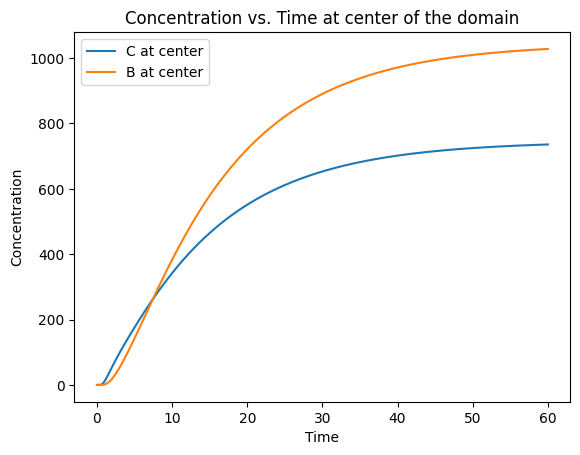

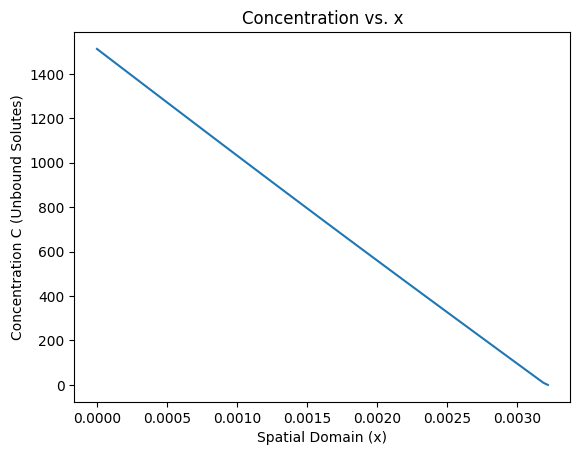

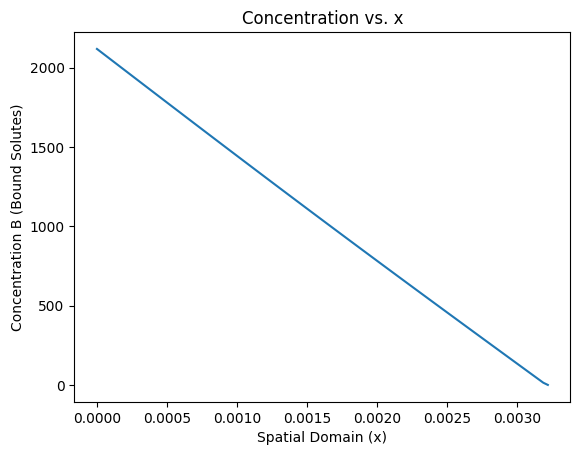

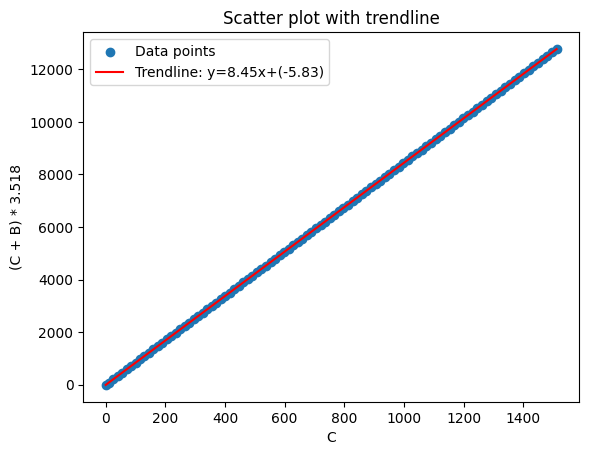

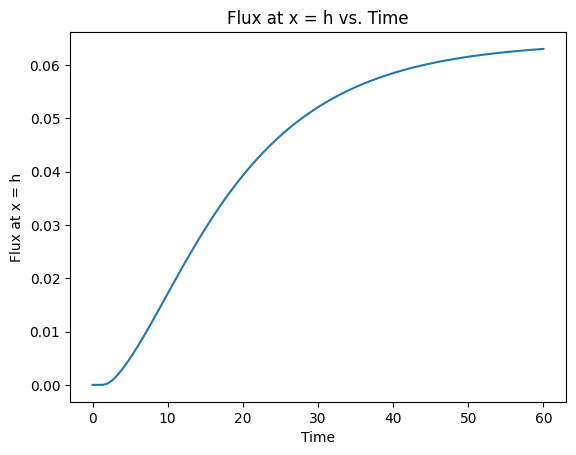

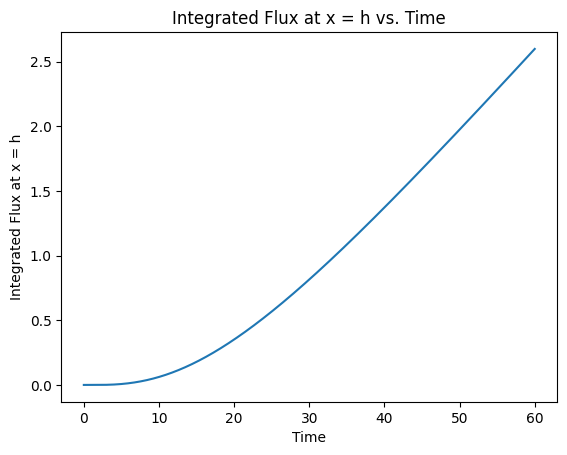

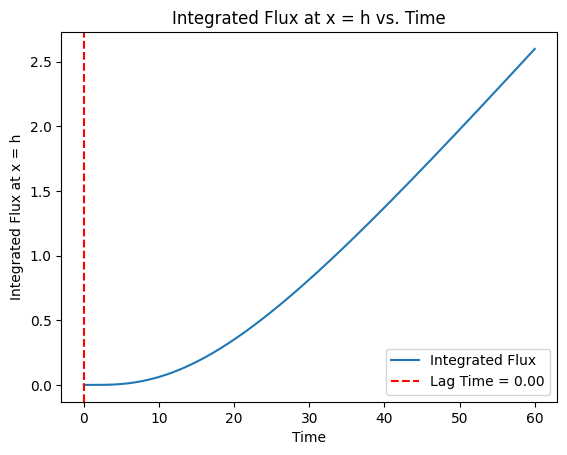

Lag time: 0.00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Constants
D = 2.069e-7
kf = 1.401 * 0.466  # kf/kr = 1.401, kr = 0.466
kr = 0.466
K = 0.756
C0 = 2000  # μg/mL
h = 32.2e-4  # Domain length

# Discretization parameters
Nx = 100  # Number of spatial points
dx = h / (Nx - 1)  # Spatial step size

# Time parameters
T = 60.0  # Total time
dt = 0.01  # Time step size
Nt = int(T / dt)  # Number of time steps

# Spatial grid
x = np.linspace(0, h, Nx)

# Initial conditions
C = np.zeros(Nx)
B = np.zeros(Nx)

# Boundary conditions
C[0] = K * C0
C[-1] = 0

# Sparse matrix for the PDE
off_diag_coeff = -D * dt / dx**2
main_diag_coeff = 1 + 2 * D * dt / dx**2 + kf * dt - (kr * kf * dt**2) / (1 + kr * dt)

main_diag = main_diag_coeff * np.ones(Nx - 2)
off_diag = off_diag_coeff * np.ones(Nx - 3)

def TDMA(a,b,c,d):
    n = len(d)
    w= np.zeros(n-1,float)
    g= np.zeros(n, float)
    p = np.zeros(n,float)

    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

# Time - Integration
C_history = np.zeros((Nt, Nx))
B_history = np.zeros((Nt, Nx))
C_history[0, :] = C.copy()
C_history[:, 0] = K * C0
C_history[:, Nx-1] = 0
B_history[0, :] = C.copy()

for n in range(1, Nt):
    # Constructing the d = solution matrix
    d = np.zeros(Nx-2)
    d[0] = C_history[n-1, 1] + (kr * dt / (1 + kr * dt)) * B_history[n-1, 1] - off_diag_coeff * C_history[n-1, 0]
    d[1:-1] = C_history[n-1, 2:-2] + (kr * dt / (1 + kr * dt)) * B_history[n-1, 2:-2]
    d[-1] = C_history[n-1, -1] + (kr * dt / (1 + kr * dt)) * B_history[n-1, -1] - off_diag_coeff * C_history[n-1, -1]

    # Solving the Conc using thomas algorithm
    C_history[n, 1:-1] = TDMA(off_diag, main_diag, off_diag, d)

    # Updating the bound conc of solute
    B_history[n, :] = (B_history[n-1, :] + kf * dt * C_history[n, :]) / (1 + kr * dt)

# Plotting concentration vs. time for both C and B
time_points = np.linspace(0, T, Nt)

plt.figure()
plt.plot(time_points, C_history[:, int(Nx/2)], label='C at center')
plt.plot(time_points, B_history[:, int(Nx/2)], label='B at center')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration vs. Time at center of the domain')
plt.legend()
plt.show()

# Plotting the C vs x for the last time
plt.figure()
plt.plot(x, C_history[Nt-1, :])
plt.xlabel('Spatial Domain (x)')
plt.ylabel('Concentration C (Unbound Solutes)')
plt.title('Concentration vs. x')
plt.show()

# Plotting the B vs x for the last time
plt.figure()
plt.plot(x, B_history[Nt-1, :])
plt.xlabel('Spatial Domain (x)')
plt.ylabel('Concentration B (Bound Solutes)')
plt.title('Concentration vs. x')
plt.show()

# Scatter plot for (C + B) * 3.518 vs. C at the last time step with trendline
C_last = C_history[-1, :]
B_last = B_history[-1, :]
CB_combined = (C_last + B_last) * 3.518

plt.figure()
plt.scatter(C_last, CB_combined, label='Data points')
slope, intercept, r_value, p_value, std_err = linregress(C_last, CB_combined)
plt.plot(C_last, slope * C_last + intercept, color='red', label=f'Trendline: y={slope:.2f}x+({intercept:.2f})')
plt.xlabel('C')
plt.ylabel('(C + B) * 3.518')
plt.title('Scatter plot with trendline')
plt.legend()
plt.show()

# Plot -D * (C[n+1] - C[n]) / dx at x = h vs. time
flux_at_h = -D * (C_history[:, -1] - C_history[:, -2]) / dx

plt.figure()
plt.plot(time_points, flux_at_h)
plt.xlabel('Time')
plt.ylabel('Flux at x = h')
plt.title('Flux at x = h vs. Time')
plt.show()

integrated_flux = np.cumsum(flux_at_h) * dt

plt.figure()
plt.plot(time_points, integrated_flux)
plt.xlabel('Time')
plt.ylabel('Integrated Flux at x = h')
plt.title('Integrated Flux at x = h vs. Time')
plt.show()

# Calculate the first and second derivatives of the integrated flux
first_derivative_flux = np.gradient(integrated_flux, dt)
second_derivative_flux = np.gradient(first_derivative_flux, dt)

# Determine lag time when the second derivative of integrated flux becomes close to zero
threshold = 1e-4  # This value may need to be adjusted based on your data
lag_time_index = np.where(np.abs(second_derivative_flux) < threshold)[0][0]
lag_time = time_points[lag_time_index]

# Plot integrated flux with lag time marked
plt.figure()
plt.plot(time_points, integrated_flux, label='Integrated Flux')
plt.axvline(x=lag_time, color='r', linestyle='--', label=f'Lag Time = {lag_time:.2f}')
plt.xlabel('Time')
plt.ylabel('Integrated Flux at x = h')
plt.title('Integrated Flux at x = h vs. Time')
plt.legend()
plt.show()

print(f'Lag time: {lag_time:.2f}')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Constants
D = 2.069e-7
kf = 1.401 * 0.466  # kf/kr = 1.401, kr = 0.466
kr = 0.466
K = 0.756
C0 = 2000  # μg/mL
h = 32.2e-4  # Domain length

# a = Lower Diag, b = Main Diag, c = Upper Diag, d = solution vector
def TDMA(a,b,c,d):
    n = len(d)
    q = np.zeros(n-1,float)
    p = np.zeros(n, float)
    sol = np.zeros(n,float)

    q[0] = c[0]/b[0]
    p[0] = d[0]/b[0]
    for i in range(1,n-1):
        q[i] = c[i]/(b[i] - a[i-1]*q[i-1])
    for i in range(1,n):
        p[i] = (d[i] - a[i-1]*p[i-1])/(b[i] - a[i-1]*q[i-1])
    sol[n-1] = p[n-1]
    for i in range(n-1,0,-1):
        sol[i-1] = p[i-1] - q[i-1]*sol[i]
  return sol

# Discretizing the space domain
Nx = 1000                         # Number of Spatial Points
dx = h_sc / (Nx - 1)              # Spatial Step Size
x = np.linspace(0, h_sc, Nx)      # Spatial grid

# Temporal Discretization
T = 60.0        # Total Time of Simulation (h)
dt = 0.01        # Time step size
Nt = int(T / dt)        # Number of time steps
# Initial Conditions
C = np.zeros(Nx)
B = np.zeros(Nx)

# Boundary Condition
C[0]  = K * C0
C[-1] = 0
# Using Crank Nicolson Scheme
# Sparse matrix for the PDE
off_diag_coeff =  - D*dt/(2*dx**2)
off_diag = off_diag_coeff * np.ones(Nx-3)

main_diag_coeff = 1 - 2*off_diag_coeff + 0.5*kf*dt - (0.25*kr*kf*(dt**2))/(1+0.5*kr*dt)
main_diag = main_diag_coeff * np.ones(Nx-2)
# diagonals = [off_diag, main_diag, off_diag]
# mat_C = diags(diagonals, [-1, 0, 1]).toarray()
# print(mat_C)
#  Time - Integration
C_history = np.zeros((Nt, Nx))
B_history = np.zeros((Nt, Nx))
C_history[0, :] = C.copy()
C_history[:, 0] = K * C0
C_history[:, Nx-1] = 0
B_history[0, :] = C.copy()
for n in range(1, Nt):
 	# Constructing the d = solution matrix
	d = np.zeros(Nx-2)
	d[0] = - off_diag_coeff*C_history[n-1, 0] + (1 + (1 - main_diag_coeff))* C_history[n-1, 1] - off_diag_coeff*C_history[n-1, 2] +\
            (kr * dt / (1 + 0.5*kr * dt)) * B_history[n-1,1] - off_diag_coeff * C_history[n, 0]
	d[1:-1] = -off_diag_coeff * C_history[n-1,1:-3] + (1 + (1 - main_diag_coeff)) * C_history[n-1,2:-2] - off_diag_coeff * C_history[n-1,3:-1] +\
             (kr * dt / (1 + 0.5*kr * dt)) * B_history[n-1,2:-2]
	d[-1] = - off_diag_coeff*C_history[n-1, -3] + (1 + (1 - main_diag_coeff))* C_history[n-1, -2] - off_diag_coeff*C_history[n-1, -1] +\
            (kr * dt / (1 + 0.5*kr * dt)) * B_history[n-1,-1] - off_diag_coeff * C_history[n,-1]

 	# Solving the Conc using thomas algorithm
	C_history[n,1:-1] = TDMA(off_diag, main_diag, off_diag, d)

 	# Updating the bound conc of solute
	B_history[n,:] = (B_history[n-1,:] + kf * dt * C_history[n,:]) / (1 + kr * dt)


# Time Grid
time_points = np.linspace(0 ,T, Nt)

# Isotherm (C+B) * volume of hydrated SC vs. C
vol_sc = 3.518
C_last = C_history[-1,  :]
B_last = B_history[-1,  :]
CB_combined = (C_last + B_last) * vol_sc

# Plotting the  Isotherm (C+B) * volume of hydrated SC vs. C at steady state
plt.figure()
plt.scatter(C_last, CB_combined, label='Data points')
plt.scatter(exp_isotherm_df['TH_free'], exp_isotherm_df['TH_free_bound'], label='Exp Data points', color='black')
slope_data, intercept_data, _, _, _ = linregress(C_last, CB_combined)
slope_exp_data, intercept_exp_data, _, _, _ = linregress(exp_isotherm_df['TH_free'], exp_isotherm_df['TH_free_bound'])
plt.plot(C_last, slope_data * C_last + intercept_data, color='red', label=f'Trendline: y = {slope_data:.2f}x + ({intercept_data:.2f})')
plt.plot(exp_isotherm_df['TH_free'], slope_exp_data * exp_isotherm_df['TH_free'] + intercept_exp_data, color='black',
         label=f'Trendline: y = {slope_exp_data:.2f}x + ({intercept_exp_data:.2f})')
plt.xlabel('TH Free (micro g/ml)')
plt.ylabel('TH Free + Bound (micro g/cm^2)')
plt.title('Isotherm')
plt.legend()
plt.show()

# Flux at x = h
flux_h = - D * (C_history[:, -1] - C_history[:, -2]) / dx

# Plotting the flux over the time
# plt.figure()
# plt.plot(time_points, flux_h)
# plt.xlabel('Time (hr)')
# plt.ylabel('Flux (-D * dC/dx) at x = h')
# plt.title('Flux at x = h vs Time')
# plt.show()

# Saving the figure.
# plt.savefig("Flux at x = h vs Time.jpg")

# TH Accumulated micro g / cm^2 vs time
integrated_flux_time = np.cumsum(flux_h) * dt

# Plotting the TH Accumulated micro g / cm^2 vs time
plt.figure()
plt.plot(time_points, integrated_flux_time, label='Simulation Curve')
plt.scatter(exp_acc_df['Time'], exp_acc_df['TH_acc'], label='Exp Data points', color='black')
plt.xlabel('Time (hr)')
plt.ylabel('TH Accumulation (micro g / cm^2)')
plt.title('TH Accumulation at x = h vs Time')
plt.legend()
plt.show()

array([8.87632269e-30, 1.52688547e-28, 2.66595940e-27, ...,
       6.30314417e-02, 6.30324316e-02, 6.30329263e-02])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants for SC layer
D_sc = 2.069e-7
kf_sc = 1.401 * 0.466
kr_sc = 0.466
K_sc = 0.756
C0 = 2000  # μg/mL
h_sc = 32.2e-4  # Domain length of SC

# Constants for Epidermis layer
D_ed = 1.0e-7  # Example value, update as needed
K_ed = 0.5  # Example value, update as needed
h_ed = 50.0e-4  # Domain length of Epidermis, update as needed

# Constants for Dermis layer
D_de = 0.5e-7  # Example value, update as needed
h_de = 100.0e-4  # Domain length of Dermis, update as needed

# Function for Thomas algorithm (TDMA)
def TDMA(a, b, c, d):
    n = len(d)
    q = np.zeros(n - 1, float)
    p = np.zeros(n, float)
    sol = np.zeros(n, float)

    q[0] = c[0] / b[0]
    p[0] = d[0] / b[0]
    for i in range(1, n - 1):
        q[i] = c[i] / (b[i] - a[i - 1] * q[i - 1])
    for i in range(1, n):
        p[i] = (d[i] - a[i - 1] * p[i - 1]) / (b[i] - a[i - 1] * q[i - 1])
    sol[n - 1] = p[n - 1]
    for i in range(n - 1, 0, -1):
        sol[i - 1] = p[i - 1] - q[i - 1] * sol[i]
    return sol

# Discretizing the space domain
Nx_sc = 300  # Number of Spatial Points in SC
Nx_ed = 300  # Number of Spatial Points in Epidermis
Nx_de = 300  # Number of Spatial Points in Dermis
dx_sc = h_sc / (Nx_sc - 1)  # Spatial Step Size in SC
dx_ed = h_ed / (Nx_ed - 1)  # Spatial Step Size in Epidermis
dx_de = h_de / (Nx_de - 1)  # Spatial Step Size in Dermis

# Temporal Discretization
T = 60.0  # Total Time of Simulation (h)
dt = 0.01  # Time step size
Nt = int(T / dt)  # Number of time steps

# Initial Conditions
C_sc = np.zeros(Nx_sc)
C_ed = np.zeros(Nx_ed)
C_de = np.zeros(Nx_de)
B_sc = np.zeros(Nx_sc)
B_ed = np.zeros(Nx_ed)

# Boundary Condition
C_sc[0] = K_sc * C0
C_de[-1] = 0  # Sink boundary condition in Dermis

# Using Crank Nicolson Scheme with flux balance at interfaces
def update_layers(C_sc, B_sc, C_ed, B_ed, C_de, D_sc, D_ed, D_de, kf, kr, dx_sc, dx_ed, dx_de, dt, Nx_sc, Nx_ed, Nx_de):
    off_diag_coeff_sc = -D_sc * dt / (2 * dx_sc**2)
    off_diag_sc = off_diag_coeff_sc * np.ones(Nx_sc - 3)
    main_diag_coeff_sc = 1 - 2 * off_diag_coeff_sc + 0.5 * kf * dt - (0.25 * kr * kf * (dt**2)) / (1 + 0.5 * kr * dt)
    main_diag_sc = main_diag_coeff_sc * np.ones(Nx_sc - 2)

    off_diag_coeff_ed = -D_ed * dt / (2 * dx_ed**2)
    off_diag_ed = off_diag_coeff_ed * np.ones(Nx_ed - 3)
    main_diag_coeff_ed = 1 - 2 * off_diag_coeff_ed + 0.5 * kf * dt - (0.25 * kr * kf * (dt**2)) / (1 + 0.5 * kr * dt)
    main_diag_ed = main_diag_coeff_ed * np.ones(Nx_ed - 2)

    off_diag_coeff_de = -D_de * dt / (2 * dx_de**2)
    off_diag_de = off_diag_coeff_de * np.ones(Nx_de - 3)
    main_diag_coeff_de = 1 - 2 * off_diag_coeff_de
    main_diag_de = main_diag_coeff_de * np.ones(Nx_de - 2)

    for n in range(1, Nt):
        # SC layer
        d_sc = np.zeros(Nx_sc - 2)
        d_sc[0] = -off_diag_coeff_sc * C_sc[0] + (1 + (1 - main_diag_coeff_sc)) * C_sc[1] - off_diag_coeff_sc * C_sc[2] + \
                  (kr * dt / (1 + 0.5 * kr * dt)) * B_sc[1] - off_diag_coeff_sc * C_sc[0]
        d_sc[1:-1] = -off_diag_coeff_sc * C_sc[1:-3] + (1 + (1 - main_diag_coeff_sc)) * C_sc[2:-2] - off_diag_coeff_sc * C_sc[3:-1] + \
                     (kr * dt / (1 + 0.5 * kr * dt)) * B_sc[2:-2]
        d_sc[-1] = -off_diag_coeff_sc * C_sc[-3] + (1 + (1 - main_diag_coeff_sc)) * C_sc[-2] - off_diag_coeff_sc * C_sc[-1] + \
                   (kr * dt / (1 + 0.5 * kr * dt)) * B_sc[-1] - off_diag_coeff_sc * C_sc[-1]

        C_sc[1:-1] = TDMA(off_diag_sc, main_diag_sc, off_diag_sc, d_sc)
        C_sc[0] = K_sc * C0

        B_sc = (B_sc + kf * dt * C_sc) / (1 + kr * dt)

        # Epidermis layer
        d_ed = np.zeros(Nx_ed - 2)
        d_ed[0] = -off_diag_coeff_ed * C_ed[0] + (1 + (1 - main_diag_coeff_ed)) * C_ed[1] - off_diag_coeff_ed * C_ed[2] + \
                  (kr * dt / (1 + 0.5 * kr * dt)) * B_ed[1] - off_diag_coeff_ed * C_ed[0]
        d_ed[1:-1] = -off_diag_coeff_ed * C_ed[1:-3] + (1 + (1 - main_diag_coeff_ed)) * C_ed[2:-2] - off_diag_coeff_ed * C_ed[3:-1] + \
                     (kr * dt / (1 + 0.5 * kr * dt)) * B_ed[2:-2]
        d_ed[-1] = -off_diag_coeff_ed * C_ed[-3] + (1 + (1 - main_diag_coeff_ed)) * C_ed[-2] - off_diag_coeff_ed * C_ed[-1] + \
                   (kr * dt / (1 + 0.5 * kr * dt)) * B_ed[-1] - off_diag_coeff_ed * C_ed[-1]

        C_ed[1:-1] = TDMA(off_diag_ed, main_diag_ed, off_diag_ed, d_ed)
        C_ed[0] = (D_sc * C_sc[-1] - D_ed * C_ed[1]) / (D_sc + D_ed)  # Flux balance at SC-Epidermis interface

        B_ed = (B_ed + kf * dt * C_ed) / (1 + kr * dt)

        # Dermis layer
        d_de = np.zeros(Nx_de - 2)
        d_de[0] = -off_diag_coeff_de * C_de[0] + (1 + (1 - main_diag_coeff_de)) * C_de[1] - off_diag_coeff_de * C_de[2]
        d_de[1:-1] = -off_diag_coeff_de * C_de[1:-3] + (1 + (1 - main_diag_coeff_de)) * C_de[2:-2] - off_diag_coeff_de * C_de[3:-1]
        d_de[-1] = -off_diag_coeff_de * C_de[-3] + (1 + (1 - main_diag_coeff_de)) * C_de[-2] - off_diag_coeff_de * C_de[-1]

        C_de[1:-1] = TDMA(off_diag_de, main_diag_de, off_diag_de, d_de)
        C_de[0] = (D_ed * C_ed[-1] - D_de * C_de[1]) / (D_ed + D_de)  # Flux balance at Epidermis-Dermis interface
        C_de[-1] = 0  # Sink boundary condition

    return C_sc, B_sc, C_ed, B_ed, C_de

# Update layers
C_sc, B_sc, C_ed, B_ed, C_de = update_layers(C_sc, B_sc, C_ed, B_ed, C_de, D_sc, D_ed, D_de, kf_sc, kr_sc, dx_sc, dx_ed, dx_de, dt, Nx_sc, Nx_ed, Nx_de)

# Plotting the results
time_points = np.linspace(0, T, Nt)
x_sc = np.linspace(0, h_sc, Nx_sc)
x_ed = np.linspace(h_sc, h_sc + h_ed, Nx_ed)
x_de = np.linspace(h_sc + h_ed, h_sc + h_ed + h_de, Nx_de)

plt.figure()
plt.plot(x_sc, C_sc, label='SC')
plt.plot(x_ed, C_ed, label='Epidermis')
plt.plot(x_de, C_de, label='Dermis')
plt.xlabel('Distance (cm)')
plt.ylabel('Concentration (μg/mL)')
plt.legend()
plt.title('Concentration Profile in Skin Layers')
plt.show()

In [ ]:
# Using the correlation to get the value of k_on and k_off

# For Weak base and acid and finite size

import numpy as np

# Defining Parameters
nu = 1.0
rho_w = 1.0     # g/cm^3, density of water
rho_ker = 1.37  # g/cm^3, density of keratin
v_c = 1.0       # Volume Correction Factor
phi_ker_fhs = 0.1928    #Volume fraction of keratin in fully hydrated state(fhs)
phi_ker_phs = 0.6044    #Volume fraction of keratin in partially hydrated state(phs)
phi_lip_fhs_mi = 0.0316 #Volume fraction of lipid in SC in fhs (microscopic)
phi_lip_phs_mi = 0.0927 #Volume fraction of lipid in SC in phs (microscopic)
phi_cor_fhs_mi = 1- phi_lip_fhs_mi #Volume fraction of corneocyte in SC in fhs (microscopic)
phi_cor_phs_mi = 1- phi_lip_phs_mi #Volume fraction of corneocyte in SC in phs (microscopic)
f_non = 1            # non ionized fraction of freely diffusing solute in the aqueous phase of the corneocyte at the SC pH (default 5.5)
# For Theophylline solute
TH_log_10_K_ow = -0.02  # log Partition coefficient of octanol/water for TH
TH_K_ow = 10**(TH_log_10_K_ow) # Partition coefficient of octanol/water for TH
TH_V_A = 168    # cm^3/mol, solute molar volume as a liquid at its normal boiling point
# # For Testosterone solute
# Tes_log_10_K_ow = 3.32  # Partition coefficient of octanol/water for Testosterone
# Tes_V_A = 350    # cm^3/mol, solute molar volume as a liquid at its normal boiling point
# Calculating the required parameter based on the given correlation
def corr(K_ow, V_A, case_crit=1):
    K_lip_w = 0.43 * (K_ow) ** (0.81)
    if V_A <= 334.5:
        a_solute = 0.156 * 10*(-10) * V_A*(0.6)
    elif V_A > 334.5:
        a_solute = 0.735 * 10*(-10) * V_A*(1/3)
    labda = a_solute / (35*10**(-10))
    K_cor_w_fhs = (1 - phi_ker_fhs * (1+labda)**2)/f_non
    K_cor_w_phs = (1 - phi_ker_phs * (1+labda)**2)/f_non
    K_sc_w_free_fhs = phi_lip_fhs_mi * K_lip_w + phi_cor_fhs_mi * K_cor_w_fhs
    K_sc_w_free_phs = phi_lip_phs_mi * K_lip_w + phi_cor_phs_mi * K_cor_w_phs
    K_eq_ker = f_non * 5.4 * K_ow ** (0.27)
    # Case B --> 2
    if case_crit == 2:
        k_off_ker = nu / (25.75 + 8.35*(K_ow**(0.34)))
        k_on_ker = K_eq_ker * k_off_ker
        k_on_sc_fhs = k_on_ker*(rho_ker/rho_w * phi_ker_fhs) / (f_non * (phi_lip_fhs_mi/phi_cor_fhs_mi) * K_lip_w + 1 - phi_ker_fhs * (1+labda)**2)
        k_on_sc_phs = k_on_ker*(rho_ker/rho_w * phi_ker_phs) / (f_non * (phi_lip_phs_mi/phi_cor_phs_mi) * K_lip_w + 1 - phi_ker_phs * (1+labda)**2)
        # k_on_sc_fhs = (0.2641*k_on_ker)/(0.0326*K_lip_w + 1 - 0.1928*(1+labda)**2)
        # k_on_sc_phs = (0.8280*k_on_ker)/(0.1022*K_lip_w + 1 - 0.6044*(1+labda)**2)
        k_off_sc = k_off_ker
    # Case A --> 1
    else:
        k_off_ker = nu / (25.75 + 0.459*K_eq_ker)
        k_on_ker = K_eq_ker * k_off_ker
        k_on_sc_fhs = k_on_ker*(rho_ker/rho_w * phi_ker_fhs) / (f_non * (phi_lip_fhs_mi/phi_cor_fhs_mi) * K_lip_w + 1 - phi_ker_fhs * (1+labda)**2)
        k_on_sc_phs = k_on_ker*(rho_ker/rho_w * phi_ker_phs) / (f_non * (phi_lip_phs_mi/phi_cor_phs_mi) * K_lip_w + 1 - phi_ker_phs * (1+labda)**2)
        # k_on_sc_fhs = (0.2641*k_on_ker)/(0.0326*K_lip_w + 1 - 0.1928*(1+labda)**2)
        # k_on_sc_phs = (0.8280*k_on_ker_A)/(0.1022*K_lip_w + 1 - 0.6044*(1+labda)**2)
        k_off_sc = k_off_ker
  return K_sc_w_free_fhs, k_off_sc, k_on_sc_fhs

TH_K_sc_w_free_fhs, TH_k_off_sc, TH_k_on_sc_fhs = corr(TH_K_ow, TH_V_A, case_crit=1)
print(TH_K_sc_w_free_fhs, TH_k_off_sc*60, TH_k_on_sc_fhs*60, TH_k_on_sc_fhs/TH_k_off_sc)


In [ ]:
import numpy as np

# Constants and Parameters
nu = 1.0
rho_w = 1.0
rho_ker = 1.37
phi_ker = {'fhs': 0.1928, 'phs': 0.6044}
phi_lip_mi = {'fhs': 0.0316, 'phs': 0.0927}
phi_cor_mi = {state: 1 - phi_lip_mi[state] for state in ['fhs', 'phs']}
f_non = 1

# Theophylline Properties
TH_log_10_K_ow = -0.02
TH_K_ow = 10 ** TH_log_10_K_ow
TH_V_A = 168

def calculate_labda(V_A):
    if V_A <= 334.5:
        a_solute = 0.156 * 10**(-10) * V_A * 0.6
    else:
        a_solute = 0.735 * 10**(-10) * V_A**(1/3)
    return a_solute / (35 * 10**(-10))

def calculate_partition_coefficients(K_ow, hydration_state, labda):
    K_lip_w = 0.43 * K_ow**0.81
    K_cor_w = (1 - phi_ker[hydration_state] * (1 + labda)**2) / f_non
    K_sc_w_free = phi_lip_mi[hydration_state] * K_lip_w + phi_cor_mi[hydration_state] * K_cor_w
    return K_lip_w, K_cor_w, K_sc_w_free

def calculate_kinetics(K_ow, case_crit, hydration_state, K_lip_w, labda):
    K_eq_ker = f_non * 5.4 * K_ow**0.27
    if case_crit == 2:
        k_off_ker = nu / (25.75 + 8.35 * K_ow**0.34)
    else:
        k_off_ker = nu / (25.75 + 0.459 * K_eq_ker)
    k_on_ker = K_eq_ker * k_off_ker
    k_on_sc = k_on_ker * (rho_ker / rho_w * phi_ker[hydration_state]) / (f_non * (phi_lip_mi[hydration_state] / phi_cor_mi[hydration_state]) * K_lip_w + 1 - phi_ker[hydration_state] * (1 + labda)**2)
    return k_off_ker, k_on_sc

def corr(K_ow, V_A, case_crit=1, hydration_state='fhs'):
    labda = calculate_labda(V_A)
    K_lip_w, K_cor_w, K_sc_w_free = calculate_partition_coefficients(K_ow, hydration_state, labda)
    k_off_ker, k_on_sc = calculate_kinetics(K_ow, case_crit, hydration_state, K_lip_w, labda)
    return K_sc_w_free, k_off_ker, k_on_sc

# Example usage
TH_K_sc_w_free_fhs, TH_k_off_sc, TH_k_on_sc_fhs = corr(TH_K_ow, TH_V_A, case_crit=1, hydration_state='fhs')
print(TH_K_sc_w_free_fhs, TH_k_off_sc*60, TH_k_on_sc_fhs*60, TH_k_on_sc_fhs / TH_k_off_sc)

In [ ]:
import numpy as np

# Defining Parameters
nu = 1.0
rho_w = 1.0     # g/cm^3, density of water
rho_ker = 1.37  # g/cm^3, density of keratin
v_c = 1.0       # Volume Correction Factor
phi_ker_fhs = 0.1928    # Volume fraction of keratin in fully hydrated state(fhs)
phi_ker_phs = 0.6044    # Volume fraction of keratin in partially hydrated state(phs)
phi_lip_fhs_mi = 0.0316 # Volume fraction of lipid in SC in fhs (microscopic)
phi_lip_phs_mi = 0.0927 # Volume fraction of lipid in SC in phs (microscopic)
phi_cor_fhs_mi = 1 - phi_lip_fhs_mi # Volume fraction of corneocyte in SC in fhs (microscopic)
phi_cor_phs_mi = 1 - phi_lip_phs_mi # Volume fraction of corneocyte in SC in phs (microscopic)
f_non = 1            # non ionized fraction of freely diffusing solute in the aqueous phase of the corneocyte at the SC pH (default 5.5)

# For Theophylline solute
TH_log_10_K_ow = -0.02  # log Partition coefficient of octanol/water for TH
TH_K_ow = 10**(TH_log_10_K_ow) # Partition coefficient of octanol/water for TH
TH_V_A = 168    # cm^3/mol, solute molar volume as a liquid at its normal boiling point

def get_k_eq_ker(K_ow):
    return f_non * 5.4 * K_ow ** (0.27)

def get_k_lip_w(K_ow):
    return 0.43 * (K_ow) ** (0.81)

def get_a_solute(V_A):
    if V_A <= 334.5:
        return 0.156 * 10**(-10) * V_A * (0.6)
    else:
        return 0.735 * 10**(-10) * V_A * (1/3)

def get_labda(a_solute):
    return a_solute / (35 * 10**(-10))

def get_k_cor_w(phi_ker, labda):
    return (1 - phi_ker * (1 + labda)**2) / f_non

def calculate_k_on_k_off(K_ow, V_A, case_crit=1, state='fhs'):
    K_lip_w = get_k_lip_w(K_ow)
    a_solute = get_a_solute(V_A)
    labda = get_labda(a_solute)

    if state == 'fhs':
        phi_ker = phi_ker_fhs
        phi_lip_mi = phi_lip_fhs_mi
        phi_cor_mi = phi_cor_fhs_mi
    else:
        phi_ker = phi_ker_phs
        phi_lip_mi = phi_lip_phs_mi
        phi_cor_mi = phi_cor_phs_mi

    K_cor_w = get_k_cor_w(phi_ker, labda)
    K_sc_w_free = phi_lip_mi * K_lip_w + phi_cor_mi * K_cor_w
    K_eq_ker = get_k_eq_ker(K_ow)

    if case_crit == 2:
        k_off_ker = nu / (25.75 + 8.35 * (K_ow ** 0.34))
    else:
        k_off_ker = nu / (25.75 + 0.459 * K_eq_ker)

    k_on_ker = K_eq_ker * k_off_ker
    k_on_sc = k_on_ker * (rho_ker / rho_w * phi_ker) / (f_non * (phi_lip_mi / phi_cor_mi) * K_lip_w + 1 - phi_ker * (1 + labda)**2)
    k_off_sc = k_off_ker

    return K_sc_w_free, k_off_sc, k_on_sc

# Example usage
TH_K_sc_w_free_fhs, TH_k_off_sc_fhs, TH_k_on_sc_fhs = calculate_k_on_k_off(TH_K_ow, TH_V_A, case_crit=1, state='fhs')
print(TH_K_sc_w_free_fhs, TH_k_off_sc_fhs * 60, TH_k_on_sc_fhs * 60, TH_k_on_sc_fhs / TH_k_off_sc_fhs)

TH_K_sc_w_free_phs, TH_k_off_sc_phs, TH_k_on_sc_phs = calculate_k_on_k_off(TH_K_ow, TH_V_A, case_crit=1, state='phs')
print(TH_K_sc_w_free_phs, TH_k_off_sc_phs * 60, TH_k_on_sc_phs * 60, TH_k_on_sc_phs / TH_k_off_sc_phs)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants for each layer
D_sc = 2.069e-7  # Diffusion coefficient for SC
D_ed = 1.0e-7    # Diffusion coefficient for Epidermis, example value
D_de = 0.5e-7    # Diffusion coefficient for Dermis, example value

kf = 1.401 * 0.466  # Example binding kinetics
kr = 0.466
K_sc = 0.756  # Partition coefficient at SC boundary
K_ed = 0.5    # Partition coefficient at Epidermis boundary

C0 = 2000  # Initial concentration μg/mL
h_sc = 32.2e-4  # Length of SC

# Spatial discretization
Nx_sc = 100
Nx_ed = 100
Nx_de = 100
Nx_total = Nx_sc + Nx_ed + Nx_de
dx = h_sc / (Nx_sc - 1)  # Assuming uniform discretization

# Temporal discretization
T = 60.0  # Total simulation time in hours
dt = 0.01  # Time step
Nt = int(T / dt)  # Number of time steps

# Initial conditions
C = np.zeros(Nx_total)
C[0:Nx_sc] = K_sc * C0  # Initial concentration in SC based on partition coefficient

# Boundary Conditions
C[-1] = 0  # Sink boundary condition at the end of Dermis

# Coefficient matrix setup for Crank-Nicolson scheme
A = np.zeros((Nx_total, Nx_total))
for i in range(Nx_total):
    if i == 0:
        A[i, i] = 1 + D_sc * dt / dx**2
        A[i, i + 1] = -D_sc * dt / dx**2
    elif i == Nx_sc - 1:  # Interface SC-Epidermis
        A[i, i - 1] = -D_sc * dt / dx**2
        A[i, i] = 1 + (D_sc + D_ed) * dt / (2 * dx**2)  # Average diffusion coefficient at the boundary
        A[i, i + 1] = -D_ed * dt / dx**2
    elif i == Nx_sc + Nx_ed - 1:  # Interface Epidermis-Dermis
        A[i, i - 1] = -D_ed * dt / dx**2
        A[i, i] = 1 + (D_ed + D_de) * dt / (2 * dx**2)  # Average diffusion coefficient at the boundary
        A[i, i + 1] = -D_de * dt / dx**2
    elif i == Nx_total - 1:
        A[i, i - 1] = -D_de * dt / dx**2
        A[i, i] = 1 + D_de * dt / dx**2
    else:
        D = D_sc if i < Nx_sc else (D_ed if i < Nx_sc + Nx_ed else D_de)
        A[i, i - 1] = -D * dt / dx**2
        A[i, i] = 1 + 2 * D * dt / dx**2
        A[i, i + 1] = -D * dt / dx**2

# Time-stepping solution
C_history = np.zeros((Nt, Nx_total))
C_history[0, :] = C.copy()

for t in range(1, Nt):
    C_next = np.linalg.solve(A, C_history[t - 1])
    C_history[t, :] = C_next

# Plotting the final concentration profile
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 3 * h_sc, Nx_total), C_history[-1], label='Concentration Profile')
plt.xlabel('Distance (cm)')
plt.ylabel('Concentration (μg/mL)')
plt.title('Concentration Profile Across Skin Layers at Final Time')
plt.legend()
plt.show()


In [ ]:
second_derivative_flux

array([1.43812225e-26, 1.32854154e-25, 1.56733911e-24, ...,
       9.90193805e-05, 7.42277662e-05, 4.94729235e-05])

# Understanding the Assumptions Behind Equations in Skin Penetration Modeling

## Key Terms and Equations

### Nonionized Fraction (\( f_{cor}^{non} \))

- **Definition**: \( (f_{cor}^{non})_{free} \) is the nonionized fraction of freely diffusing solute in the aqueous phase of the corneocyte at the SC pH.
- **Calculation**: For a weak acid, it is calculated as \( f_{non} = \left( 1 + 10^{\text{pH} - \text{p}K_a} \right)^{-1} \).

This equation represents the fraction of a solute that remains nonionized at a given pH. The pH of the stratum corneum (SC) is assumed to be 5.5.

### Volume Fraction of Keratin Fibers (\( \phi_{ker} \))

- **Definition**: \( \phi_{ker} \) is the volume fraction of keratin fibers in a corneocyte.
- **Relevance**: This factor is essential for understanding how much of the corneocyte volume is occupied by keratin, influencing the solute's interaction with the SC.

### Equations (3) and (4)

- These equations are adapted from previous work (Nitsche et al., 2006) and refer specifically to the diffusion and partition coefficients of freely diffusing solute:
  - \( \overline{D}^{sc} \): Macroscopic diffusion coefficient.
  - \( \overline{K}_{sc/w}^{free} \): Effective SC/water partition coefficient for the freely diffusing solute.

### Equation (6)

- **Definition**: Represents the partition coefficient \( K_{cor/w}^{free} \) for freely diffusing solute in the corneocyte phase, which is a function of various parameters, including volume fractions and densities.

## Assumptions and Differences

1. **Ionization and Nonionized Fraction**:
   - Assumes that the nonionized fraction (\( f_{non} \)) is easily calculable and directly influences the binding and diffusion properties within the SC.
   - The pH of the SC is a critical parameter (default 5.5), impacting the ionization state of the solute.

2. **Volume Fraction of Keratin (\( \phi_{ker} \))**:
   - Important for calculating the binding dynamics and the partitioning of the solute within the corneocyte.

3. **Adaptations from Previous Models**:
   - The equations used differ from those in Nitsche et al. (2006) in that they now specifically refer to freely diffusing solute rather than the combined free and bound solute.

4. **Terminology and Nomenclature**:
   - The nomenclature has been updated to use "ker" instead of "pro" to denote keratin-related parameters consistently.

## Practical Implications

- **Model Accuracy**: These equations and assumptions are designed to improve the model's accuracy in predicting solute behavior in the SC by distinguishing between free and bound states and accounting for the effects of ionization.
- **Relevance to Experiments**: The assumptions about SC pH and the ionization state of solutes are grounded in experimental observations, ensuring that the model reflects real-world conditions.

---

## Ultrasopic vs. Macroscopic Rate Constants

### Key Concepts and Differences

**Ultrascopic Rate Constants**:
  - \( k_{ker}^{off} \): Unbinding rate constant at the ultrascopic level.
  - \( k_{ker}^{on} \): Binding rate constant at the ultrascopic level.

**Macroscopic Rate Constants**:
  - \( \overline{k}_{off}^{sc} \): Unbinding rate constant at the macroscopic level.
  - \( \overline{k}_{on}^{sc} \): Binding rate constant at the macroscopic level.

### Explanation of Differences

**Unbinding Rate Constant ( \( k_{off} \) )**

- The unbinding rate constant (\( k_{off} \)) at both ultrascopic and macroscopic levels is assumed to remain unchanged. This is because the mean survival time of a bound solute molecule (i.e., how long it remains bound before detaching) is an inherent property of the adsorption process.
- **Concentration Basis Independence**: The rate of unbinding is considered independent of whether the concentration is measured per keratin mass, keratin dispersion, or total tissue volume. This means that the kinetics of a solute detaching from a keratin microfibril are not affected by how densely the keratin is packed or how it is distributed volumetrically.

**Binding Rate Constant ( \( k_{on} \) )**

- The binding rate constant (\( k_{on} \)), however, is affected by the concentration basis used. This implies that the likelihood of a solute molecule encountering a binding site (and thus binding) is influenced by how the concentration of the solute is measured.
- **Concentration Basis Dependence**: Since the binding rate depends on the probability of solute molecules encountering binding sites, it is influenced by the distribution and density of keratin microfibrils. Therefore, when converting from ultrascopic to macroscopic scales, adjustments are needed to account for this dependence.

### Practical Implications

- **Consistency in Measurements**: For accurate modeling, it's important to maintain consistency in how concentrations are measured and reported, especially when translating findings from microscopic scales to macroscopic applications.
- **Model Accuracy**: Understanding that the unbinding rate constant remains stable across scales, while the binding rate constant does not, helps refine the model to better predict solute behavior in the stratum corneum (SC).

### Conclusion

The key takeaway from this excerpt is the distinction between how the binding and unbinding rate constants are affected by the concentration basis used. The unbinding rate constant is stable across different scales, while the binding rate constant varies depending on the concentration basis. This understanding helps in accurately modeling the kinetics of solute binding and unbinding in the SC.

---

## Initial Conditions and Boundary Conditions

### Initial Conditions for \( C_{sc} \)

The initial conditions within the SC are given by:

\[ \overline{C}^{sc}(z, 0) = \begin{cases}
\overline{C}_0^{sc} & 0 \leq z \leq f h^{sc} \\
0 & f h^{sc} < z \leq h^{sc}
\end{cases} \]

\[ \overline{B}^{sc}(z, 0) = 0 \quad 0 \leq z \leq h^{sc} \]

- **\( \overline{C}_0^{sc} \)**: The initial free solute concentration in the SC that is at equilibrium with the initial concentration of the dose solution, \( C_v^0 \).
- **\( K_{v/w} \)**: Partition coefficient that corrects for nonaqueous vehicles or aqueous vehicles leading to an ionization state other than the nonionized solute in water.
- **\( (f_v^{non})^{-1} \)**: Nonionized fraction for an aqueous solution in which the solute is partially ionized.

### Boundary Conditions at the Base of the SC

The boundary conditions at the base of the SC are given by:

\[ \overline{D}^{sc} \cdot \frac{\partial \overline{C}^{sc}(h^{sc}, t)}{\partial z} = D^{ed} \cdot \frac{\partial C^{ed}(h^{sc}, t)}{\partial z} \]

\[ \overline{C}^{sc}(h^{sc}, t) / \overline{K}_{sc/w}^{free} = C^{ed}(h^{sc}, t) / K_{ed/w}^{free} \]

### Boundary Conditions at the Surface of the SC

The boundary conditions at the surface of the SC vary according to the state of dry down.

**\( \overline{C}_0^{sc} \) Calculation**:
\[ \overline{C}_0^{sc} = (C_v^0 / K_{v/w}) \cdot \overline{K}_{sc/w}^{free} \]

- \( C_v^0 \): Initial concentration of the dose solution.
- \( K_{v/w} \): Partition coefficient correcting for vehicle effects.
- \( \overline{K}_{sc/w}^{free} \): Effective SC/water partition coefficient for the freely diffusing solute.

These initial and boundary conditions are crucial for accurately modeling the diffusion and binding behavior of solutes within the SC.


### Partition Coefficient $K_{v/w}$ and Nonionized Fraction $(f_v^{non})^{-1}$

**Partition Coefficient $K_{v/w}$**:
- **Definition**: $K_{v/w}$ is the partition coefficient that corrects for nonaqueous vehicles or aqueous vehicles that lead to an ionization state other than the nonionized solute in water.
- **Purpose**: This coefficient accounts for the differences in solute behavior between various vehicle environments (e.g., nonaqueous vs. aqueous) and corrects the partitioning accordingly. It ensures that the model accurately reflects the solute's distribution between the vehicle and the stratum corneum (SC) under different conditions.

**Nonionized Fraction $(f_v^{non})^{-1}$**:
- **Definition**: $(f_v^{non})^{-1}$ is the inverse of the nonionized fraction for an aqueous solution in which the solute is partially ionized.
- **Calculation**: For a weak acid, the nonionized fraction $f_{non}$ is given by:
  $[
  f_{non} = \left( 1 + 10^{\text{pH} - \text{p}K_a} \right)^{-1}
  $]

  Thus, $(f_v^{non})^{-1}$ is:
  $[
  (f_v^{non})^{-1} = \left( 1 + 10^{\text{pH} - \text{p}K_a} \right)
  $]
- **Purpose**: This fraction adjusts for the degree of ionization of the solute in an aqueous solution. Since only the nonionized form of the solute diffuses freely across the SC, this factor corrects the partitioning to reflect the actual proportion of nonionized solute available for diffusion.


### Formulation Kinetics in Model 4

**Representation of Formulation Kinetics**:
- **Model Building**: The representation of formulation kinetics in Model 4 builds on that described in Miller and Kasting (2015), later modified by Yu et al. (2022) (Model 3).
  - Miller and Kasting described a multicomponent vehicle with all components miscible but one – the solute of interest.
  - Yu et al. limited the composition to two components, adding a follicular pathway, dissolution-limited kinetics for solid precipitates, and the capability to handle ionized or partially ionized solutes.
  - In these models, the solvent persists at the start of the simulation and dissipates by evaporation and penetration based on its vapor pressure and activity in the presence of dissolved solute.
  - As a result, the boundary conditions at the skin surface vary depending on the saturation state of the vehicle and whether either the solute or solvent has completely dissipated.
  - A small fraction of the formulation flows into the upper part of the hair follicle (the infundibulum) and deposits its contents there (Yu et al., 2022).

**Early Stages of Dissipation Process**:
- **Comparison to Previous Models**: The early stages of the dissipation process described here vary from those in the previously cited references and from those in Hamadeh et al. (2021), who also used a two-component vehicle model.
  - Hamadeh et al.'s slow binding model offers a complementary interpretation to the finding that the solute deposition layer has a lower capacity than predicted from Dancik et al. (2013).
  - For clarity, the equilibrium between a well-stirred vehicle containing a nonionized solute and solvent at the SC/vehicle interface is discussed.
  - Elaborations regarding the follicular infundibulum are described in Yu et al. (2022) and more detail on multicomponent vehicle thermodynamics can be found in Appendix 1 of Miller and Kasting (2015).
  - Adjustments for ionization are discussed in Section 2.3 and evaporation is discussed in Section 2.5.

**Partitioning of Solvent and Solute in Model 4**:
- **Initial Contact and Partitioning**: When the binary formulation contacts the skin in Model 4, there is immediate partitioning of both the solvent (Species 1) and the solute (Species 2) into the SC deposition layer.
  - For partially hydrated skin, the upper 10% of the SC is involved, while for fully hydrated skin, the upper 2.5% is involved (Dancik et al., 2013).
  - The partitioning is governed by Eqs. (4), (11), and (13) rather than by thermodynamic equilibria as described by Miller and Kasting (2015).
  - Partition equilibrium involves only the freely diffusing components, $\overline{C}_1^{sc}$ and $\overline{C}_2^{sc}$, as expressed by Eq. (13).
  - Binding to yield species $\overline{B}_1^{sc}$ and $\overline{B}_2^{sc}$ begins immediately after deposition at a rate governed by Eqs. (2) and (7)–(10), with the exception of water, for which $K_{ker}^{eq,1} \equiv PC_{pro/pH} = 0$, yielding $\overline{B}_1^{sc} = 0$.

**Practical Limitations and Adjustments**:
- **Limitations for Highly Water-Soluble Solutes**: To avoid unrealistically high sorption of water-miscible organic solvents and other highly water-soluble solutes, $\overline{K}_{sc/w}^{eq,1}$ is limited to $\rho / 3$, where $\overline{K}_{sc/w}^{eq,1}$ is the equilibrium SC/water partition coefficient, and $\rho$ is the density of the neat chemical.
  - This value is supported experimentally for the ethanol/water system (Berner et al., 1989) and serves as a practical limitation for other chemicals.
  - Arguments for why $K_{ker}^{eq,1}$ should be zero for water are presented in Appendix C of Nitsche et al. (2006) and in their Eq. (C1) or the present Eq. (6).

**Special Case for Water**:
- **Water's Role**: Water is a special case as it hydrates keratin. Slowly reversible binding of water can be observed (Anissimov and Roberts, 2009), but it does not impact the total amount of water in the SC. Instead, it partitions the total amount of water into free and bound subsets (Nitsche et al., 2006).
- **Limitations for Water-Miscible Solvents**: Different arguments apply to the limitation on $\overline{K}_{sc/w}^{eq,1}$ for water-miscible solvents like ethanol and acetone. Direct application of Eq. (8) leads to enormous predicted absorption of these solvents when the external concentration is high and binding equilibrium has been achieved.

**Impacts on Skin Permeability**:
- **Swelling and Deswelling Effects**: Although some co-swelling occurs with ethanol, it is modest compared to that predicted by blind use of Eq. (8). Large amounts of neat ethanol actually de-swell the SC (Berner et al., 1989), whereas extended exposure to ethanol, acetone, or other more aggressive solvents disrupts or extracts SC lipids, increasing skin permeability (Scheuplein, 1978).
- **Further Considerations**: Further arguments are presented in Section 7.3. More precise treatment of transient absorption of these chemicals awaits the development of true multicomponent skin swelling models comparable to that for water (Li et al., 2015).


In [ ]:
# import plotly.graph_objects as go

# # Create the animated plot using Plotly
# frames = [go.Frame(data=[go.Scatter(x=x, y=C_history[n, :])], name=str(n)) for n in range(Nt)]

# fig = go.Figure(
#     data=[go.Scatter(x=x, y=C_history[0, :])],
#     layout=go.Layout(
#         title="Concentration vs. x over time",
#         xaxis=dict(title="Spatial Domain (x)"),
#         yaxis=dict(title="Concentration C (Unbound Solutes)", range=[0, C0]),
#         updatemenus=[dict(
#             type="buttons",
#             buttons=[dict(label="Play",
#                           method="animate",
#                           args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True, mode='immediate')]),
#                      dict(label="Pause",
#                           method="animate",
#                           args=[[None], dict(frame=dict(duration=0, redraw=False), mode='immediate')])
#                      ]
#         )]
#     ),
#     frames=frames
# )

# fig.show()

# Characteristic Time Scale

## Definition
The characteristic time scale is a measure of the time over which significant changes occur in the system. For diffusion processes, it can be estimated using the formula:

\[ \tau \approx \frac{L^2}{D} \]

where:
- \( L \) is the characteristic length scale (e.g., the domain length \( h \) in this problem).
- \( D \) is the diffusion coefficient.

## Example
For a domain length \( h = 32.2 \times 10^{-4} \) cm and a diffusion coefficient \( D = 2.069 \times 10^{-7} \) cm\(^2\)/s:

\[ \tau \approx \frac{(32.2 \times 10^{-4})^2}{2.069 \times 10^{-7}} \approx 50.1 \text{ seconds} \]

## Importance
- **Stability**: Ensuring the time step \( dt \) is much smaller than \( \tau \) for accurate and stable simulations.
- **Accuracy**: Capturing transient behaviors accurately.

---

# Characteristic Length Scale

## Definition
The characteristic length scale is a measure of the spatial extent over which significant changes occur in the system. It is typically the size of the domain or the distance over which diffusion takes place.

## Example
In the given problem:
- **Domain Length (\( h \))**: \( h = 32.2 \times 10^{-4} \) cm.

## Importance
- **Spatial Discretization (\( dx \))**: Ensuring \( dx \) is small enough to capture spatial variations accurately.
- **Boundary Conditions**: Setting appropriate boundary conditions based on the domain length.
- **Physical Interpretation**: Provides a reference for interpreting the spatial distribution of the solution.

---

# Choosing \( dx \) and \( dt \)

## Spatial Step Size (\( dx \))

### Considerations for Choosing \( dx \)
1. **Accuracy**:
   - A smaller \( dx \) leads to a finer spatial resolution, capturing more detailed variations in the concentration profile.
   - Too small a \( dx \) increases computational cost.

2. **Stability**:
   - Ensure \( dx \) satisfies the Courant-Friedrichs-Lewy (CFL) condition for stability:
     \[
     \frac{D \cdot dt}{dx^2} \leq \frac{1}{2}
     \]

3. **Characteristic Length Scale**:
   - \( dx \) should be small enough to capture the characteristic length scale of the problem.

4. **Grid Independence**:
   - Conduct grid independence studies to ensure the solution converges to a stable profile with finer grids.

## Time Step Size (\( dt \))

### Considerations for Choosing \( dt \)
1. **Accuracy**:
   - A smaller \( dt \) leads to a finer temporal resolution, capturing more detailed temporal variations in the concentration profile.
   - Too small a \( dt \) increases computational cost.

2. **Stability**:
   - Ensure \( dt \) satisfies stability criteria (CFL condition):
     \[
     \frac{D \cdot dt}{dx^2} \leq \frac{1}{2}
     \]

3. **Characteristic Time Scale**:
   - \( dt \) should be small enough to capture the characteristic time scale of the problem.

4. **Time Independence**:
   - Conduct time independence studies to ensure the solution converges to a stable profile with finer time steps.

---

# Application to the Given Code

## Spatial Step Size (\( dx \))
```python
Nx = 100  # Number of spatial points
h = 32.2e-4  # Domain length in cm
dx = h / (Nx - 1)  # Spatial step size


Summary
Choosing
𝑑
𝑥
dx and
𝑑
𝑡
dt involves balancing accuracy, stability, and computational cost:

𝑑
𝑥
dx: Should be small enough to capture spatial variations accurately, satisfy the CFL condition, and ensure grid independence.
𝑑
𝑡
dt: Should be small enough to capture temporal variations accurately, satisfy stability criteria (CFL condition), and ensure time independence.
Understanding these choices helps in setting up numerical simulations that are both accurate and stable, ensuring reliable results.

# Grid Independence and Dependence

## Definition
Grid independence refers to a state where the numerical solution of the problem does not significantly change with further refinement of the spatial grid (i.e., reducing \( dx \)). Grid dependence, on the other hand, means that the solution significantly changes with grid refinement.

## Importance

### Grid Independence
- **Convergence**: Ensures that the numerical solution converges to a stable result as the grid is refined.
- **Accuracy**: Indicates that the chosen grid resolution is sufficient to capture the spatial features of the solution accurately.

### Grid Dependence
- **Indicates Insufficient Resolution**: If the solution changes significantly with grid refinement, it suggests that the initial grid resolution was too coarse.
- **Guides Grid Refinement**: Helps in determining the appropriate grid size to achieve accurate results.

## How to Test
1. **Refine the Grid**: Increase the number of spatial points \( Nx \), thereby decreasing \( dx \).
2. **Compare Solutions**: Compare the numerical solutions obtained with different grid resolutions.
3. **Check for Convergence**: If the solutions converge to a stable profile, the grid is independent.

### Application to the Given Code

In the provided code, grid independence can be tested by varying \( Nx \) and observing the changes in the solution:

```python
Nx_values = [50, 100, 200]  # Different grid resolutions
for Nx in Nx_values:
    dx = h / (Nx - 1)
    # Run the simulation with the new dx and observe the solution


# Time Independence and Dependence

## Definition
Time independence refers to a state where the numerical solution of the problem does not significantly change with further refinement of the time step (i.e., reducing \( dt \)). Time dependence means that the solution significantly changes with time step refinement.

## Importance

### Time Independence
- **Convergence**: Ensures that the numerical solution converges to a stable result as the time step is refined.
- **Accuracy**: Indicates that the chosen time step is sufficient to capture the temporal evolution of the solution accurately.

### Time Dependence
- **Indicates Insufficient Temporal Resolution**: If the solution changes significantly with time step refinement, it suggests that the initial time step was too large.
- **Guides Time Step Refinement**: Helps in determining the appropriate time step size to achieve accurate results.

## How to Test
1. **Refine the Time Step**: Decrease the time step size \( dt \).
2. **Compare Solutions**: Compare the numerical solutions obtained with different time step sizes.
3. **Check for Convergence**: If the solutions converge to a stable profile, the time step is independent.

### Application to the Given Code

In the provided code, time independence can be tested by varying \( dt \) and observing the changes in the solution:

```python
dt_values = [0.1, 0.05, 0.01]  # Different time step sizes
for dt in dt_values:
    Nt = int(T / dt)
    # Initialize and run the simulation with the new dt and observe the solution


Summary

Grid Independence and Dependence

Grid Independence: Achieved when the solution does not change with grid refinement, indicating sufficient spatial resolution.

Grid Dependence: Indicates that the initial grid resolution is too coarse, necessitating grid refinement.

Time Independence and Dependence

Time Independence: Achieved when the solution does not change with time step refinement, indicating sufficient temporal resolution.

Time Dependence: Indicates that the initial time step size is too large, necessitating time step refinement.

Understanding these concepts ensures that the numerical simulations are both accurate and stable, providing reliable results.

Characteristic Length Scale
The characteristic length scale is a measure of the spatial extent over which significant changes occur in a physical system. In the context of diffusion and reaction processes, it helps in understanding the spatial distribution and evolution of the quantities of interest, such as concentration profiles. The characteristic length scale is crucial for setting up numerical simulations, particularly in determining the spatial discretization.

Definition
The characteristic length scale (
𝐿
L) is typically defined based on the physical dimensions of the system or the region of interest where significant changes in the physical quantities occur. It can be the size of the domain, the distance over which diffusion takes place, or a geometrical feature of the problem.

Example in Diffusion Processes
In diffusion processes, the characteristic length scale is often the size of the domain over which the substance is diffusing. For a one-dimensional domain, this is simply the length of the domain.

Importance in Numerical Simulations
Understanding the characteristic length scale is essential for several reasons:

Spatial Discretization (
𝑑
𝑥
dx):

The spatial step size (
𝑑
𝑥
dx) should be small enough to accurately capture the spatial variations in the concentration profile.
A typical guideline is to choose
𝑑
𝑥
dx such that multiple grid points cover the characteristic length scale, ensuring adequate resolution of the spatial features.
Boundary Conditions:

The characteristic length scale helps in setting appropriate boundary conditions for the simulation.
For example, knowing the domain length helps in defining where the boundary conditions are applied (e.g.,
𝐶
[
0
]
=
𝐾
⋅
𝐶
0
C[0]=K⋅C
0
​
  at
𝑥
=
0
x=0 and
𝐶
[
−
1
]
=
0
C[−1]=0 at
𝑥
=
ℎ
x=h).
Physical Interpretation:

It provides a reference for interpreting the spatial distribution of the solution.
For instance, in the given problem, the characteristic length scale determines how far the concentration gradient extends and how it evolves over time.
Practical Considerations
Choosing
𝑑
𝑥
dx:

The spatial step size should be chosen to ensure numerical stability and accuracy.
A common criterion for diffusion problems is to ensure that the ratio
𝑑
𝑥
2
𝐷
⋅
𝑑
𝑡
D⋅dt
dx
2

​
  is sufficiently large to maintain stability and accuracy.

  Grid Independence Study:

Conducting a grid independence study involves refining the grid (i.e., decreasing
𝑑
𝑥
dx) and observing whether the solution converges to a stable profile.
If the solution changes significantly with grid refinement, it indicates that the chosen
𝑑
𝑥
dx is too large.

Summary
The characteristic length scale is a key parameter in setting up and interpreting numerical simulations of diffusion and reaction processes. It determines the spatial extent of significant changes, guides the choice of spatial discretization, and helps in defining boundary conditions. Ensuring that the spatial step size
𝑑
𝑥
dx is appropriately small relative to the characteristic length scale is crucial for the accuracy and stability of the simulation results.

The characteristic time scale is a fundamental concept in the analysis of physical systems, particularly in diffusion and reaction processes. It provides an estimate of the time over which significant changes occur in the system. Understanding the characteristic time scale helps in choosing appropriate time steps for numerical simulations and in interpreting the dynamics of the system.

Diffusion Processes
In diffusion processes, the characteristic time scale is primarily determined by the diffusion coefficient and the characteristic length scale of the system. The diffusion coefficient
𝐷
D indicates how quickly a substance spreads out in space due to random motion of its molecules.

The characteristic time scale
𝜏
τ for diffusion can be estimated using the formula:

𝜏
≈
𝐿
2
𝐷
τ≈
D
L
2

​

where:

𝐿
L is the characteristic length scale (e.g., the size of the domain or the distance over which diffusion occurs).
𝐷
D is the diffusion coefficient.

Importance in Numerical Simulations
In numerical simulations, understanding the characteristic time scale helps in selecting an appropriate time step (
𝑑
𝑡
dt):

Stability: The time step should be small enough to capture the dynamics of the system accurately and to ensure numerical stability. For diffusion processes, the time step should satisfy the Courant-Friedrichs-Lewy (CFL) condition.
Accuracy: The time step should be chosen such that it accurately resolves the changes occurring over the characteristic time scale.
For the given problem, if the total simulation time
𝑇
T is significantly longer than the characteristic time scale
𝜏
τ, the system is likely to reach a steady state within the simulation time.

Practical Considerations
Time Step Selection: Ensure
𝑑
𝑡
dt is much smaller than
𝜏
τ to capture transient behaviors accurately.
Simulation Duration: Choose the total simulation time
𝑇
T to be long enough to observe the significant changes predicted by
𝜏
τ.
Physical Interpretation: Use
𝜏
τ to understand how quickly the system responds to changes or initial conditions.

Conclusion
The characteristic time scale is a key parameter in diffusion processes, providing insight into the temporal dynamics of the system. It guides the selection of time steps and the interpretation of simulation results, ensuring that the numerical methods used are both accurate and stable.

1. Characteristic Time Scale
The characteristic time scale is a measure of the time over which significant changes occur in the system. It is often derived from the physical properties and dynamics of the system. For diffusion processes, the characteristic time scale (
𝜏
τ) can be estimated using the formula:

𝜏
≈
𝐿
2
𝐷
τ≈
D
L
2

​

where
𝐿
L is the characteristic length scale (e.g., the domain length
ℎ
h in this problem), and
𝐷
D is the diffusion coefficient.

2. Characteristic Length Scale
The characteristic length scale is a measure of the spatial extent over which significant changes occur in the system. In the context of this problem, the characteristic length scale is the domain length
ℎ
h.

3. Choosing
𝑑
𝑥
dx and
𝑑
𝑡
dt
The spatial step size (
𝑑
𝑥
dx) and the time step size (
𝑑
𝑡
dt) are chosen based on several criteria:

Spatial Step Size (
𝑑
𝑥
dx):

It should be small enough to capture the spatial variations of the concentration profiles accurately.
Often,
𝑑
𝑥
dx is chosen such that the numerical method is stable and accurate. For diffusion problems, this often means satisfying the Courant-Friedrichs-Lewy (CFL) condition, which ensures numerical stability.
Time Step Size (
𝑑
𝑡
dt):

It should be small enough to capture the temporal evolution of the concentration profiles accurately.
For stability in diffusion problems, the time step size should also satisfy the CFL condition, which in this context can be expressed as:
𝐷
⋅
𝑑
𝑡
𝑑
𝑥
2
≤
1
2
dx
2

D⋅dt
​
 ≤
2
1
​

In the given code:

𝑑
𝑥
=
ℎ
𝑁
𝑥
−
1
dx=
Nx−1
h
​

𝑑
𝑡
dt is chosen as
0.1
0.1, and we check for stability using the CFL condition.
4. Grid Independence and Dependence
Grid Independence:

Grid independence means that the solution does not significantly change with further refinement of the grid (i.e., reducing
𝑑
𝑥
dx).
To test for grid independence, you refine the grid (increase
𝑁
𝑥
Nx) and check if the results converge to the same solution.
Grid Dependence:

Grid dependence means that the solution significantly changes with grid refinement.
If the solution is grid-dependent, it indicates that the chosen grid is too coarse to accurately capture the physical phenomena.
5. Time Independence and Dependence
Time Independence:

Time independence means that the solution does not significantly change with smaller time steps (i.e., reducing
𝑑
𝑡
dt).
To test for time independence, you refine the time step (reduce
𝑑
𝑡
dt) and check if the results converge to the same solution.
Time Dependence:

Time dependence means that the solution significantly changes with different time steps.
If the solution is time-dependent, it indicates that the chosen time step is too large to accurately capture the temporal evolution.